In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np
import time

import shutil

import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F
import copy
import scipy.io
import time
np.random.seed(14894)
torch.manual_seed(14894)

# model_Spatial_Temperature_AC_interpol_(1500-2500).pth.tar was the best model that I used for 1500-4500(also 1500-8500)
# hidden size was 40, lr0:0.8e-3, lr_decay:0.52, no regulairzer, epoch <24.



#model_Spatial_Temperature_AC_interpol_(1500-2500).pth.tar model used for 1500-2500. hidden size:40 lr0:0.8e-3, lr_decay:0.55, epoch>24.


#model_Spatial_Temperature_AC_interpol_(1500-3000)(also used only 50 data_points).pth.tar model used for 1500-3000. hidden_size:41,lr0:0.8e-3,lr_decay:0.55,epoch>24, noweight_decay

#model_Spatial_Temperature_AC_interpol_(1500-3000)_(8000-8500).pth.tar is used for 1500-7500 hidden_layer-30;lr0:1e-3;lr_decay:0.50;no_weight_decay; epoch>25


## Hyperparameters for Autoencoder

In [11]:
hyper_params_ENCODER={'input_size':1,'hidden_size':30,'num_layer':1,'encoded_size':3} ## changed hidden layerr to 70 to suite the agenda for 1500-3000, it was 41 see first cell

hyper_params_DECODER={'encoded_size':3,'hidden_size':30,'num_layer':1,'decoded_size':1}

device = torch.device('cuda')

print(device)

print_freq = 400


trainer_info = {'epochs': 300, # actually 250
                'train_size': 4501,
                'train_batch': 16,
                'test_batch': 256,
                'lr0':1e-3,
                'lr_decay': 0.50}


note = 'LSTM_Spatial_Encoder'
model_name = 'model' + '_' + str(trainer_info['train_size']) + 'train_' + str(hyper_params_ENCODER['num_layer']) + 'layer_' + str(hyper_params_DECODER['hidden_size']) + 'hid_' + str(trainer_info['epochs']) + 'ep_' + note



cuda


## Defining Class

In [12]:
class LSTM_encoder(torch.nn.Module):

    def __init__(self,hyper_params_ENCODER):
        super().__init__()
        input_size = hyper_params_ENCODER['input_size']
        self.hidden_size = hyper_params_ENCODER['hidden_size']
        self.num_layers = hyper_params_ENCODER['num_layer']
        self.reduced_size = hyper_params_ENCODER['encoded_size']
        self.leakrelu = torch.nn.LeakyReLU()
        self.tanh=torch.nn.Tanh()
        self.LSTM = torch.nn.LSTM(input_size, self.hidden_size, self.num_layers,bidirectional=False, batch_first=True)
        self.fc1 = torch.nn.Linear(self.hidden_size, self.reduced_size)
       

    def forward(self, x):
        '''a0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)'''
        
        a0=torch.randn((self.num_layers, x.shape[0], self.hidden_size), dtype=torch.float).to(device)
        c0=torch.randn((self.num_layers, x.shape[0], self.hidden_size), dtype=torch.float).to(device)
            
        out, (a,c) = self.LSTM(x, (a0,c0))
        
        #out,a = self.LSTM(x,a0)

        out = self.leakrelu(out)
        out = self.fc1(out)
        #out=self.tanh(out)
   
        #return out,x,(a,c)
        return out,x,a

class LSTM_decoder(torch.nn.Module):

    def __init__(self,hyper_params_DECODED,coord):
        super().__init__()

        self.reduced_size = hyper_params_DECODED['encoded_size']
        self.hidden_size = hyper_params_DECODED['hidden_size']
        self.num_layers = hyper_params_DECODED['num_layer']
        self.input_size = hyper_params_DECODED['decoded_size']
        self.coord=coord

        self.leakrelu = torch.nn.LeakyReLU()
        self.tanh= torch.nn.Tanh()
        self.LSTM = torch.nn.LSTM(self.reduced_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc1 = torch.nn.Linear(self.hidden_size, self.input_size)
        

    '''def forward(self, a0_init,x,aa0,cc0):

    # a0_init = self.fc1(a00)
    #a0 = torch.zeros(self.num_layers, a0_init.shape[0], self.hidden_size).to(device)
    #c0 = torch.zeros(self.num_layers, a0_init.shape[0], self.hidden_size).to(device) # My method

    a0 = torch.zeros(self.num_layers, a0_init.shape[0], self.reduced_size).to(device)


    #print(a0_init.shape)
    a0[0, :, :] = a0_init.clone()
    aug_a = a0_init.repeat(1, x.shape[1]).reshape(a0_init.shape[0],

                                           x.shape[1], a0_init.shape[1])

    #c0[0, :, :] = a0_init.clone()  # My moethod


    #print(aug_a.shape)
    #print(samples[:,:,0].shape)

    coord1=self.coord.repeat(x.shape[0],1)

    aug_a1=torch.cat((aug_a,(coord1).unsqueeze(2).to(device).float()),dim=2)
    # inp = torch.cat(aug_a, axis=2)
    out, (a,c) = self.LSTM(aug_a1, (aa0,cc0))
    out = self.leakrelu(out)
    out = self.fc1(out)
    return out'''
        
    def forward(self, a0_init,x):

    # a0_init = self.fc1(a00)
        a0 = torch.zeros(self.num_layers, a0_init.shape[0], self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, a0_init.shape[0], self.hidden_size).to(device)



        #print(a0_init.shape)
        #a0[:, :, :] = a0_init.repeat(a0.shape[0],1,1).clone()
        aug_a = a0_init.repeat(1, x.shape[1]).reshape(a0_init.shape[0],

                                               x.shape[1], a0_init.shape[1])

        #c0[:, :, :] = a0_init.repeat(a0.shape[0],1,1).clone()


        #print(aug_a.shape)
        #print(samples[:,:,0].shape)

        #coord1=self.coord.repeat(x.shape[0],1)

        #aug_a1=torch.cat((aug_a,(coord1).unsqueeze(2).to(device).float()),dim=2)
        # inp = torch.cat(aug_a, axis=2)
        out, (a,c) = self.LSTM(aug_a, (a0,c0))
        #out,a = self.LSTM(aug_a1,a0)
        out = self.leakrelu(out)
        
        out = self.fc1(out)
        #out = self.tanh(out)
        return out


class LSTM_encoder_decoder(torch.nn.Module):

    def __init__(self,hyper_params_ENCODER,hyper_params_DECODER,coord):
        super().__init__()

        self.encoder = LSTM_encoder(hyper_params_ENCODER)
        self.decoder = LSTM_decoder(hyper_params_DECODER,coord)
        self.coord=coord
        
        self.init_weights()

    def init_weights(self):
        with torch.set_grad_enabled(True):
            
            for name, param in self.named_parameters():
                print(f"Initializing parameter '{name}' with shape: {param.shape}")
                if 'weight' in name:
                    nn.init.xavier_uniform_(param)
                    #nn.init.orthogonal_(param)
                elif 'bias' in name:
                    nn.init.constant_(param, 0.0)

    def forward(self, inp_encoder):
        with torch.set_grad_enabled(True):
            #y_code,x,(a,c) = self.encoder(inp_encoder)
            y_code,x,a = self.encoder(inp_encoder)
            #print(y_code[:, y_code.shape[1] - 1].shape)
            y_recovered = self.decoder(y_code[:, y_code.shape[1]-1],x)
            return y_recovered,y_code[:, y_code.shape[1] - 1]

## Utility function and training function

In [13]:
class MinMax_Scaler(object):

    def __init__(self, data, keep_data=False):
        self.min = np.min(data, axis=(0, 1), keepdims=True)
        self.max = np.max(data, axis=(0, 1), keepdims=True)

        if keep_data is True:
            self.data = self.transform(data, tensor=False)
        else:
            self.data = []

    def transform(self, data, tensor_format=False):
        if tensor_format is False:
            data = (data - self.min) / (self.max - self.min)
        else:
            min_tensor = torch.tensor(self.min).to(device)
            max_tensor = torch.tensor(self.max).to(device)
            for c in range(data.shape[2]):
                data[:, :, c] = torch.div(torch.sub(data[:, :, c], min_tensor[0, 0, c]), torch.sub(max_tensor[0, 0, c], min_tensor[0, 0, c]))
        return data

    def inv_transform(self, data, tensor_format=False):
        if tensor_format is False:
            data = data * (self.max - self.min) + self.min
        else:
            min_tensor = torch.tensor(self.min).to(device)
            max_tensor = torch.tensor(self.max).to(device)
            for c in range(data.shape[2]):
                data[:, :, c] = torch.add(torch.mul(data[:, :, c], torch.sub(max_tensor[0, 0, c], min_tensor[0, 0, c])), min_tensor[0, 0, c])
        return data

class MyDataset(torch.utils.data.Dataset):

    def __init__(self, strain, stress):
        self.strain = strain
        self.stress = stress

    def __len__(self):
        return self.strain.shape[0]

    def __getitem__(self, index):
        return self.strain[index], self.stress[index]


class AverageMeter(object):
    # Computes and stores the average and current value

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def customized_loss(output, target):

    mse = torch.nn.MSELoss()

    output1 = output[:, :, 0:3]
    output2 = output[:, :, 3:6]

    target1 = target[:, :, 0:3]
    target2 = target[:, :, 3:6]

    return 0.5 * torch.maximum(mse(output1, target1), mse(output2, target2))

def train_step(train_loader, model, criterion, optimizer, epoch, net_info):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        input = input.to(device)
        target = target.to(device)

        # compute output
        output,enc = model(input)
    
        loss = criterion(output, target)
        
        #print(enc)
        # measure accuracy and record loss
        losses.update(loss.item(), input.size(0))

        # compute gradient and do the SGD step
        optimizer.zero_grad()
        loss.backward()
        
        '''for name, param in model.named_parameters():
            if param.grad is not None:
                print(f"Gradient for parameter '{name}':\n{param.grad}")
            else:
                print(f"No gradient for parameter '{name}'")'''

        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if epoch % 25 == 0:
            if i % print_freq == 0:
                curr_lr = optimizer.param_groups[0]['lr']
                print('Epoch: [{0}/{1}][{2}/{3}]\t'
                    'LR: {4}\t'
                    'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                    'Loss {loss.val:.7f} ({loss.avg:.6f})\t'.format(
                    epoch, net_info['epochs'], i, len(train_loader), curr_lr,
                    batch_time=batch_time, data_time=data_time, loss=losses))
    return losses.avg


def test_step(test_loader, model, criterion, epoch):
    batch_time = AverageMeter()
    losses = AverageMeter()
    # violation = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(test_loader):

        input = input.to(device)
        target = target.to(device)

        # compute output
        output,_ = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss
        losses.update(loss.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if epoch % 25 == 0:
            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                    'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    'Loss {loss.val:.7f} ({loss.avg:.4f})\t'.format(
                    i, len(test_loader), batch_time=batch_time, loss=losses))

    return losses.avg

#@title train_RNN()
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        #shutil.copyfile(filename, 'model_Spatial_Temperature_AC_interpol_(1500-3000)_non_uniform.pth.tar')
        shutil.copyfile(filename, 'Temperature_AC(1500-3000)_H100test')


def train_LSTM_autoencoder(model, net_info, train_loader, test_loader,hyper_params_ENCODER, hyper_params_DECODER):

    epochs = net_info['epochs']
    train_losses = np.empty([epochs, 1])
    test_losses = np.empty([epochs, 1])

    min_loss = 1e4

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=net_info['lr0'])#,weight_decay=1e-6)

    for epoch in range(epochs):
        # adjust learning rate
        if epoch >= 25:
            if epoch % 25== 0:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= net_info['lr_decay']

        # train for one epoch
        train_losses_temp = train_step(train_loader, model, criterion, optimizer, epoch, net_info)
        train_losses[epoch] = train_losses_temp

        # evaluate on test set
        test_losses_temp = test_step(test_loader, model, criterion, epoch)
        test_losses[epoch] = test_losses_temp

        # remember best MSE and save checkpoint
        is_best = test_losses[epoch] < min_loss
        min_loss = min(test_losses[epoch], min_loss)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'min_loss': min_loss,
            'optimizer': optimizer.state_dict(),
        }, is_best)

    test_losses.tofile('test_loss' + str(net_info['train_size']) + '2l50h.csv', sep=",", format="%10.5f")
    train_losses.tofile('train_loss' + str(net_info['train_size']) + '2l50h.csv', sep=",", format="%10.5f")

    plt.figure(figsize=(10, 7))
    plt.plot(train_losses, label='training')
    plt.plot(test_losses, '--', label='test')
    plt.xlabel('epoch')
    plt.ylabel('MSE')
    plt.title('Training and Test Loss\n(hidden size=%s, num layers=%s model'%(hyper_params_ENCODER['hidden_size'],hyper_params_ENCODER['num_layer']))
    plt.yscale('log')
    plt.legend()
    plt.show()
    return model

#@title main_program()
def main_program(T_S, T_S_out,val_T_S, val_T_S_out,hyper_params_ENCODER, hyper_params_DECODER, model,trainer_info, model_name):
    num_sample = trainer_info['train_size']
    T_S_train = T_S[:, :, :]
    T_S_out_train = T_S_out[:, :, :]
    training_set = MyDataset(T_S_train, T_S_out_train)

    T_S_test = val_T_S[:, :, :]
    T_S_out_test = val_T_S_out[:, :, :]
    val_set = MyDataset(T_S_test, T_S_out_test)

    # create training/test loaders
    train_loader = torch.utils.data.DataLoader(dataset=training_set,
                                               batch_size=trainer_info['train_batch'],
                                               shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset=val_set,
                                              batch_size=trainer_info['test_batch'],
                                              shuffle=True)

    model = train_LSTM_autoencoder(model, trainer_info, train_loader, test_loader,hyper_params_ENCODER, hyper_params_DECODER)
    torch.save(model.state_dict(), model_name)

    return model



## Loading data for training

In [72]:
import copy

data=loadmat("Input_ROM")
coordinates=pd.read_excel("coordinates.xlsx",header=None)
coord=coordinates.iloc[:].values.reshape(-1,1)
Input=data['TT'].astype(np.float32)
ZZ=copy.deepcopy(coord.T)
from scipy.interpolate import griddata
points=ZZ[0]
no_of_points=50
xi=np.linspace(-110,-0.15,no_of_points)

Input_inter=np.zeros((Input.shape[0],no_of_points,1))
for i in range(Input.shape[0]): 
    Input_inter[i,:,:]=griddata(points,Input[i,:,0:1],xi,method='cubic')
    
Input=Input_inter.astype(np.float32)

Input1=Input[0:1500,:,0:1]

#Input2=Input[2500:3000,:,0:1]

Input2=Input[3300:4500,:,0:1]

Input3=Input[7500:8500,:,0:1]


Valx=Input[3000:3300,:,0:1].astype(np.float32)

x=np.concatenate([Input1,Input2,Input3],axis=0).astype(np.float32)


In=MinMax_Scaler(x)
x_tr=In.transform(x)
Valx_tr=In.transform(Valx)



#coord=coord[::6]




cord=MinMaxScaler()

coord=cord.fit_transform(coord)

coord=torch.from_numpy(coord).reshape(1,-1).float().to(device)

time=loadmat("Input_BC")
time=time['BC'].astype(np.float32)[:,0]

hours=time/(3600)

Initializing parameter 'encoder.LSTM.weight_ih_l0' with shape: torch.Size([164, 1])
Initializing parameter 'encoder.LSTM.weight_hh_l0' with shape: torch.Size([164, 41])
Initializing parameter 'encoder.LSTM.bias_ih_l0' with shape: torch.Size([164])
Initializing parameter 'encoder.LSTM.bias_hh_l0' with shape: torch.Size([164])
Initializing parameter 'encoder.fc1.weight' with shape: torch.Size([3, 41])
Initializing parameter 'encoder.fc1.bias' with shape: torch.Size([3])
Initializing parameter 'decoder.LSTM.weight_ih_l0' with shape: torch.Size([164, 3])
Initializing parameter 'decoder.LSTM.weight_hh_l0' with shape: torch.Size([164, 41])
Initializing parameter 'decoder.LSTM.bias_ih_l0' with shape: torch.Size([164])
Initializing parameter 'decoder.LSTM.bias_hh_l0' with shape: torch.Size([164])
Initializing parameter 'decoder.fc1.weight' with shape: torch.Size([1, 41])
Initializing parameter 'decoder.fc1.bias' with shape: torch.Size([1])
Epoch: [0/300][0/169]	LR: 0.001	Time 0.221 (0.221)	Dat

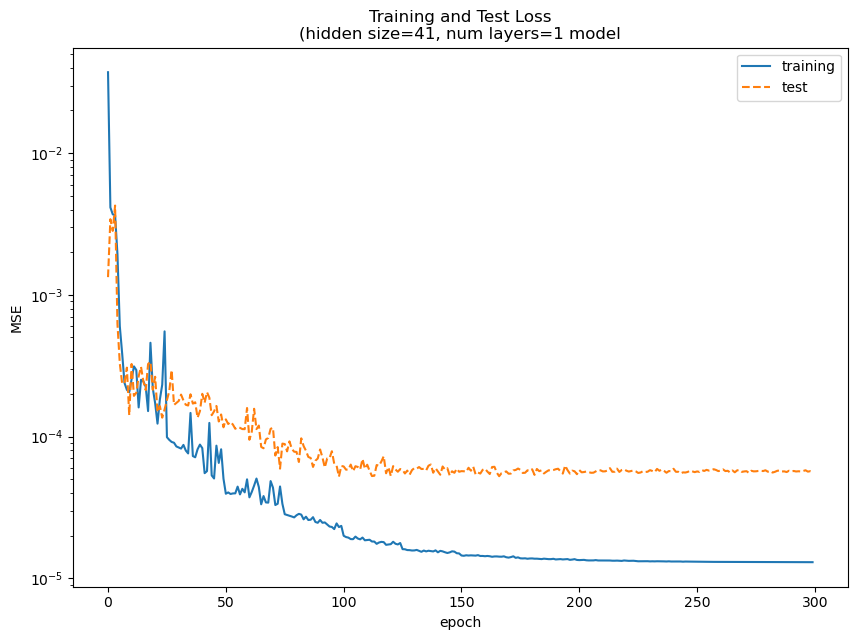

Total execution time: 185.31667590141296 seconds


In [18]:
import time

start_time = time.time()
model=LSTM_encoder_decoder(hyper_params_ENCODER, hyper_params_DECODER,coord).to(device)
model = main_program(x_tr, x_tr,Valx_tr,Valx_tr,hyper_params_ENCODER, hyper_params_DECODER,model, trainer_info, model_name)
end_time = time.time()

# Calculate and print the total execution time

total_execution_time = end_time - start_time
print(f"Total execution time: {total_execution_time} seconds")


## Loading the modela and weights

In [73]:
# Predicting into the future(1500-7500) using data from the 7500-8500 too

best_model_params = torch.load('model_Spatial_Temperature_AC_interpol_(1500-3000)_(8000-8500).pth.tar', map_location=device)['state_dict']

In [74]:
model=LSTM_encoder_decoder(hyper_params_ENCODER, hyper_params_DECODER,coord).to(device)
model.load_state_dict(best_model_params)

Initializing parameter 'encoder.LSTM.weight_ih_l0' with shape: torch.Size([120, 1])
Initializing parameter 'encoder.LSTM.weight_hh_l0' with shape: torch.Size([120, 30])
Initializing parameter 'encoder.LSTM.bias_ih_l0' with shape: torch.Size([120])
Initializing parameter 'encoder.LSTM.bias_hh_l0' with shape: torch.Size([120])
Initializing parameter 'encoder.fc1.weight' with shape: torch.Size([3, 30])
Initializing parameter 'encoder.fc1.bias' with shape: torch.Size([3])
Initializing parameter 'decoder.LSTM.weight_ih_l0' with shape: torch.Size([120, 3])
Initializing parameter 'decoder.LSTM.weight_hh_l0' with shape: torch.Size([120, 30])
Initializing parameter 'decoder.LSTM.bias_ih_l0' with shape: torch.Size([120])
Initializing parameter 'decoder.LSTM.bias_hh_l0' with shape: torch.Size([120])
Initializing parameter 'decoder.fc1.weight' with shape: torch.Size([1, 30])
Initializing parameter 'decoder.fc1.bias' with shape: torch.Size([1])


<All keys matched successfully>

In [76]:
time_step=10
time_step_test=10
encoded_size=3


## Validating against validation set

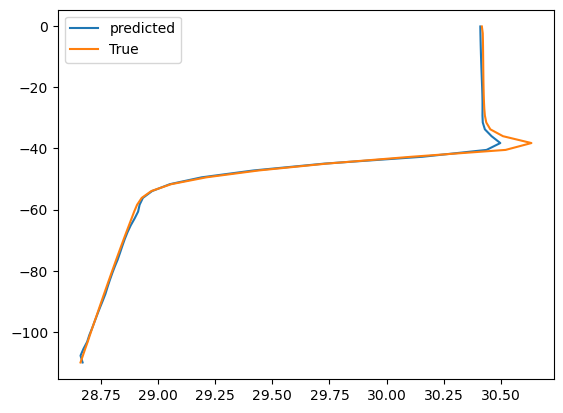

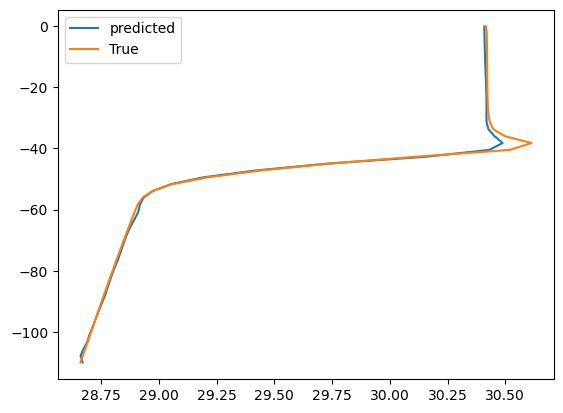

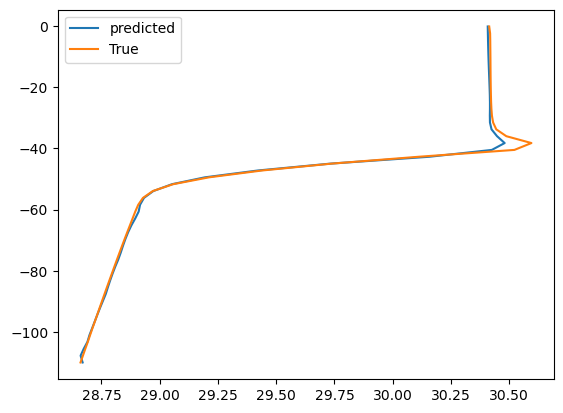

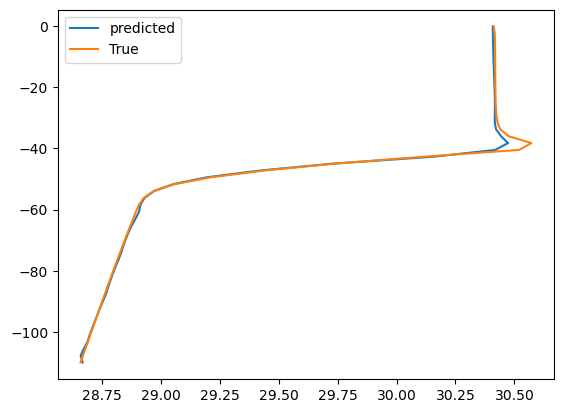

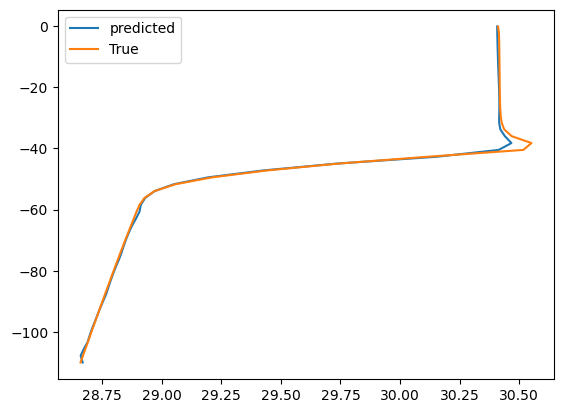

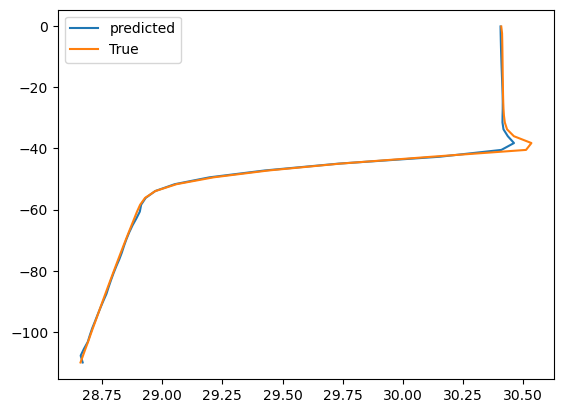

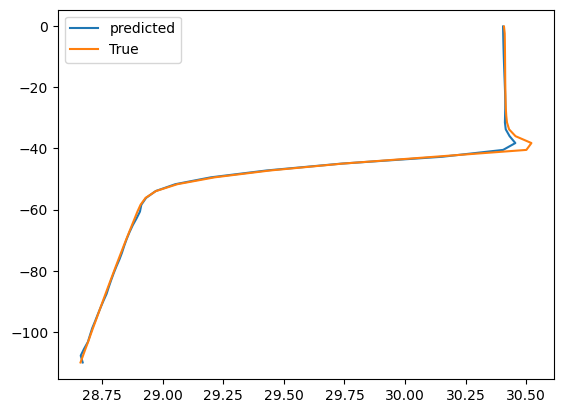

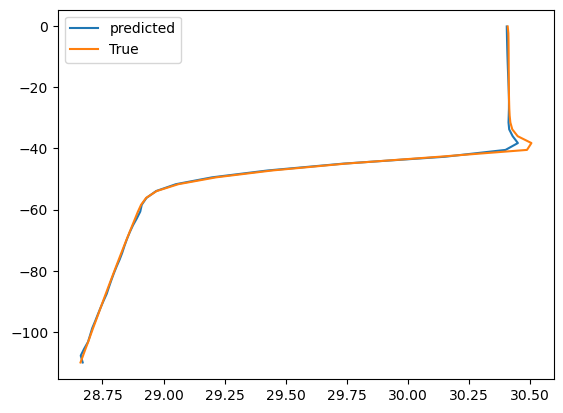

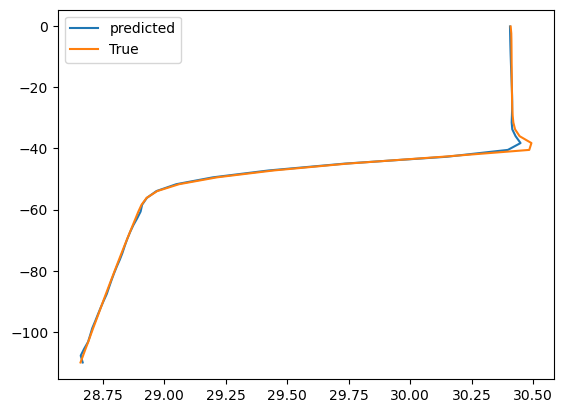

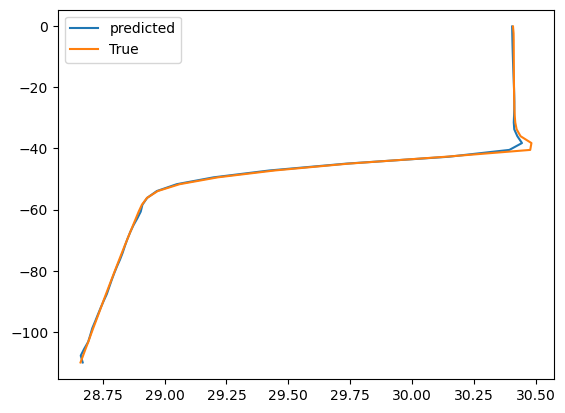

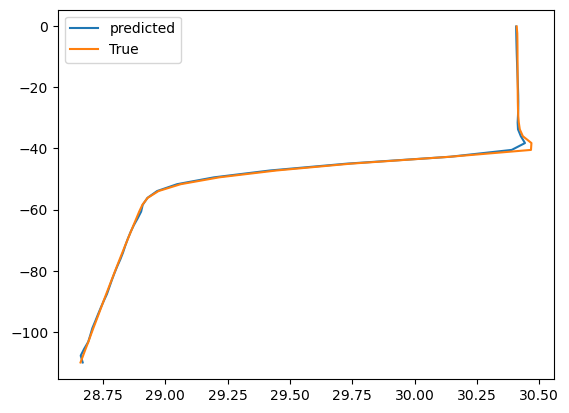

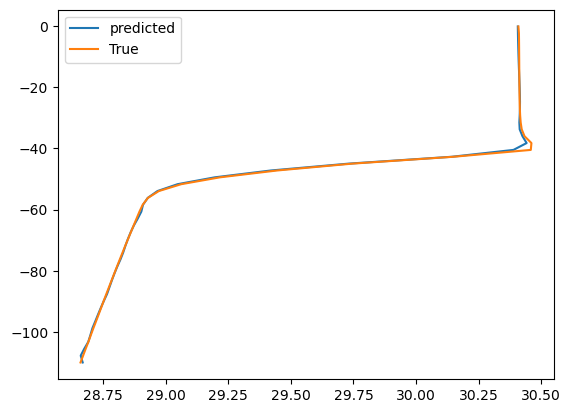

In [77]:
x_rec=torch.zeros((Valx_tr.shape[0],Valx_tr.shape[1],Valx_tr.shape[2]))
j=0
for i in range(Valx_tr.shape[0]):
    
    x_rec[i,:,:],_=model((torch.tensor(Valx_tr[i:i+1,:,:]).to(device)))
    if i%25==0:
        plt.figure(i)
        plt.plot(In.inv_transform(x_rec[i:i+1,:,:].detach().numpy())[:,:,0].T,xi,label='predicted')
        plt.plot(In.inv_transform(Valx_tr[i:i+1,:,:])[:,:,0].T,xi,label='True')
        plt.legend()
    j=j+1

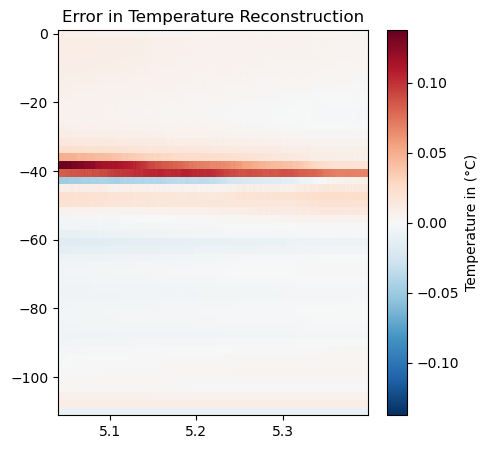

In [78]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import Normalize
[xx, tt] = np.meshgrid(xi.flatten(), hours[3000:3300]/24)
[xx, tt] = np.meshgrid(xi.flatten(), hours[3000:3300]/24)

data = In.inv_transform(Valx_tr[:,:,:])[:,:,0]-In.inv_transform(x_rec[:,:,:].cpu().detach().numpy())[:,:,0]
max_val = np.max(np.abs(data))

#norm = TwoSlopeNorm(vmin=np.min(In.inv_transform(Valx_tr[:,:,:])[:,:,0]-In.inv_transform(x_rec[:,:,:].cpu().detach().numpy())[:,:,0]), vcenter=0, vmax=np.max(In.inv_transform(Valx_tr[:,:,:])[:,:,0]-In.inv_transform(x_rec[:,:,:].cpu().detach().numpy())[:,:,0]))

norm = Normalize(vmin=-max_val, vmax=max_val)
im = ax.pcolormesh(
    tt, xx, data, 
    label='predicted', norm=norm, cmap="RdBu_r"
)


#im=ax.pcolormesh(tt,xx,In.inv_transform(Testx_tr[time_step:,:,:])[:,:,0]-In.inv_transform(x_rec[time_step:,:,:].cpu().detach().numpy())[:,:,0],label='predicted')
ax.set_title('Error in Temperature Reconstruction')

colo=plt.colorbar(im, ax=ax)
colo.set_label('Temperature in (\u00b0C)')
plt.show()

## Testing the Autoencoder

In [79]:
Testx=Input[1500-time_step_test:7500,:,0:1].astype(np.float32) ## C
Testx_tr=In.transform(Testx)
#Testx_tr=torch.from_numpy(Text_tr).float().to(device)
print(Testx_tr.shape)
endtime=7500

(6010, 50, 1)


In [ ]:
# Testing for completely different regime(no thermal inversion layer) for the entire dataset!!!!
data=loadmat("Input_ROM_No_TI")

Input_NTI=data['TT'].astype(np.float32)

Test_NTI=Input_NTI[:,:,0:1]

tes=MinMax_Scaler(Test_NTI)
Test_NTI_tr=tes.transform(Test_NTI)

print(Test_NTI_tr.shape)



In [81]:
x_rec=torch.zeros((Testx_tr.shape[0],x_tr.shape[1],x_tr.shape[2]))
j=0
for i in range(Testx_tr.shape[0]):
    x_rec[i,:,:],_=model((torch.tensor(Testx_tr[i:i+1,:,:]).to(device)))
    '''if i%25==0:
        plt.figure(i)
        plt.plot(In.inv_transform(x_rec[i:i+1,:,:].detach().numpy())[:,:,0].T,xi,label='predicted')
        plt.plot(In.inv_transform(Testx_tr[i:i+1,:,:])[:,:,0].T,xi,label='True')
        plt.legend()'''
    j=j+1

In [82]:
x_rec1=np.zeros((x_rec.shape[0],240,1))
Testx_tr1=np.zeros((Testx_tr.shape[0],240,1))

for i in range(Testx_tr.shape[0]): 
    x_rec1[i,:,:]=griddata(xi,x_rec[i,:,0:1].cpu().detach().numpy(),points,method='cubic')
    Testx_tr1[i,:,:]=griddata(xi,Testx_tr[i,:,0:1],points,method='cubic')
    
print(x_rec1.shape)
print(Testx_tr1.shape)

x_rec1=torch.from_numpy(x_rec1)

(6010, 240, 1)
(6010, 240, 1)


/tmp/ipykernel_540/1182836400.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(i)


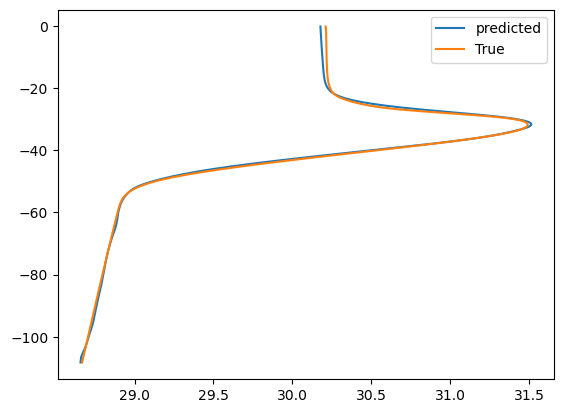

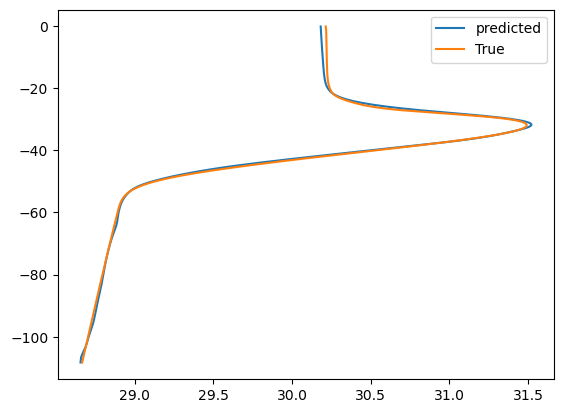

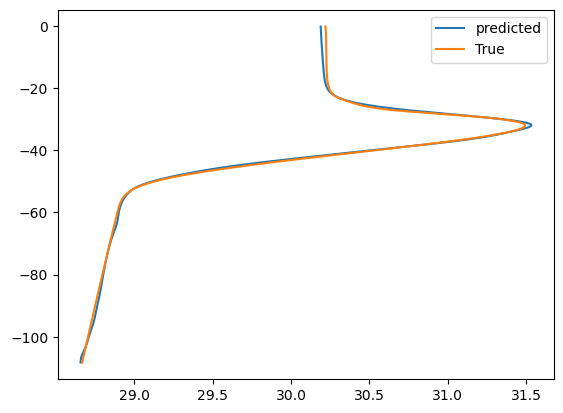

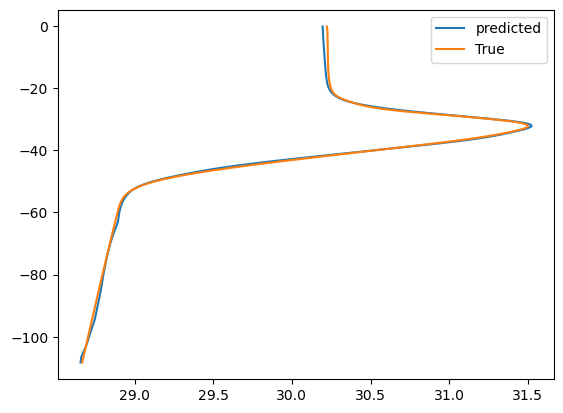

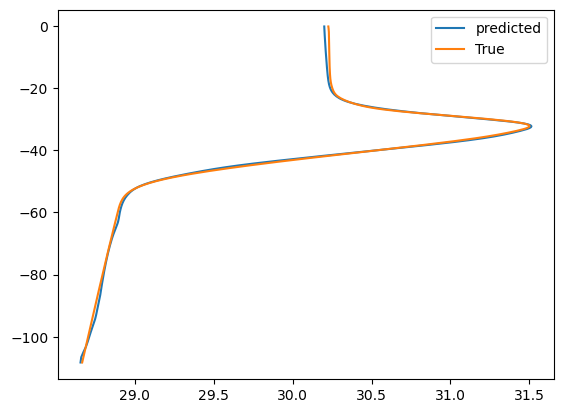

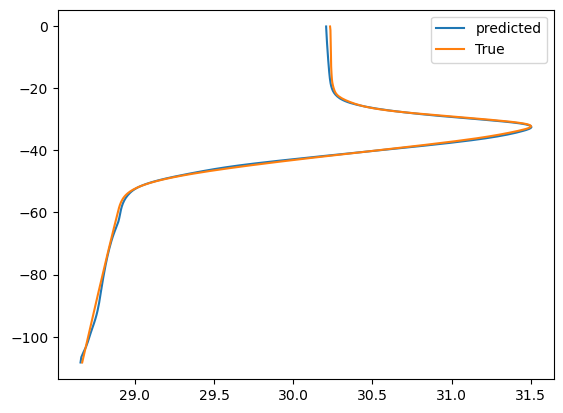

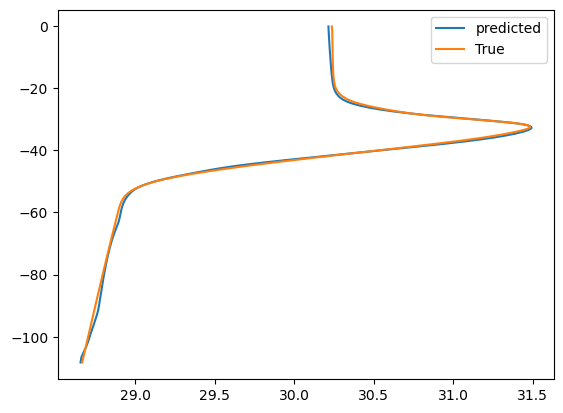

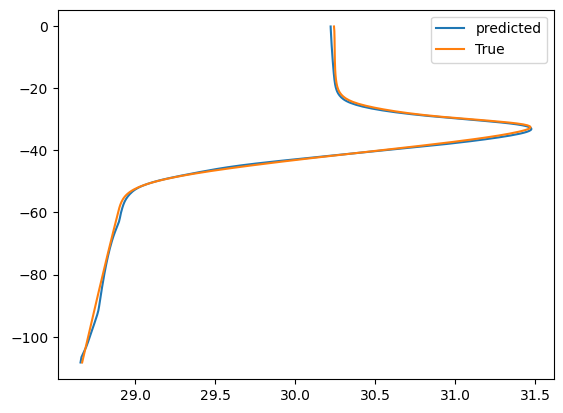

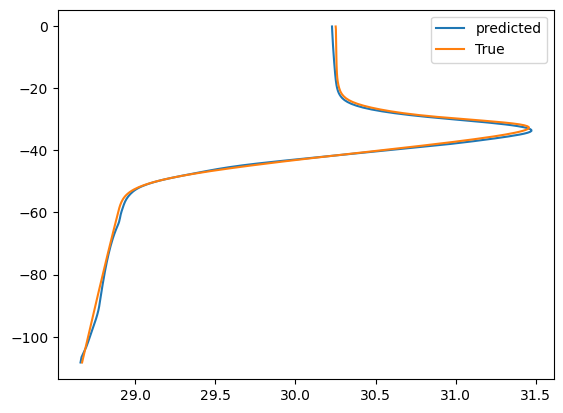

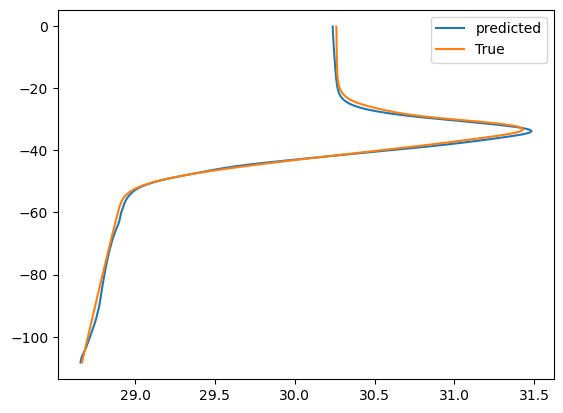

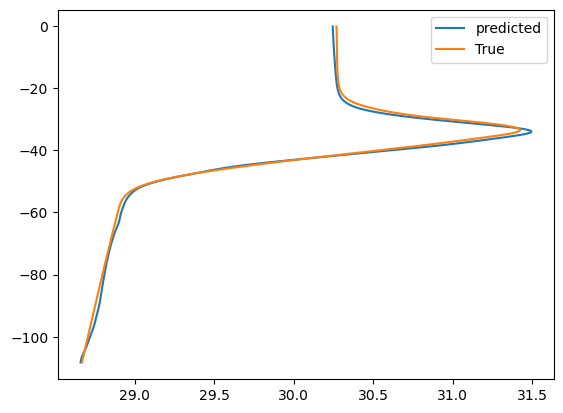

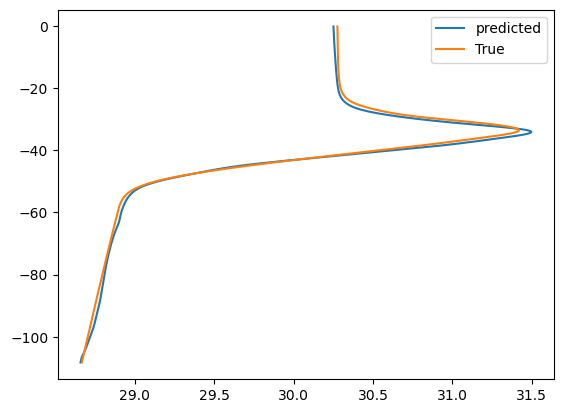

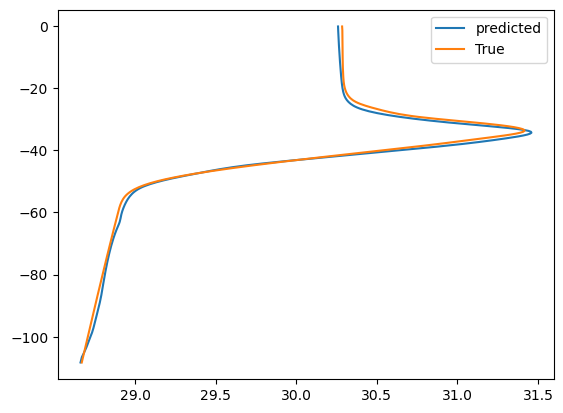

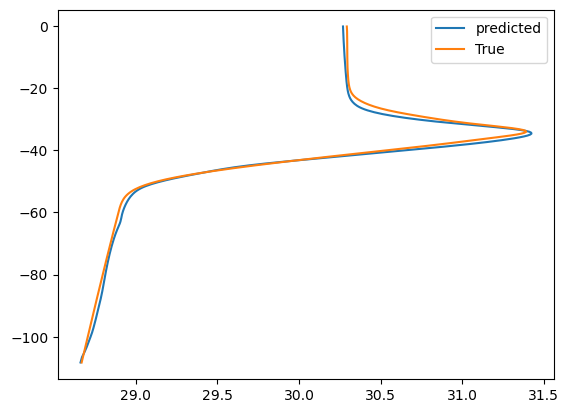

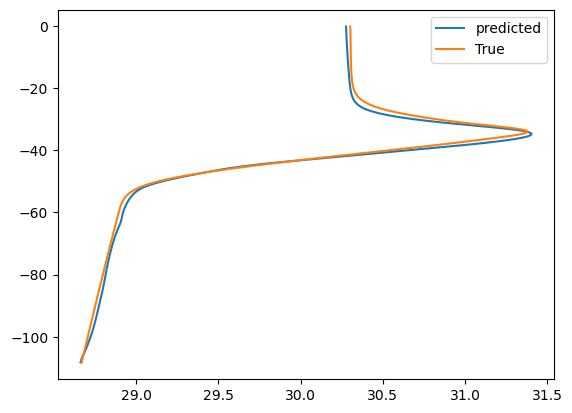

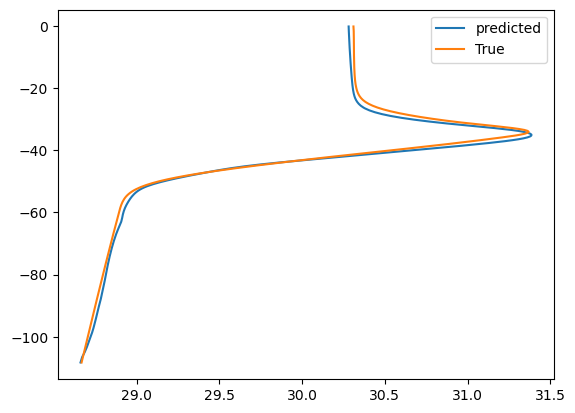

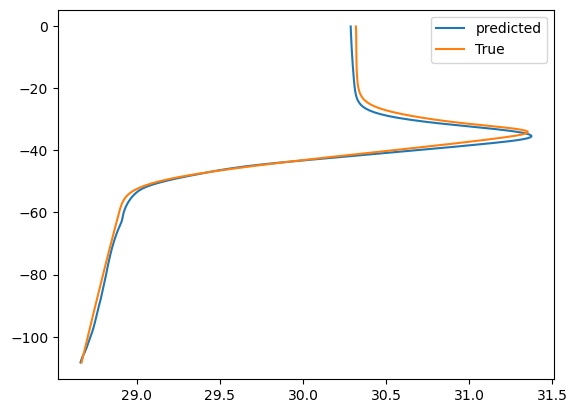

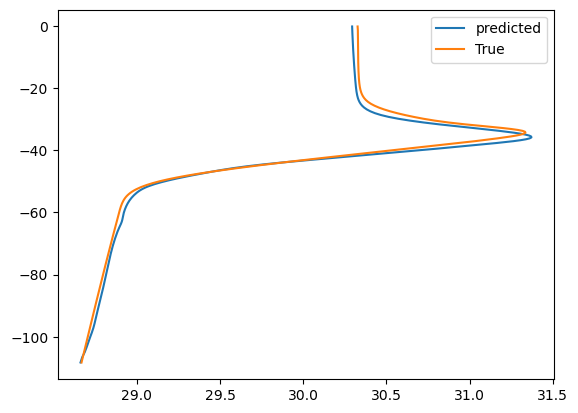

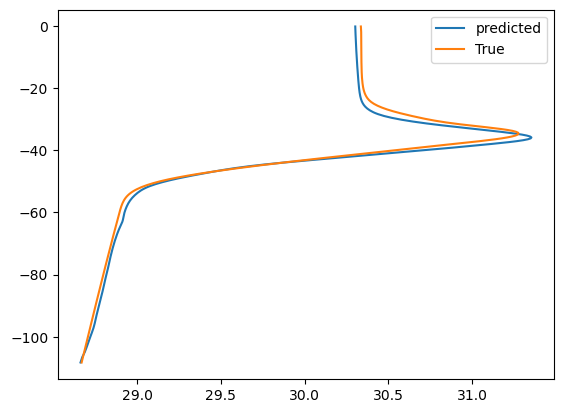

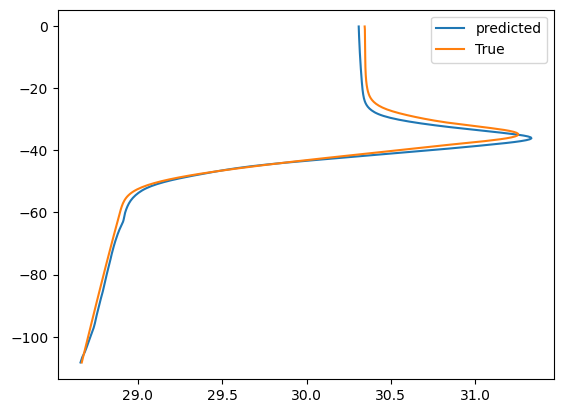

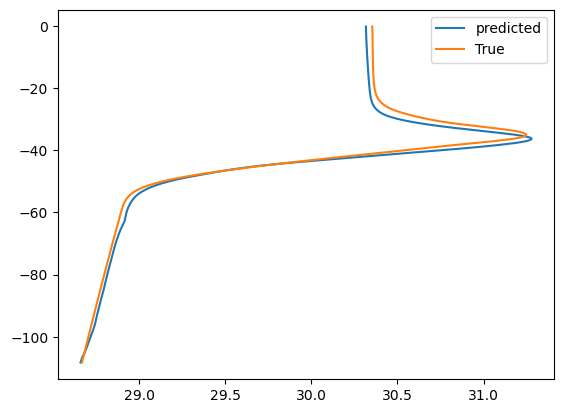

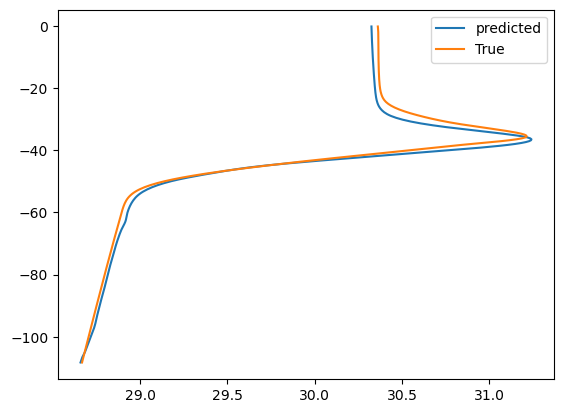

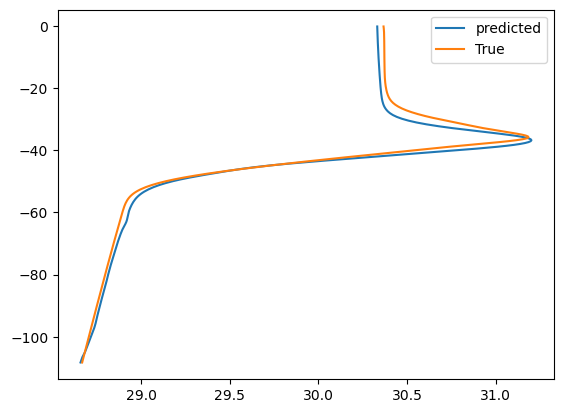

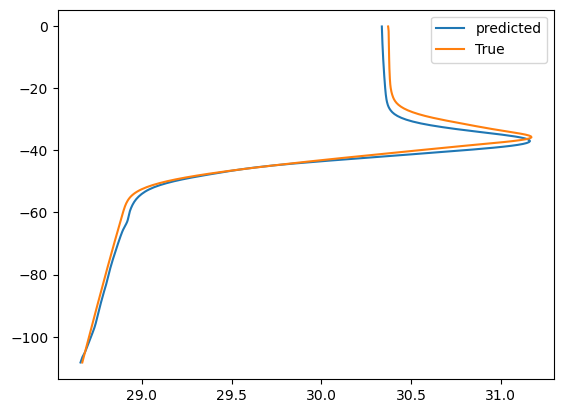

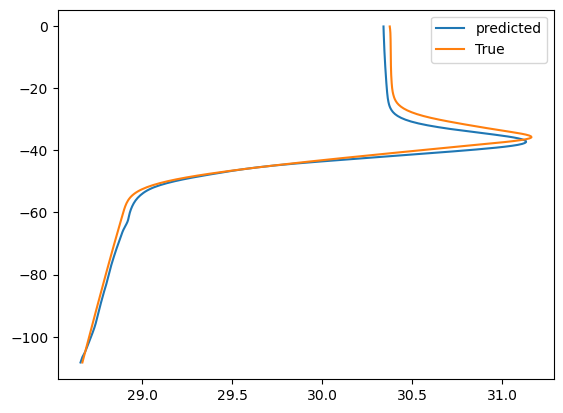

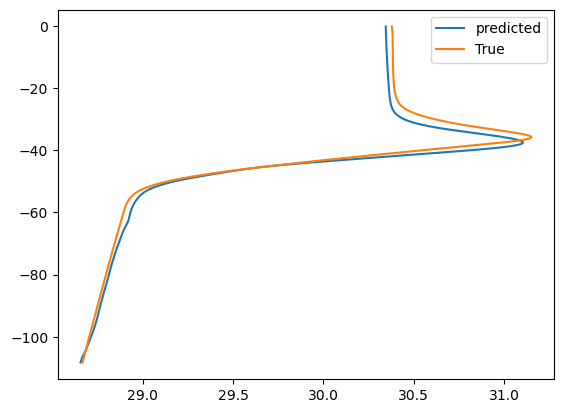

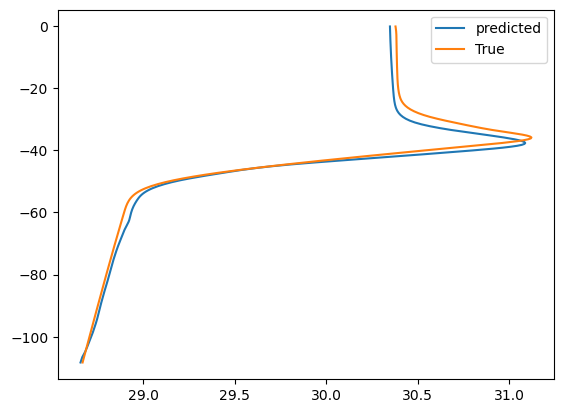

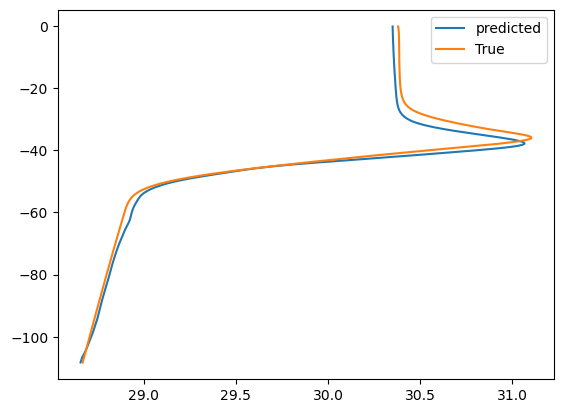

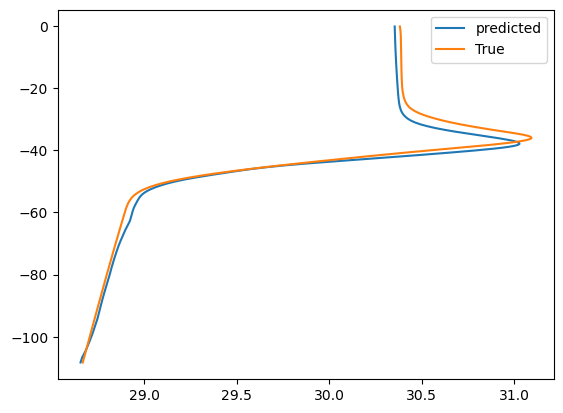

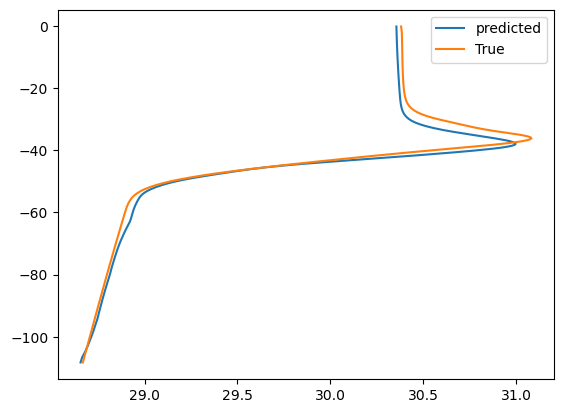

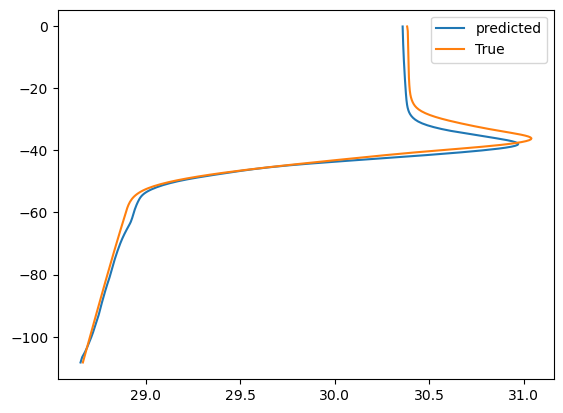

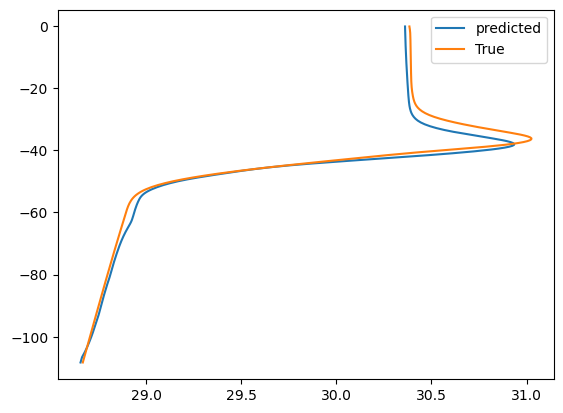

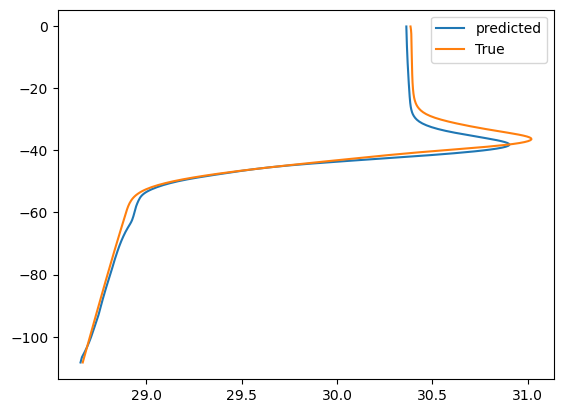

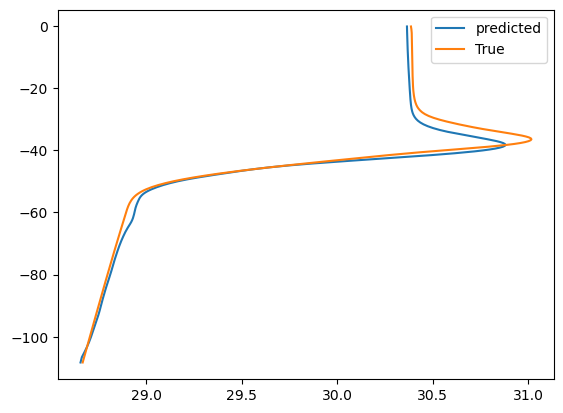

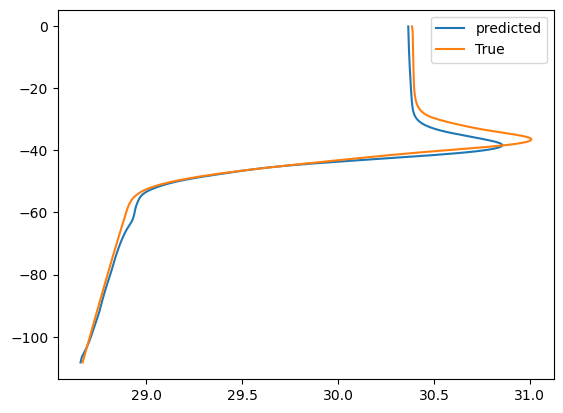

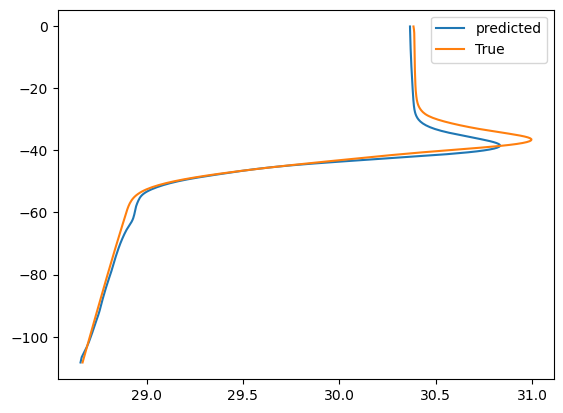

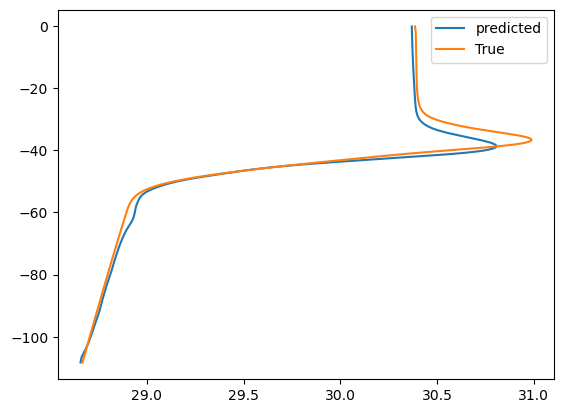

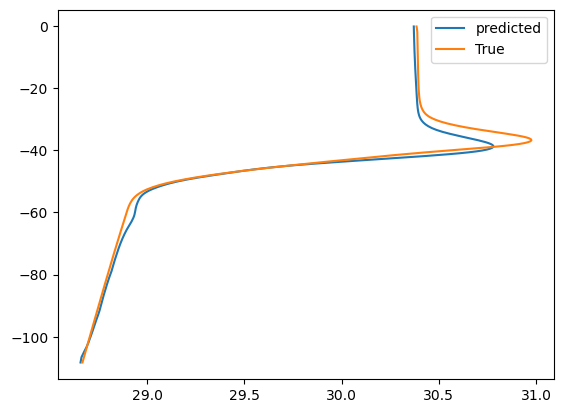

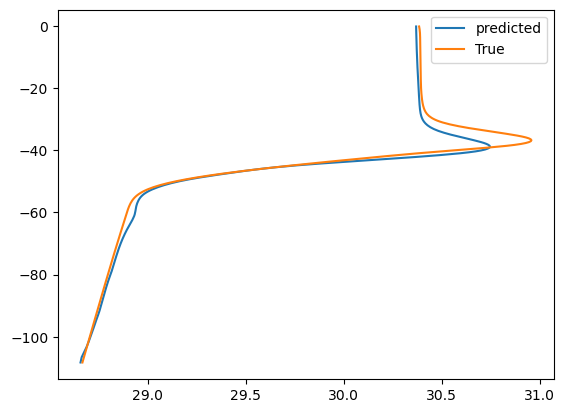

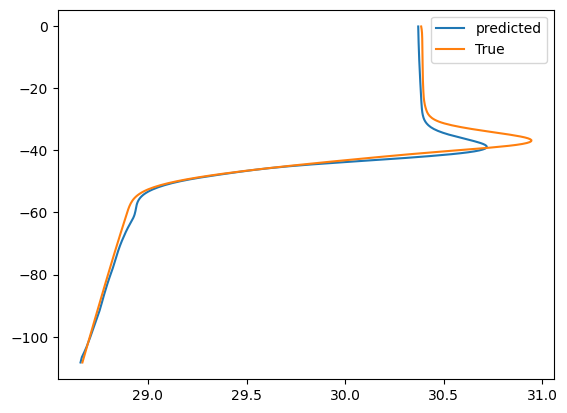

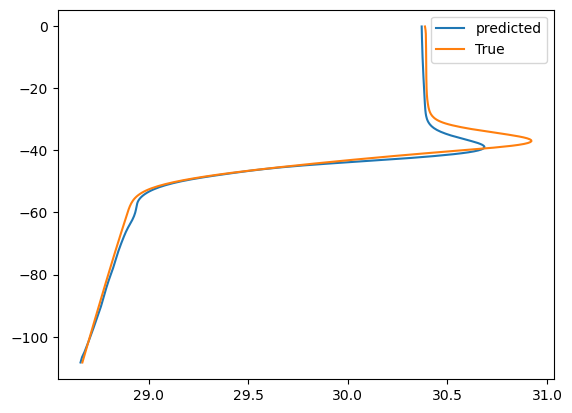

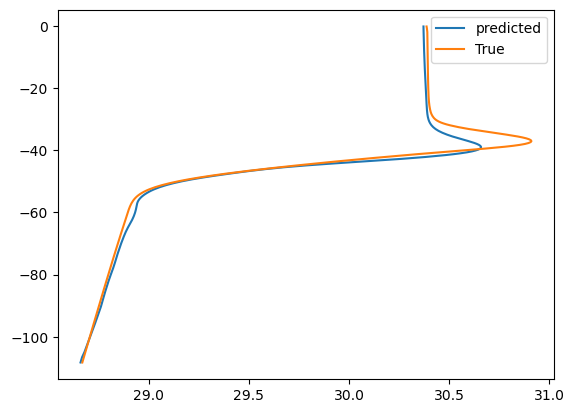

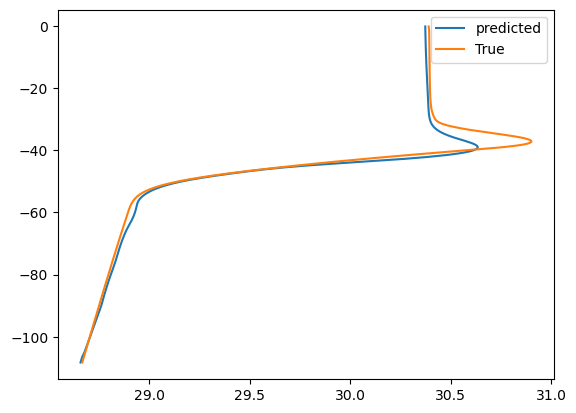

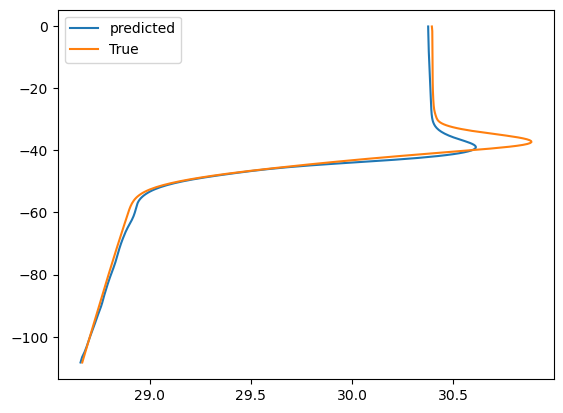

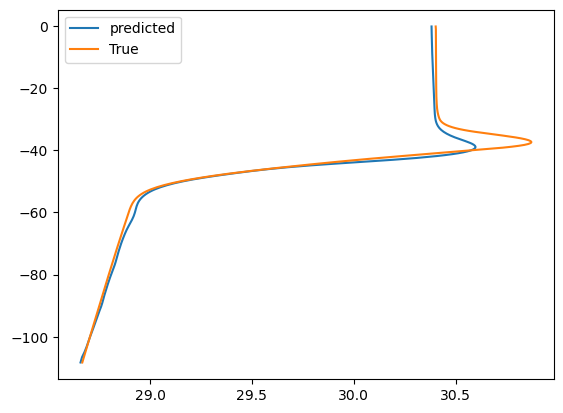

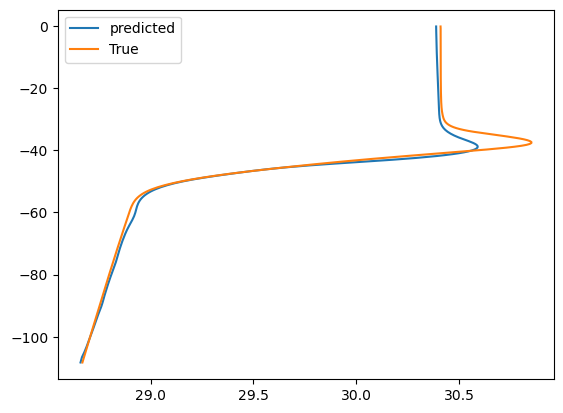

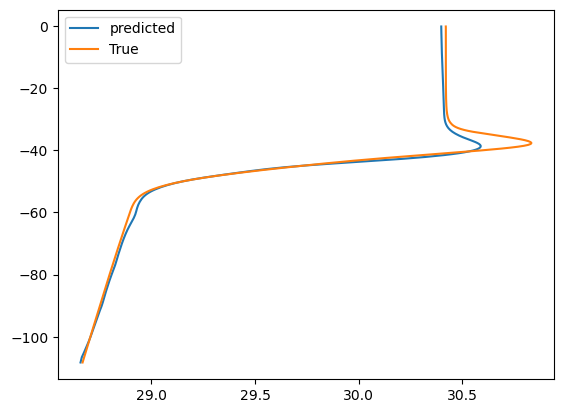

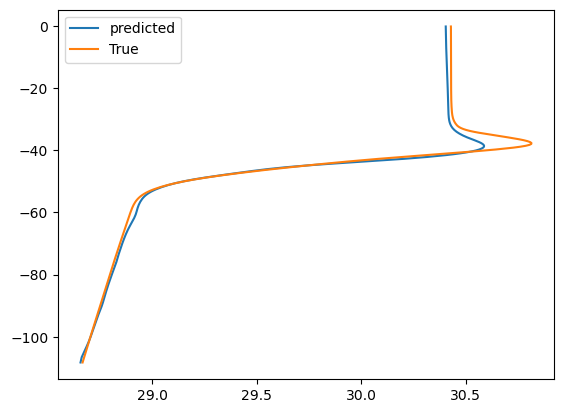

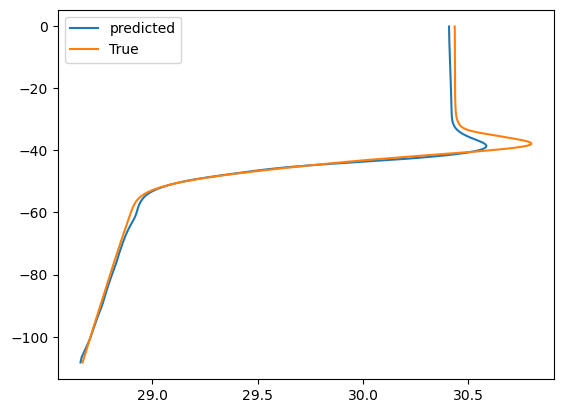

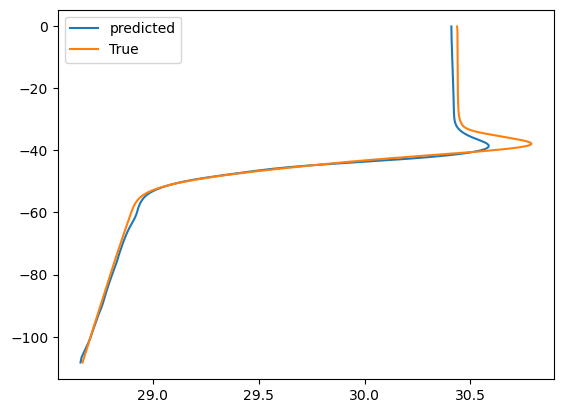

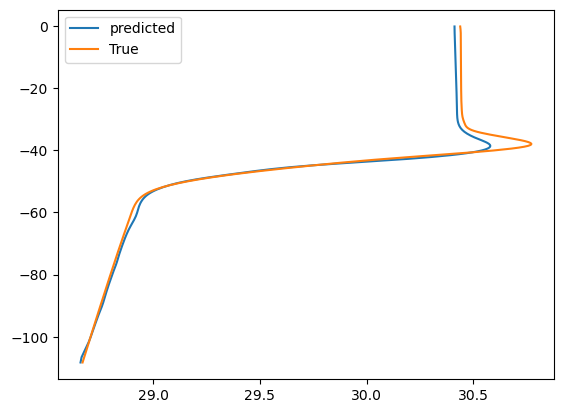

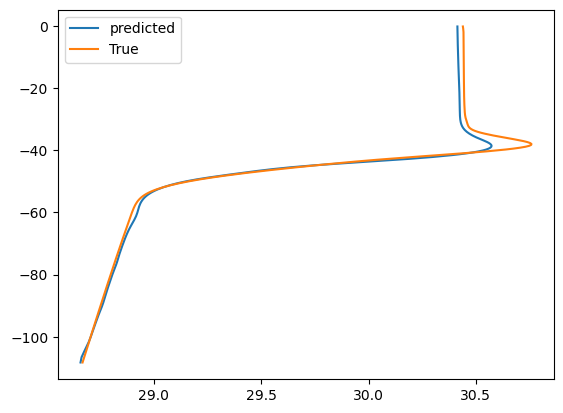

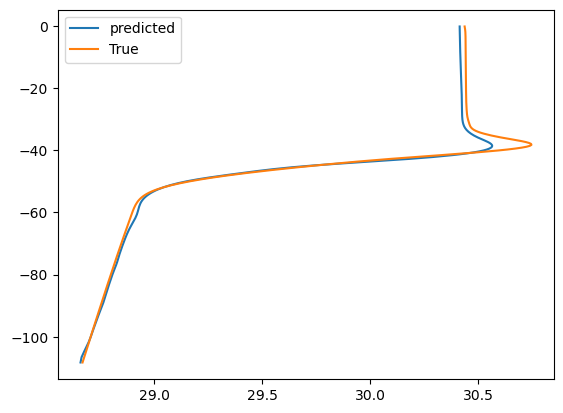

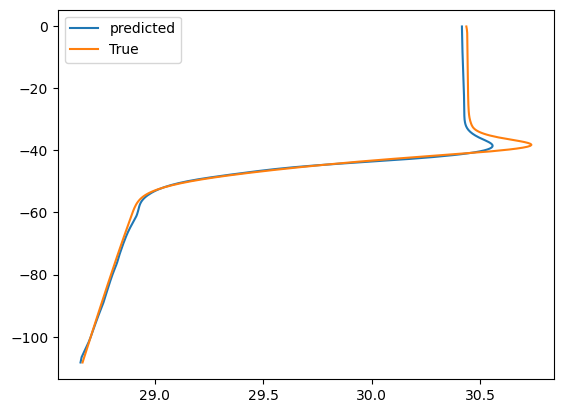

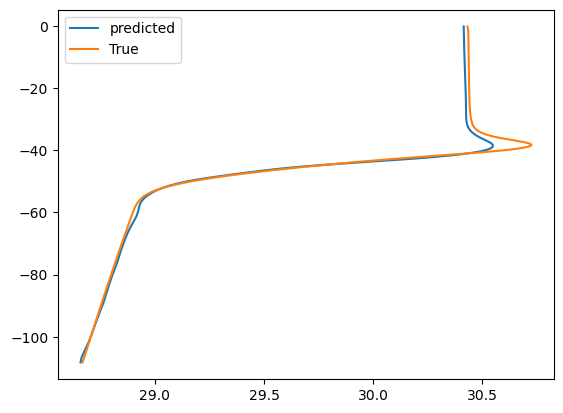

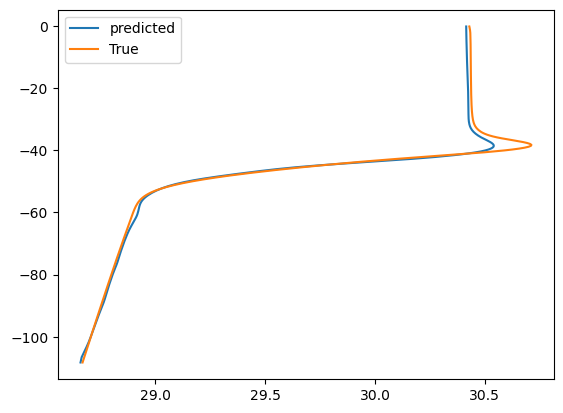

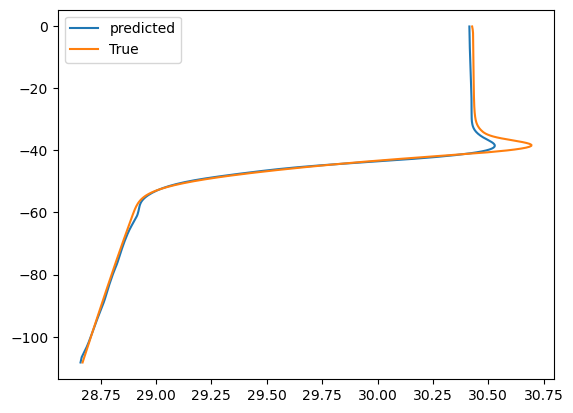

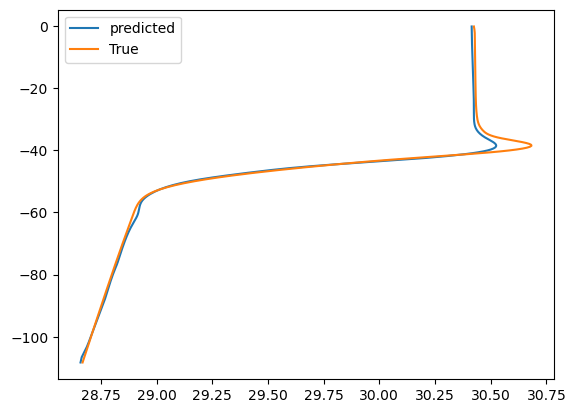

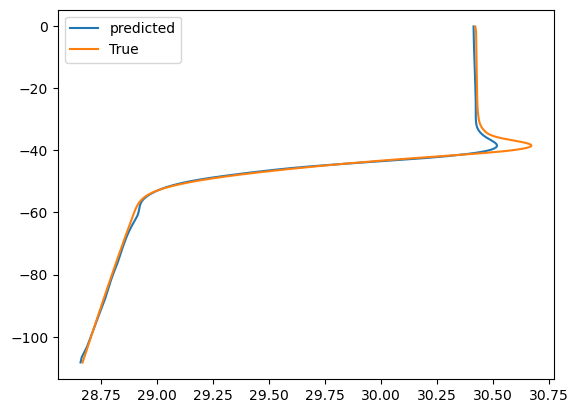

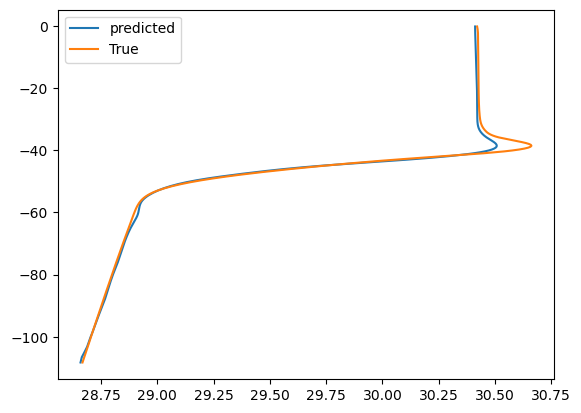

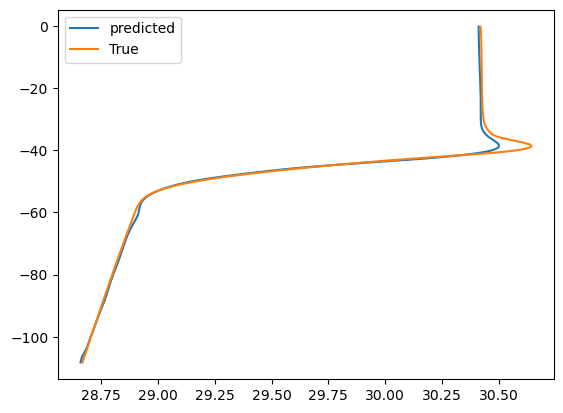

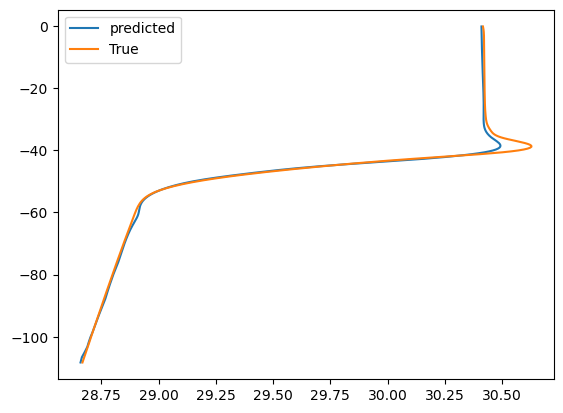

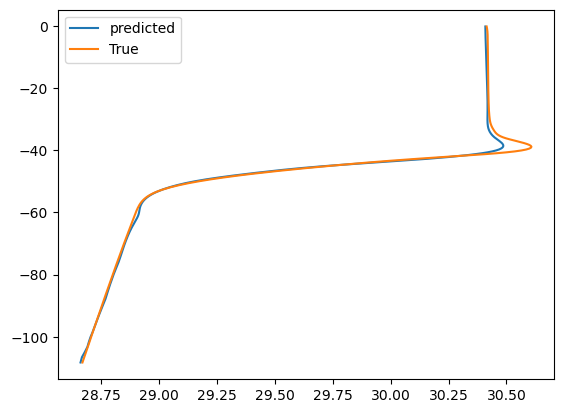

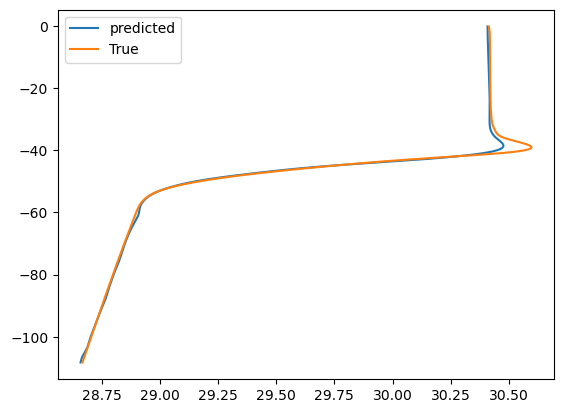

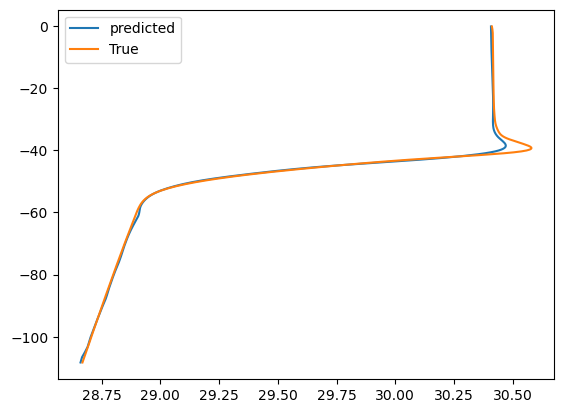

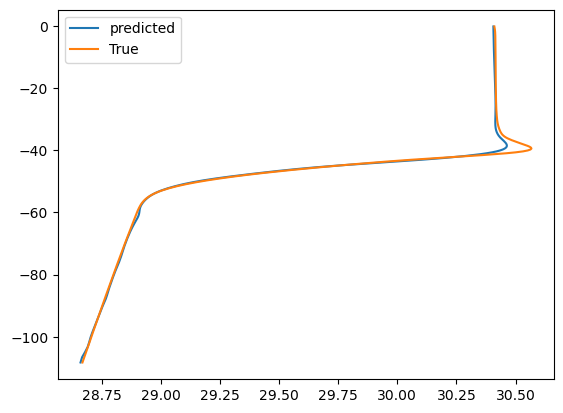

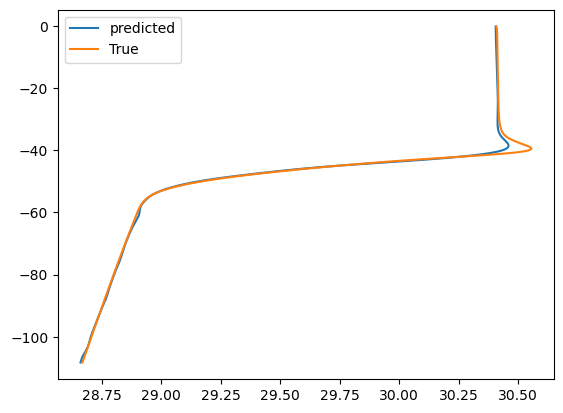

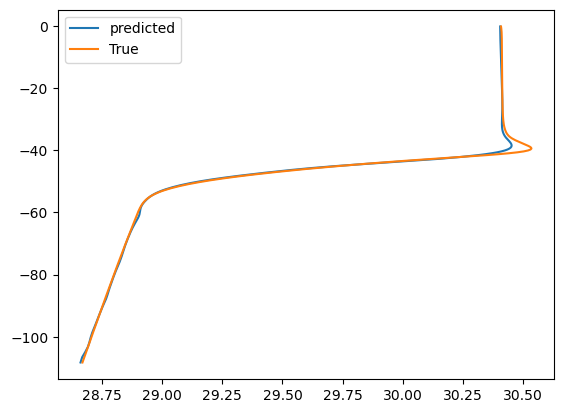

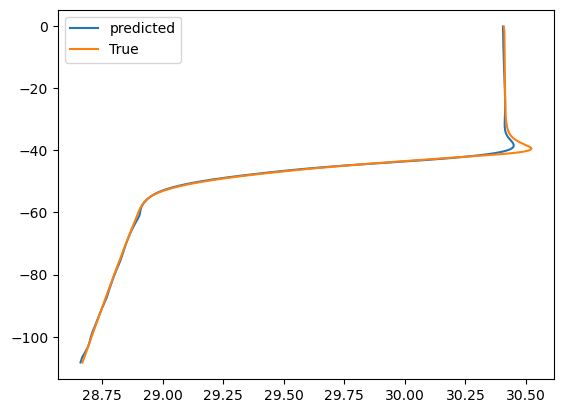

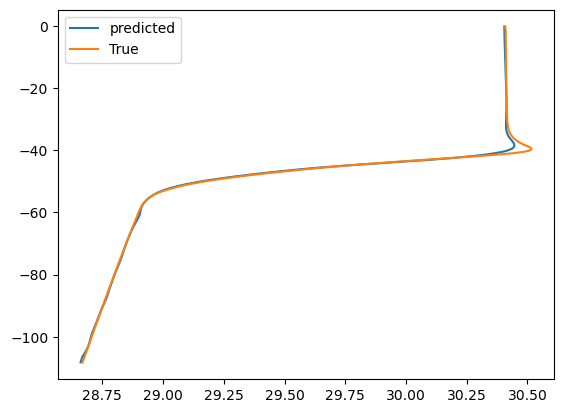

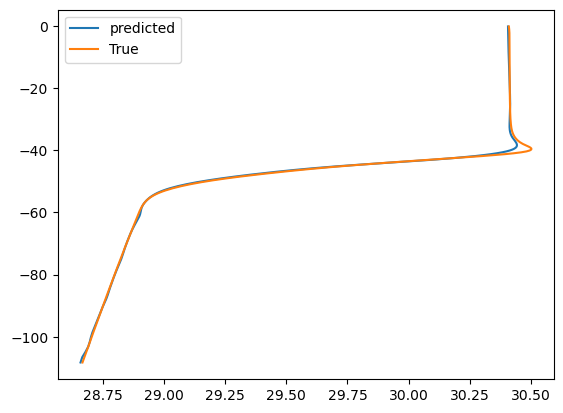

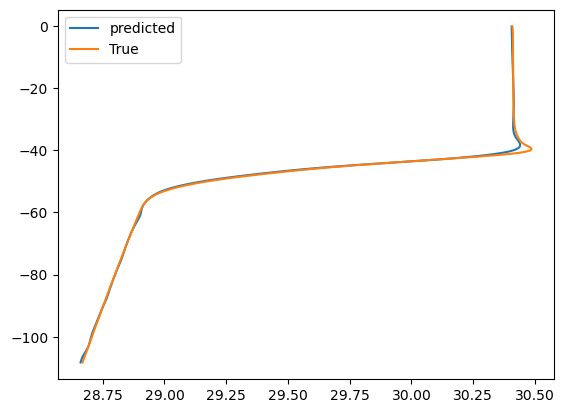

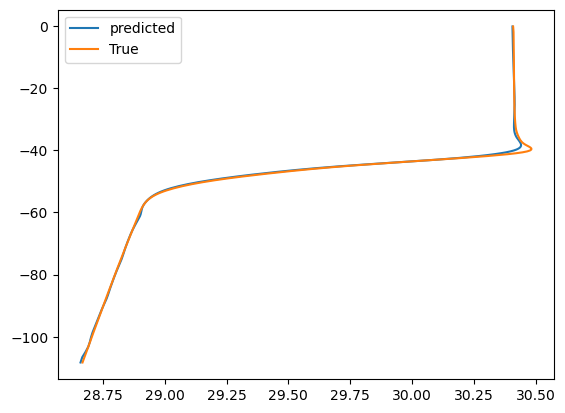

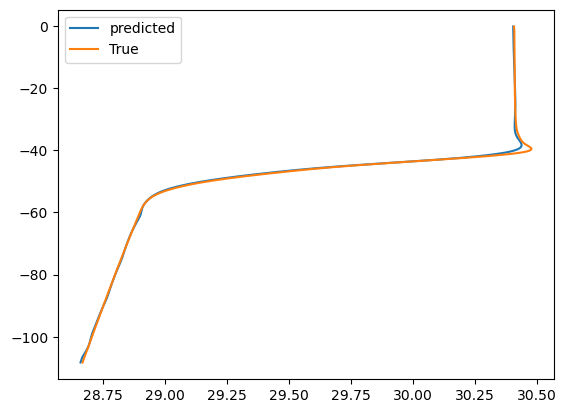

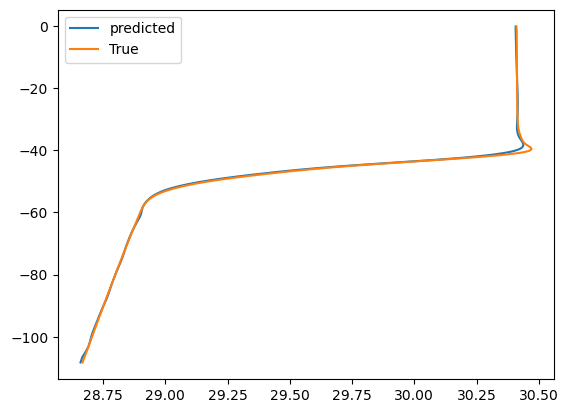

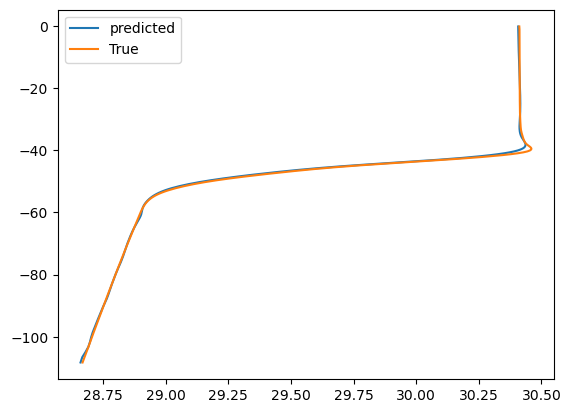

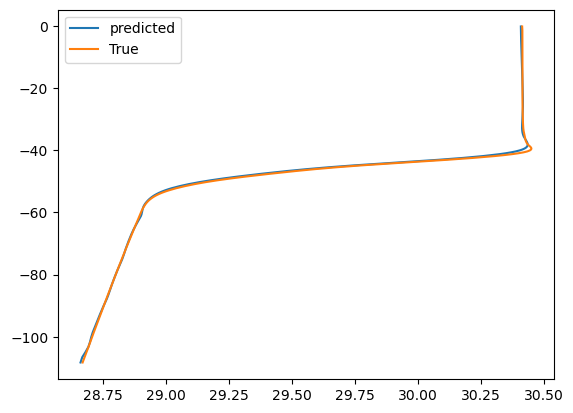

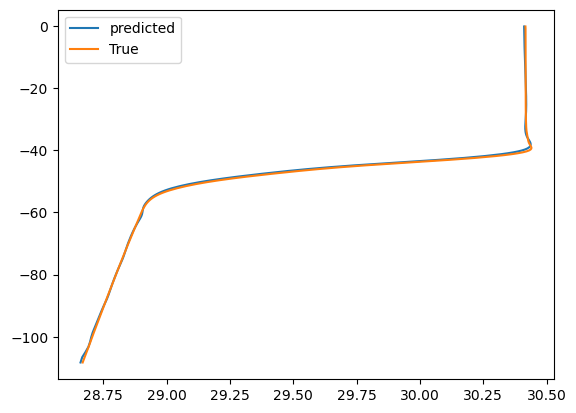

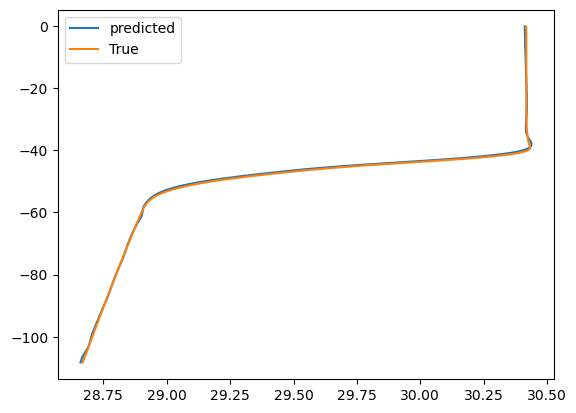

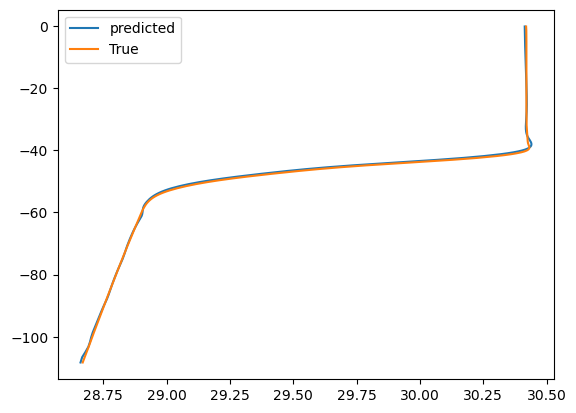

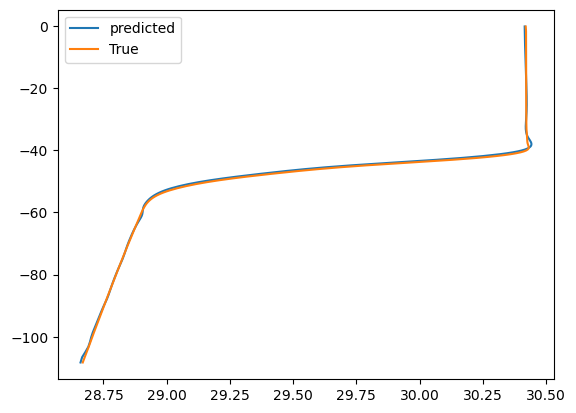

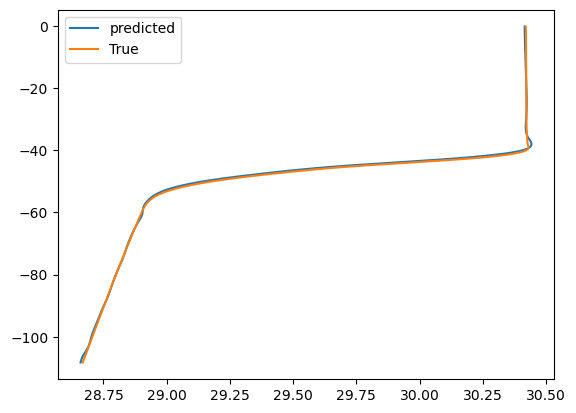

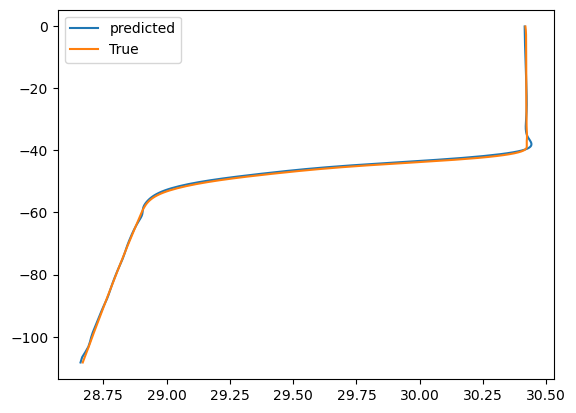

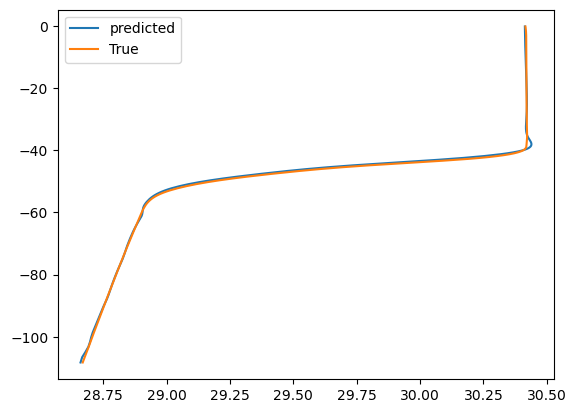

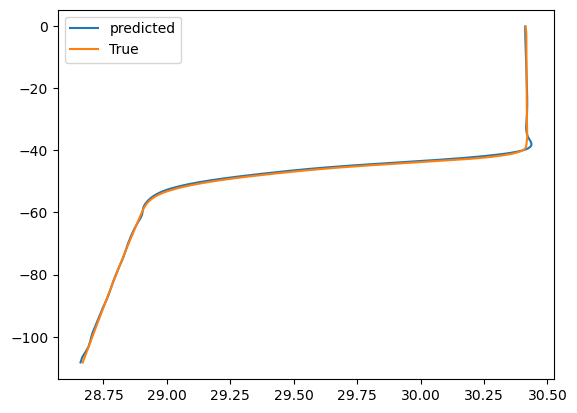

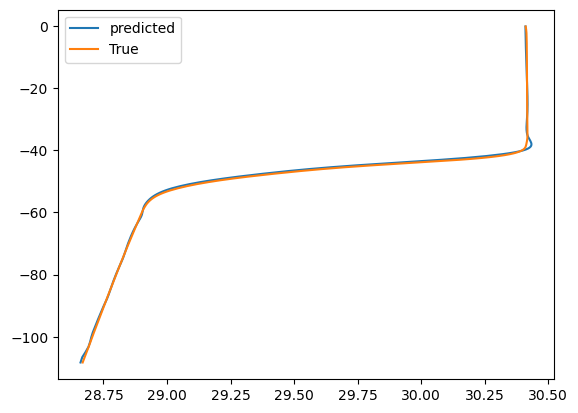

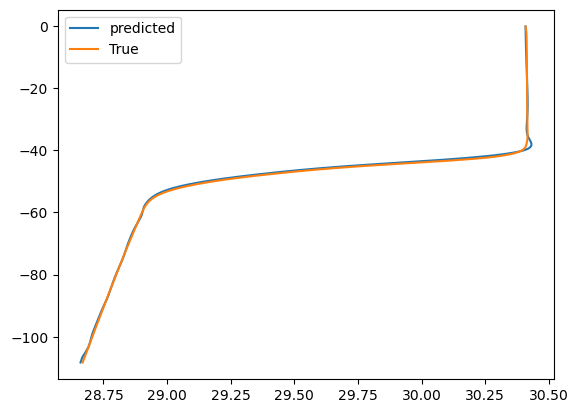

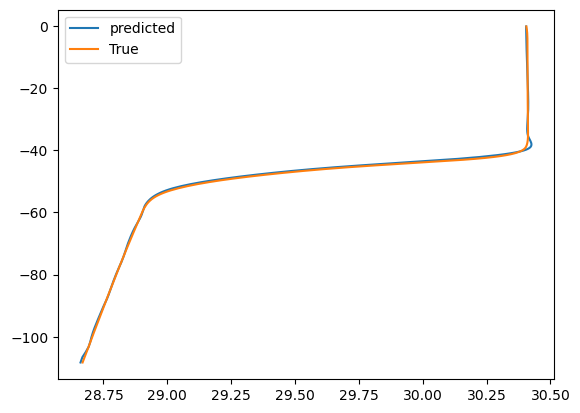

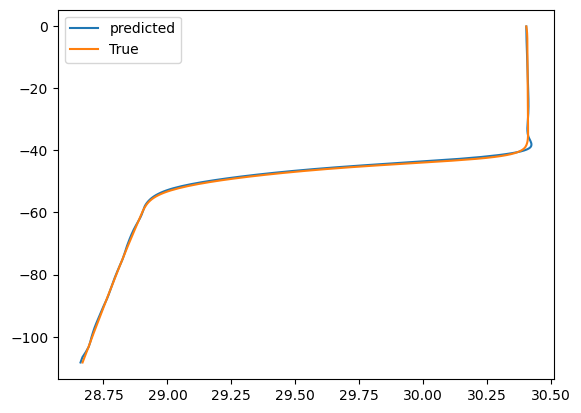

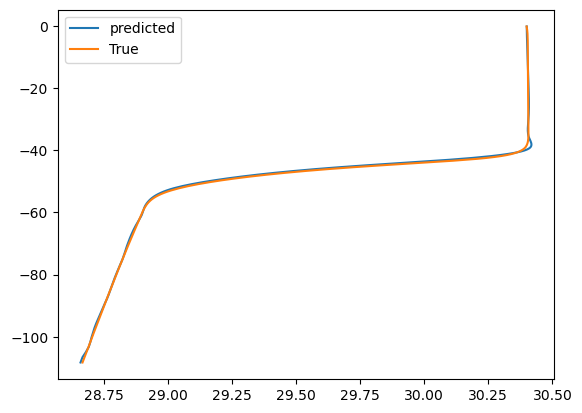

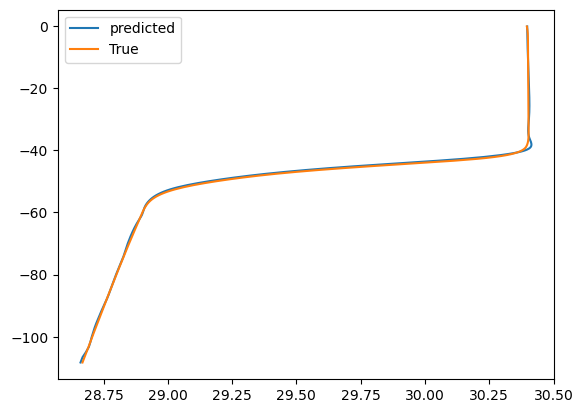

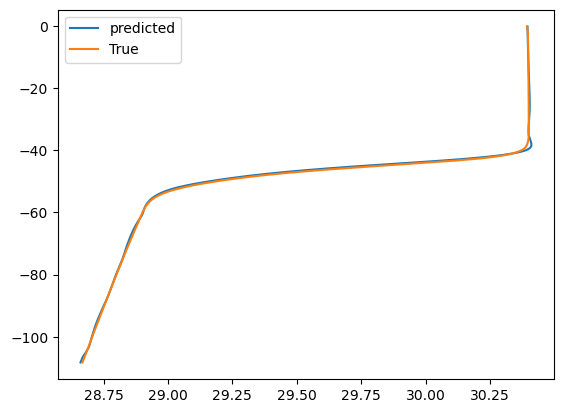

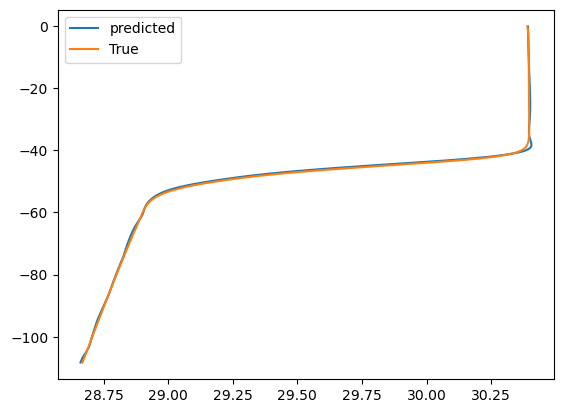

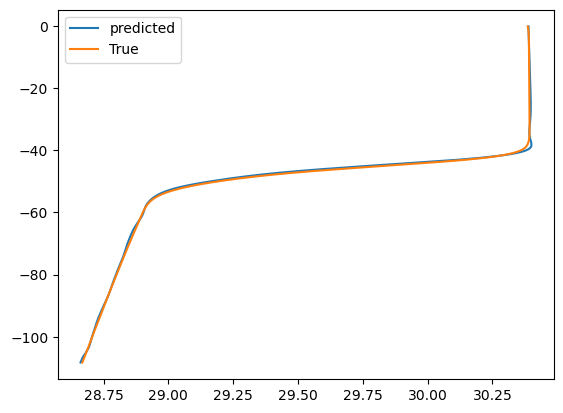

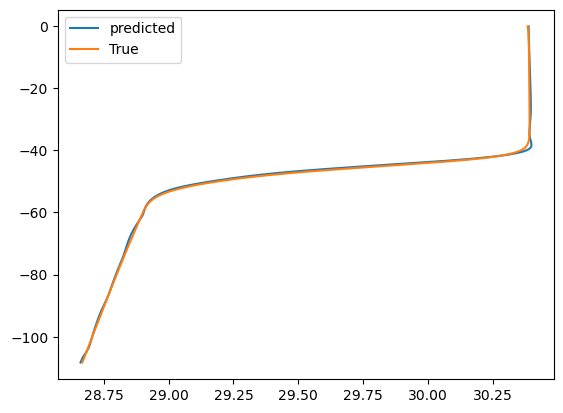

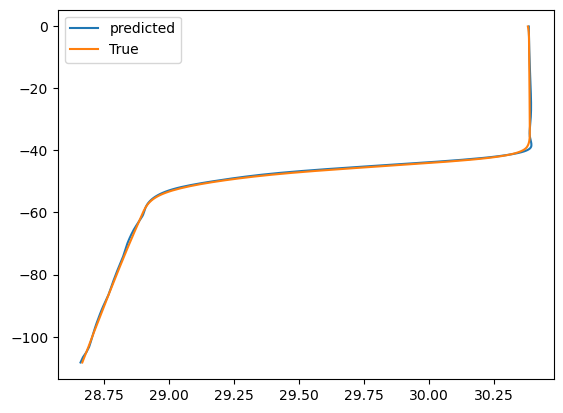

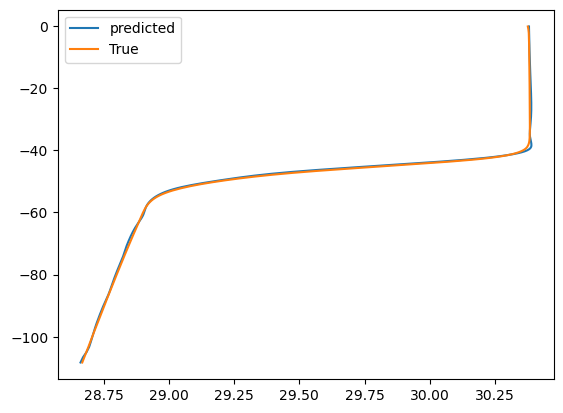

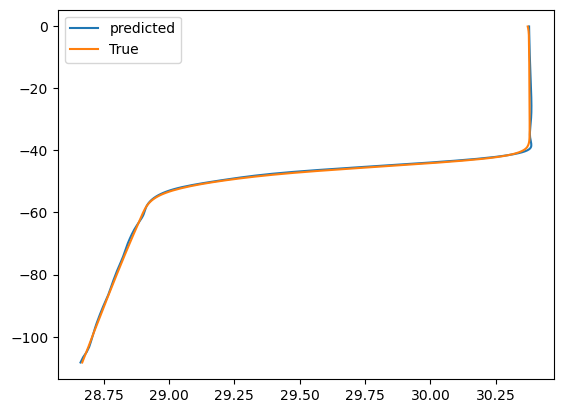

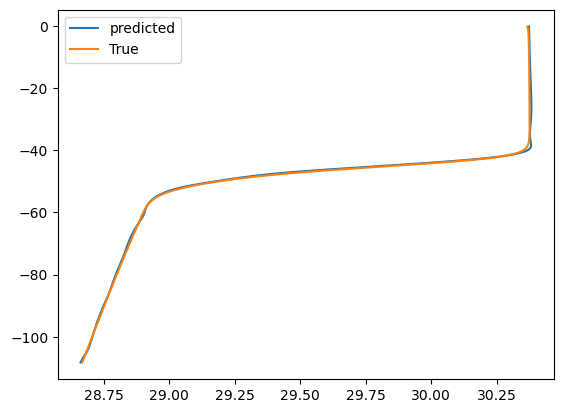

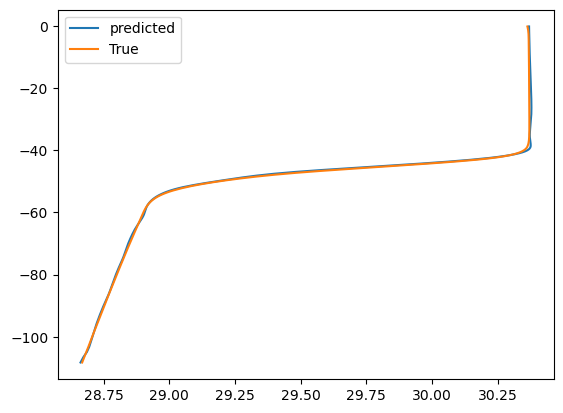

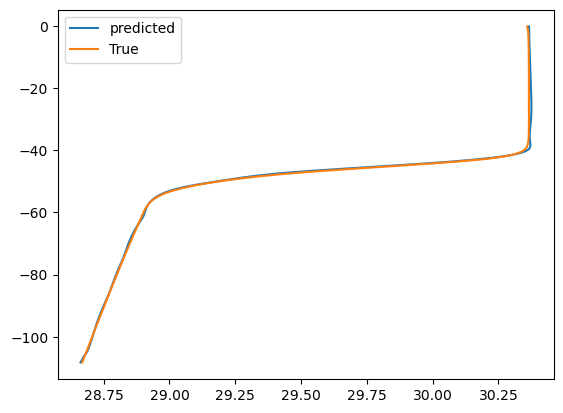

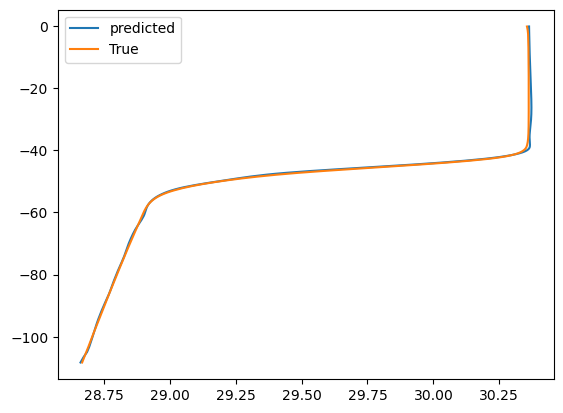

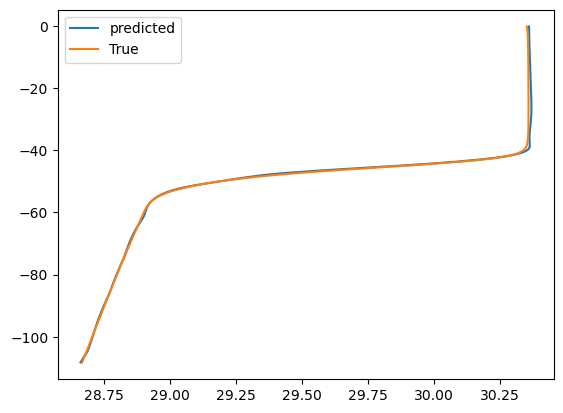

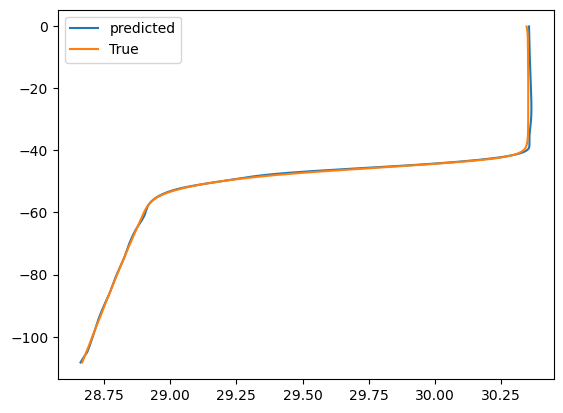

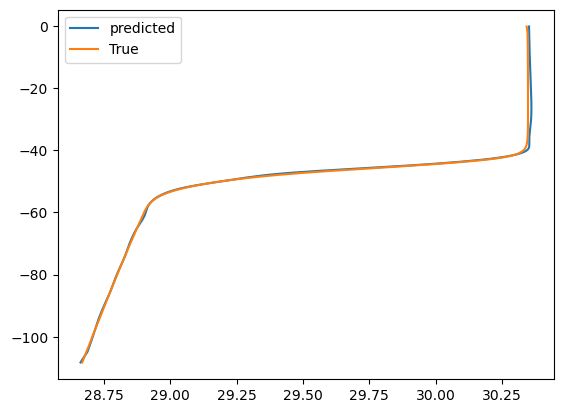

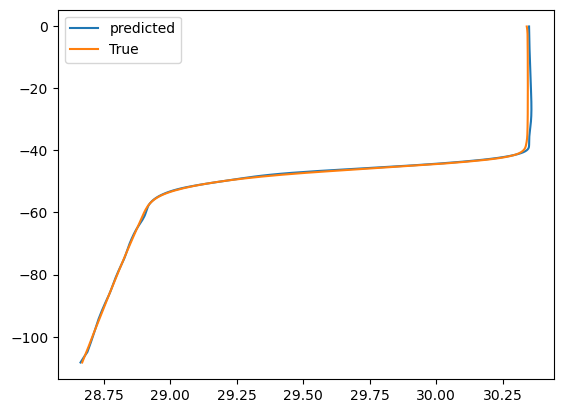

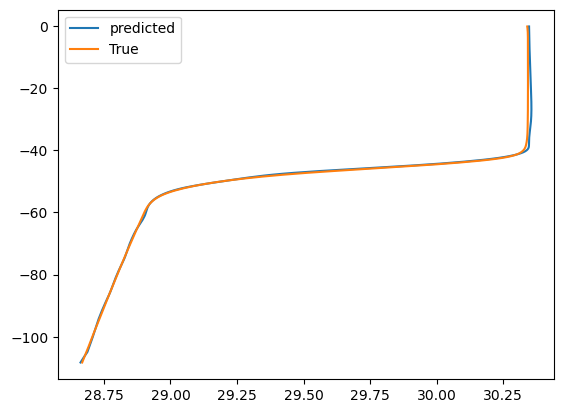

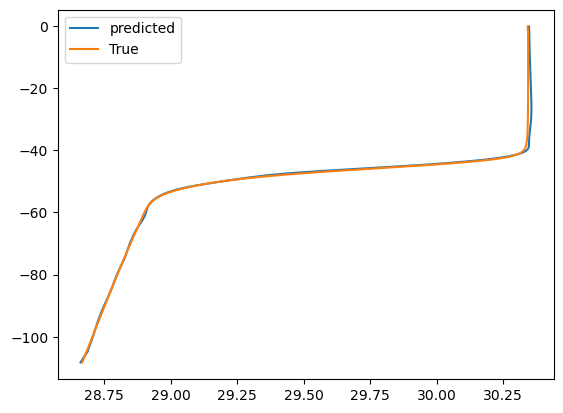

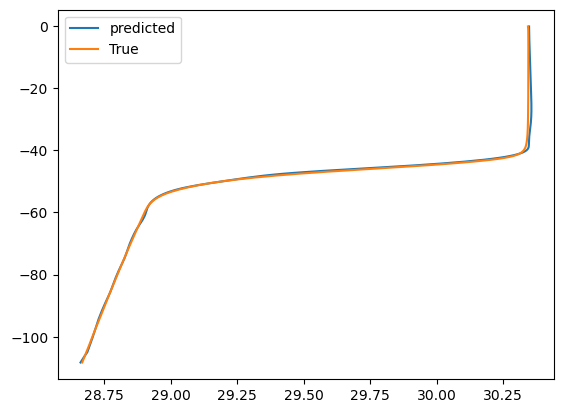

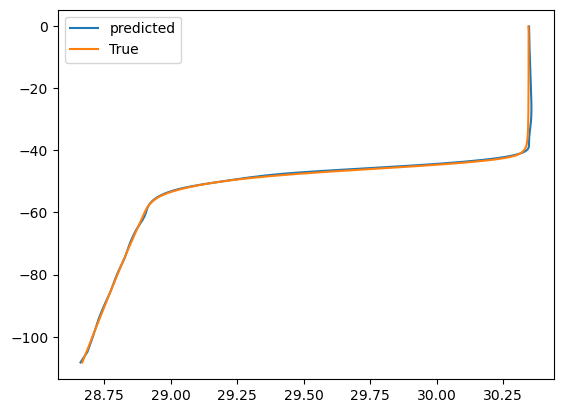

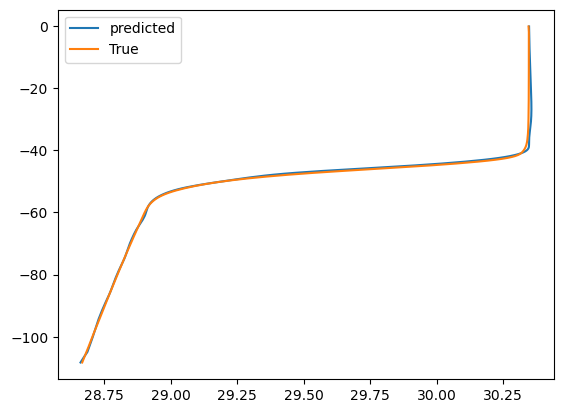

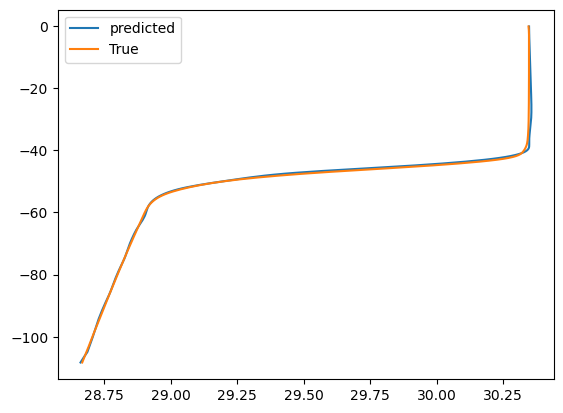

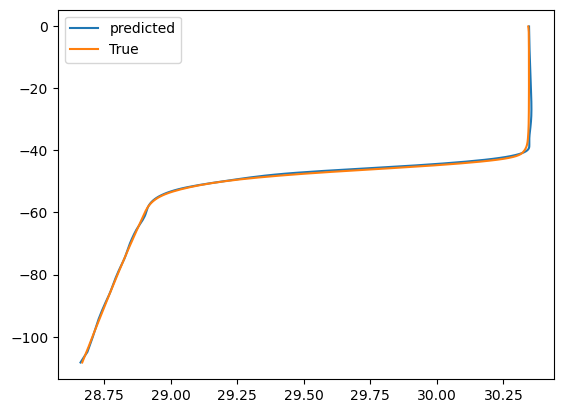

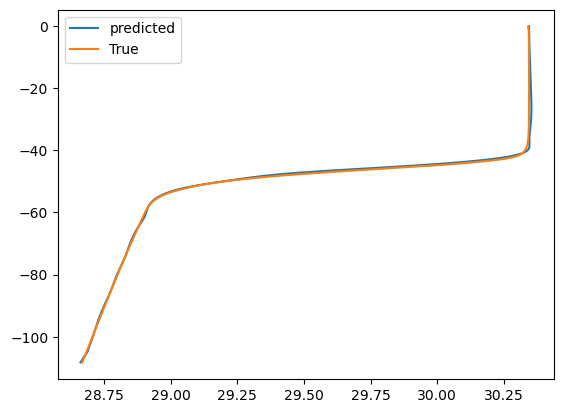

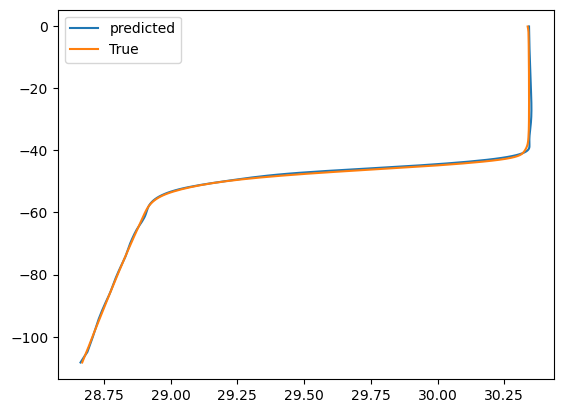

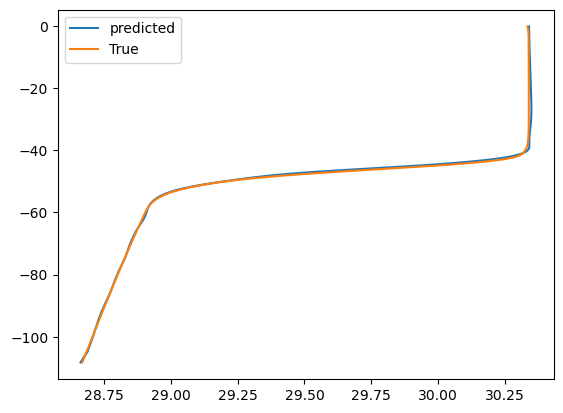

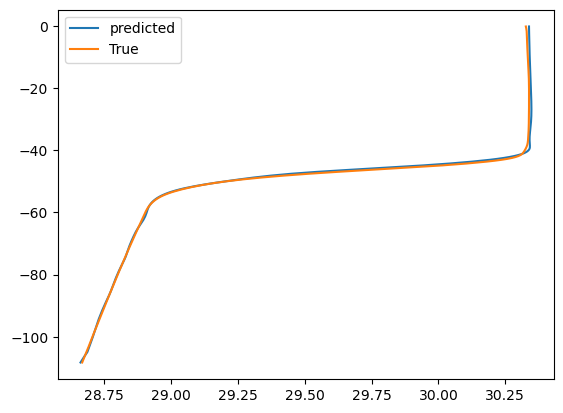

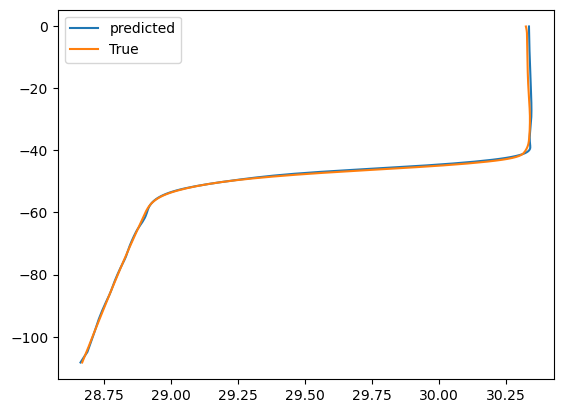

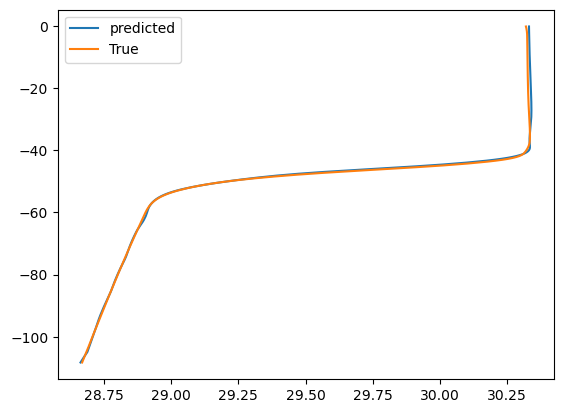

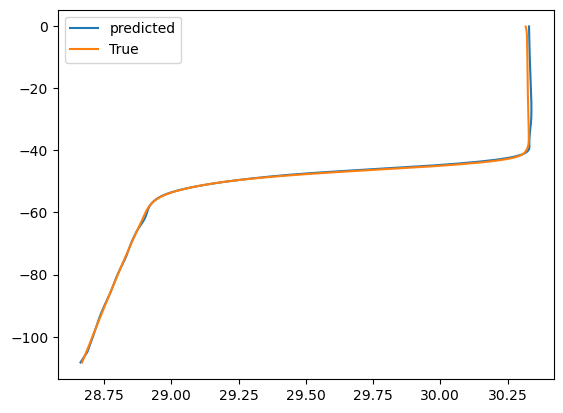

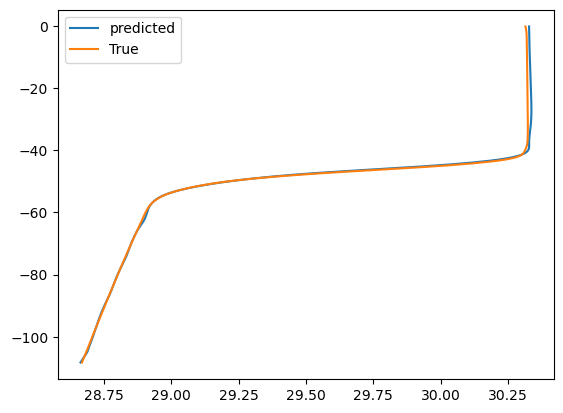

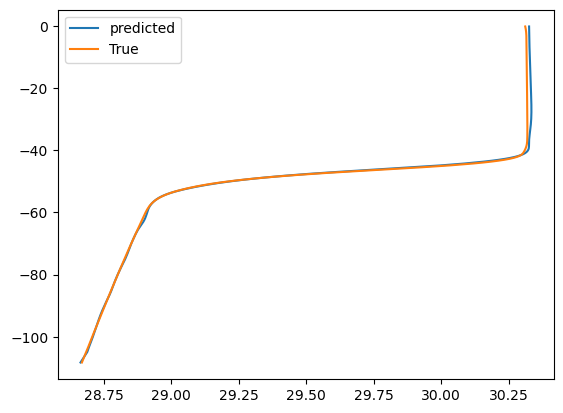

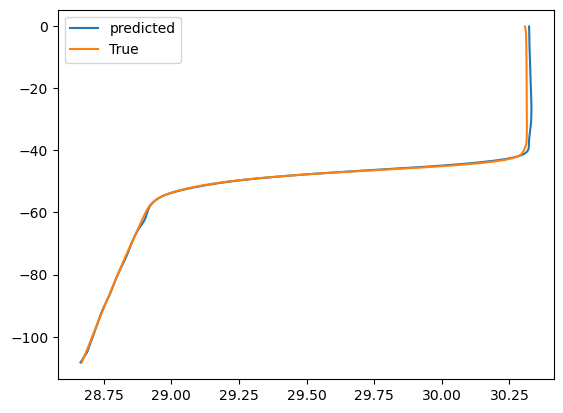

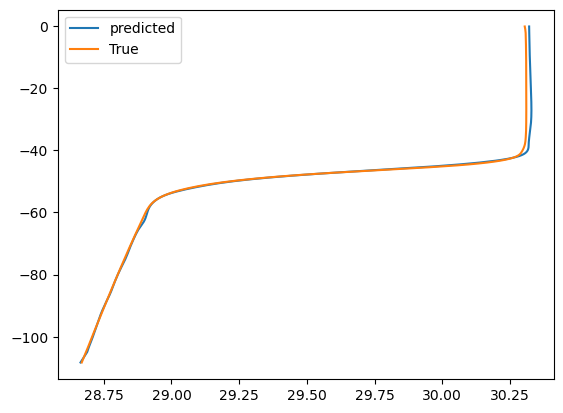

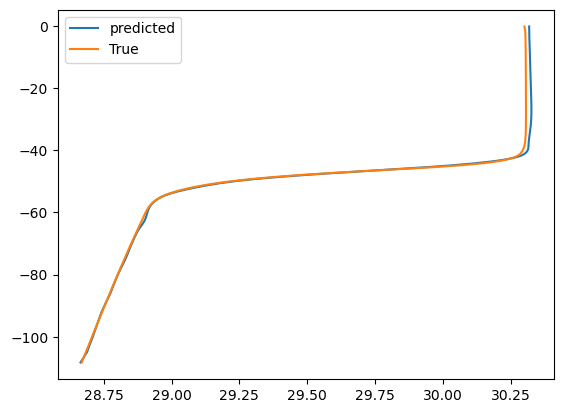

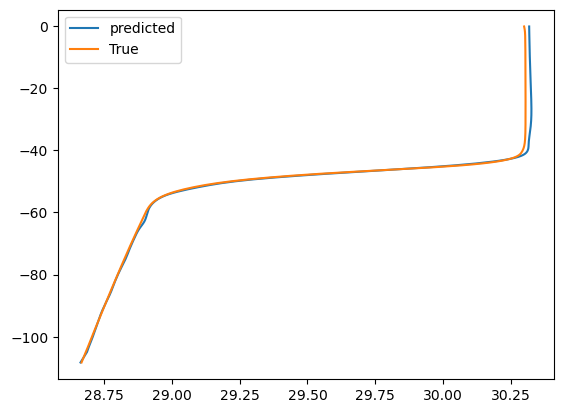

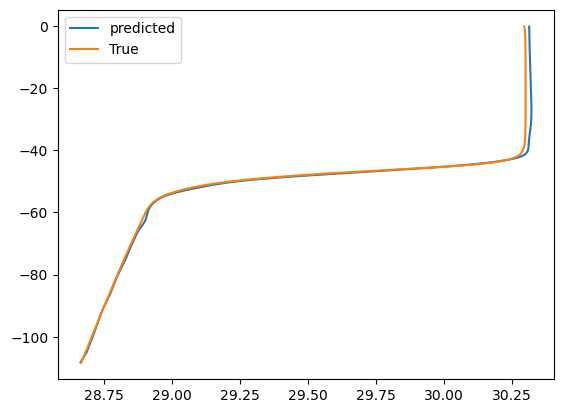

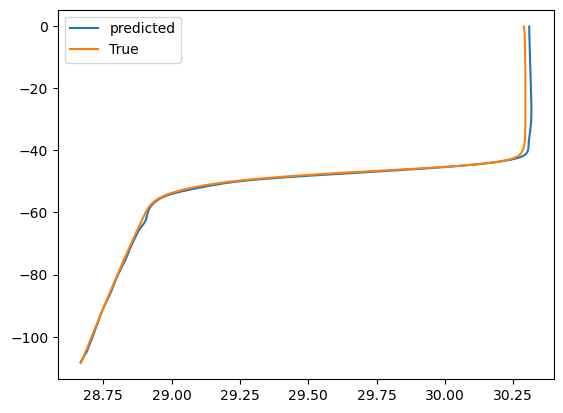

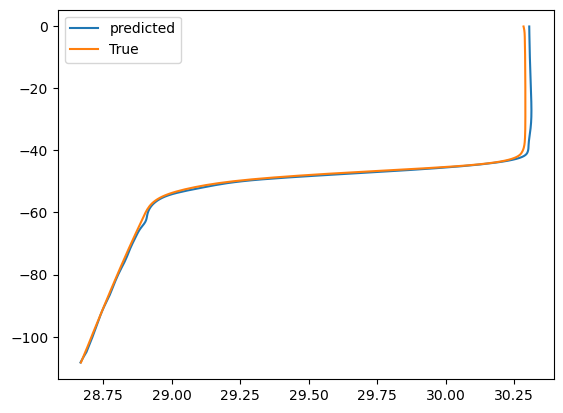

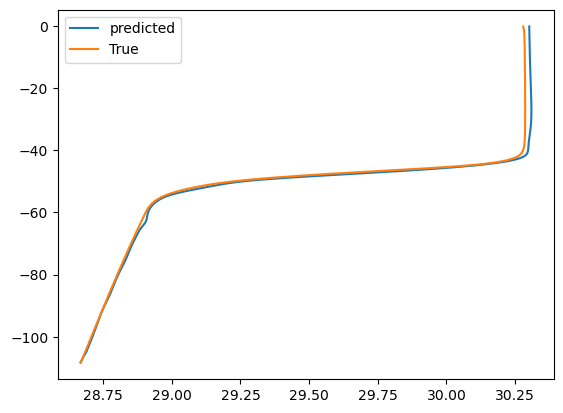

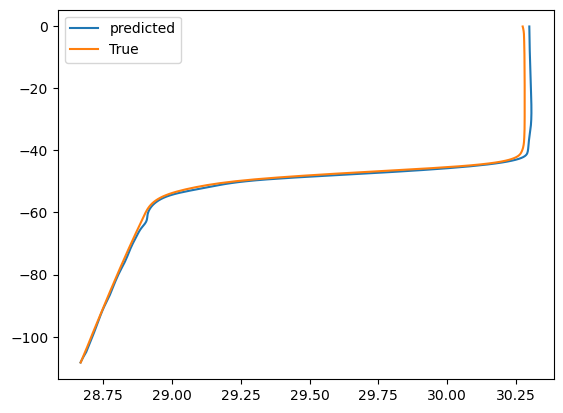

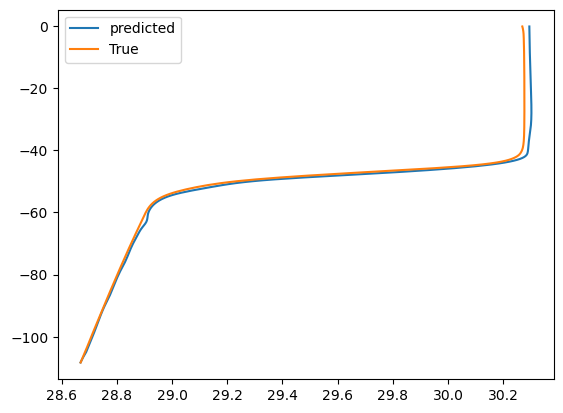

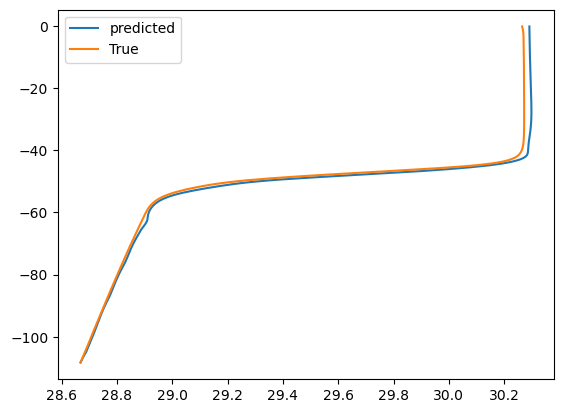

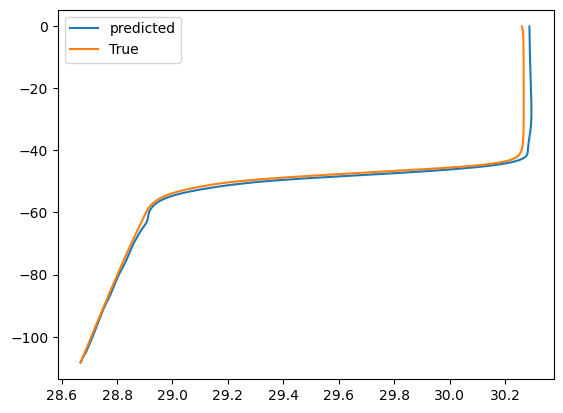

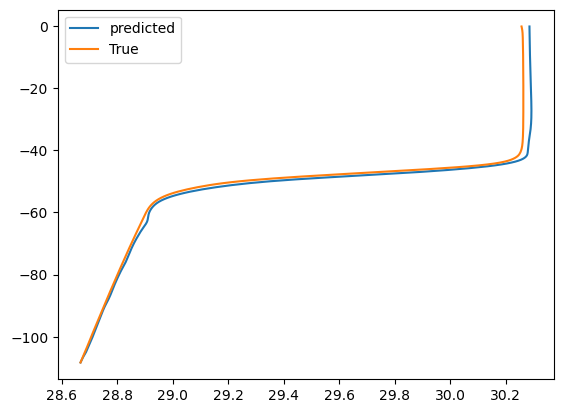

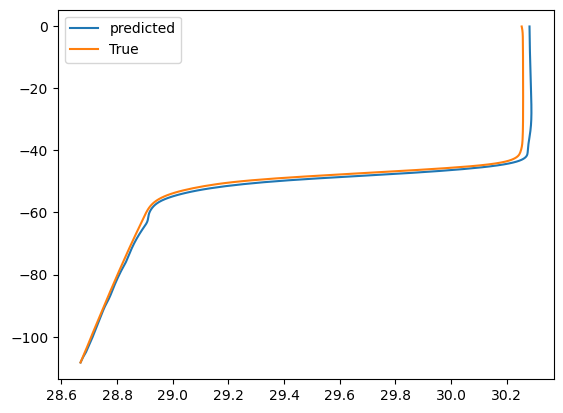

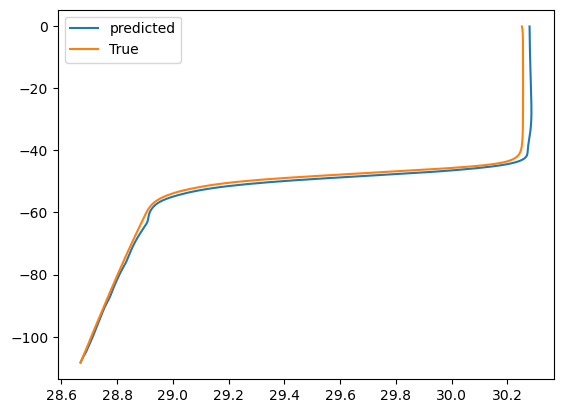

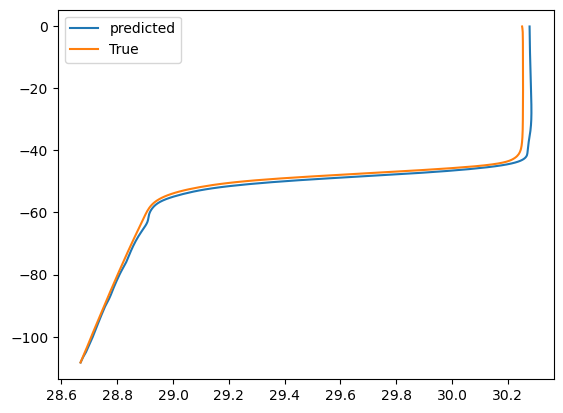

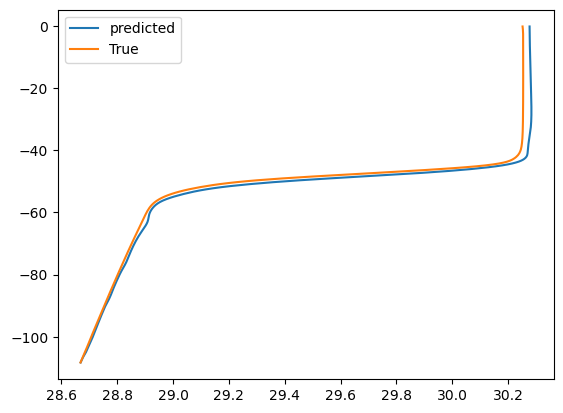

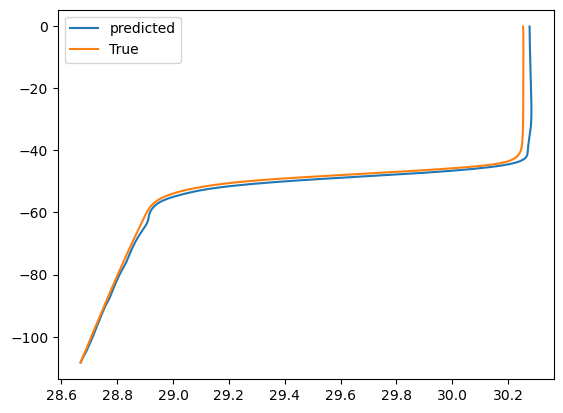

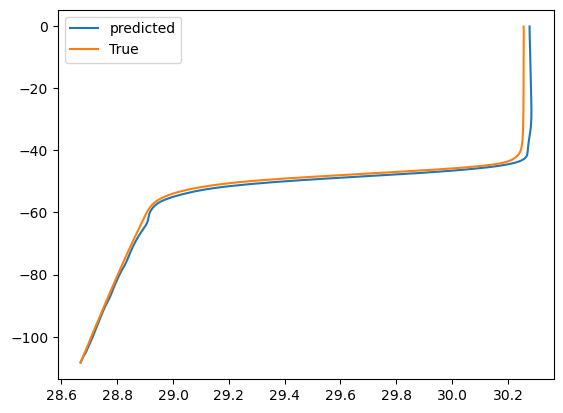

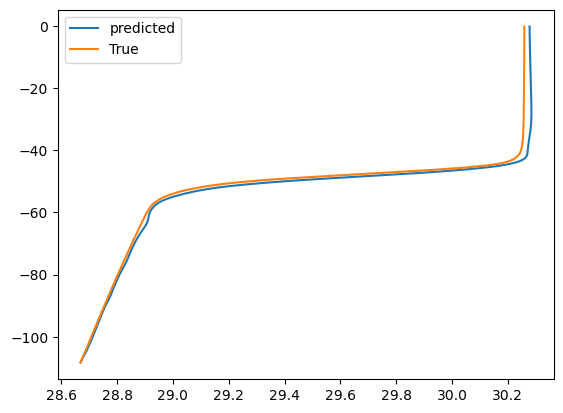

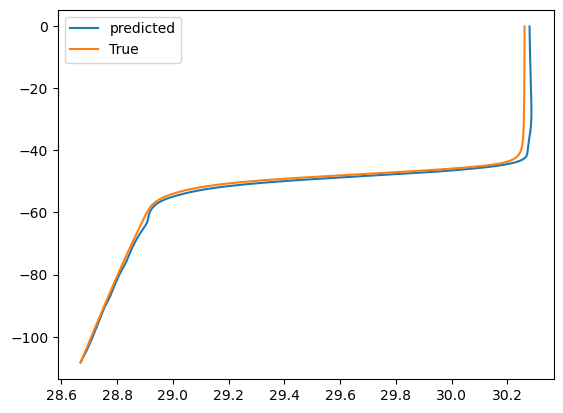

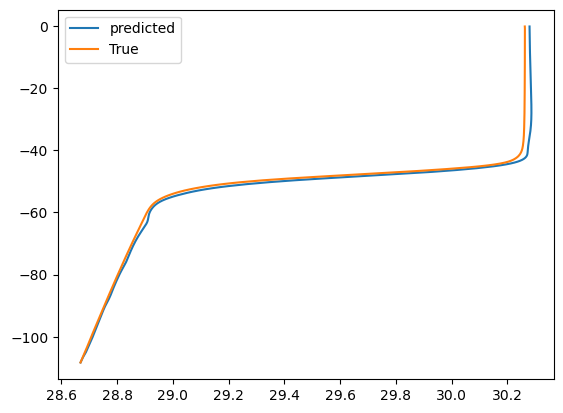

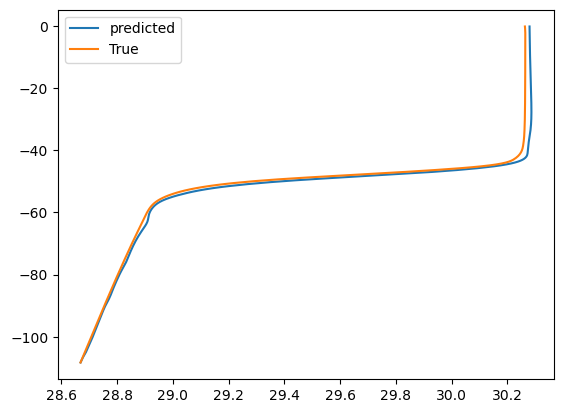

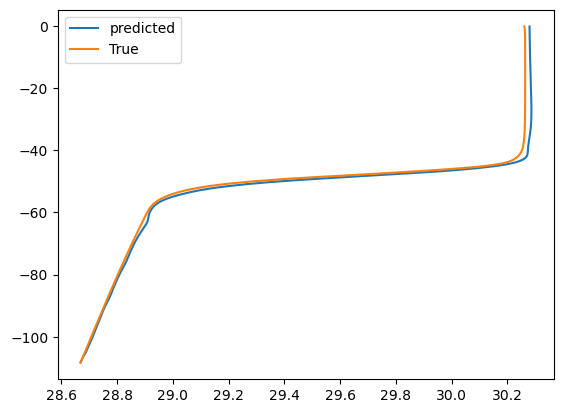

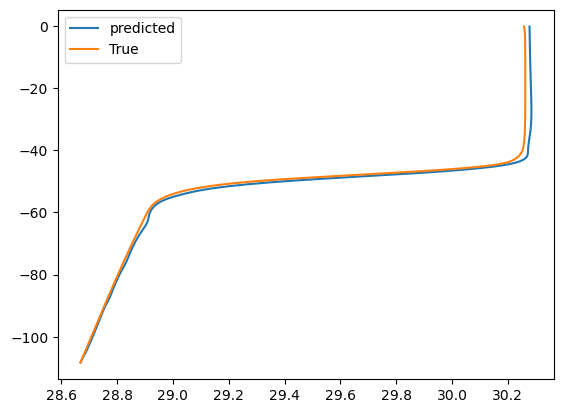

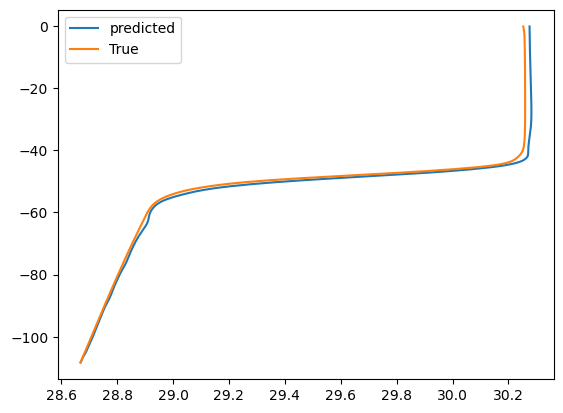

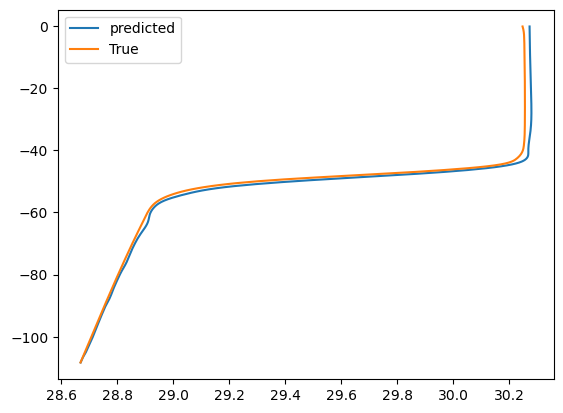

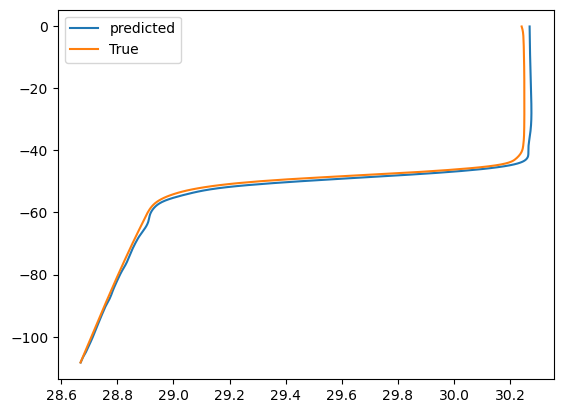

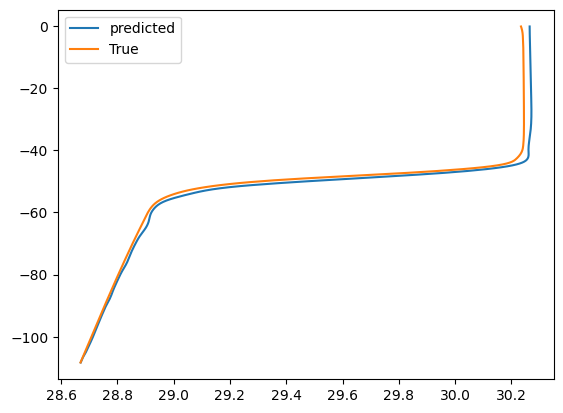

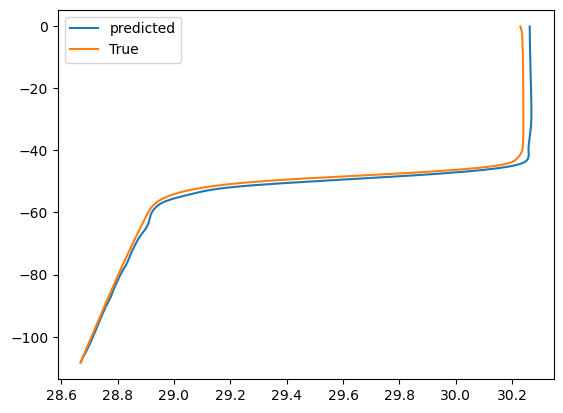

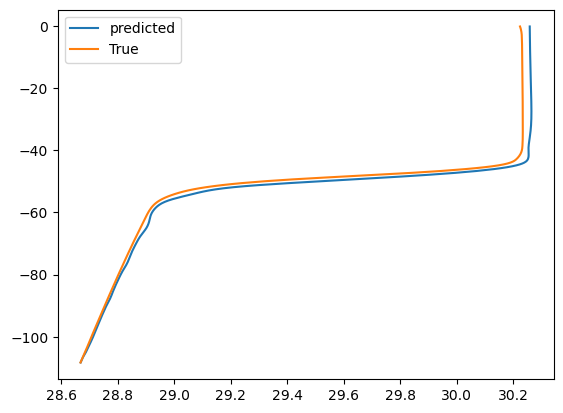

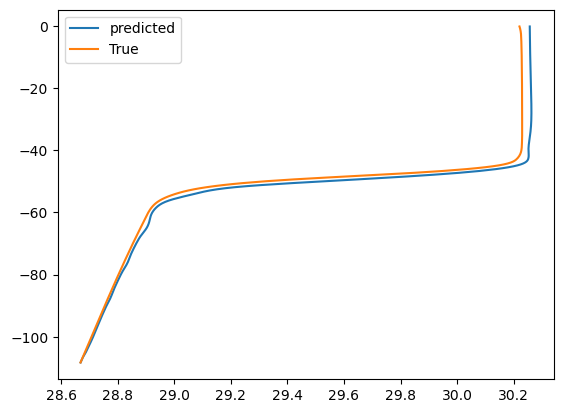

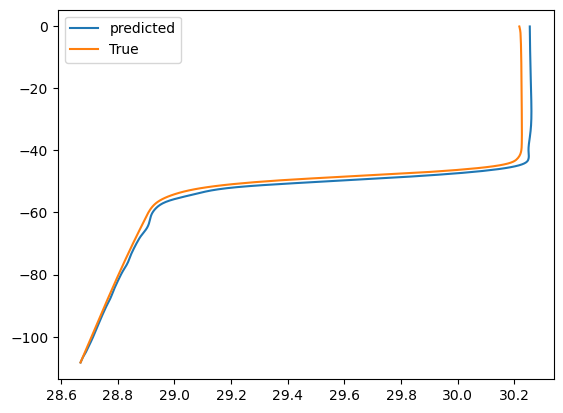

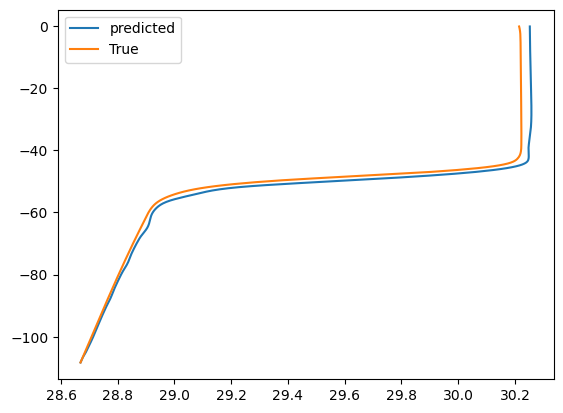

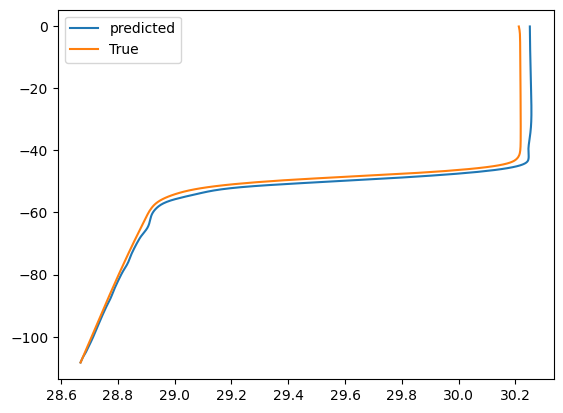

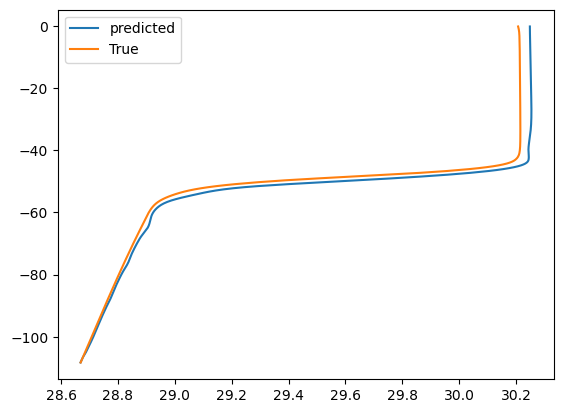

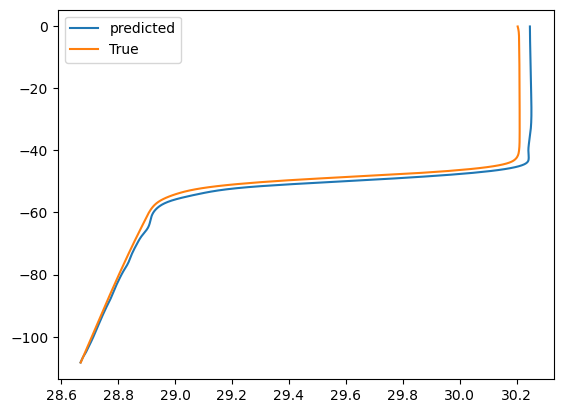

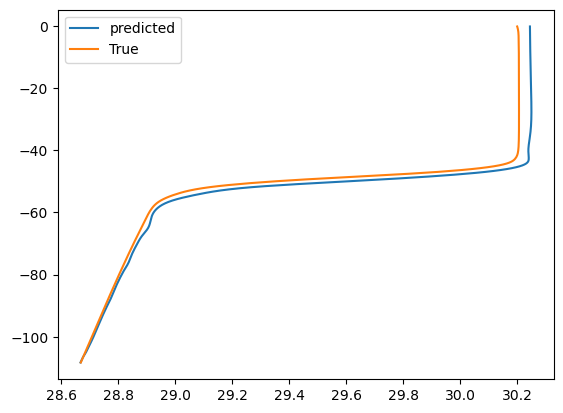

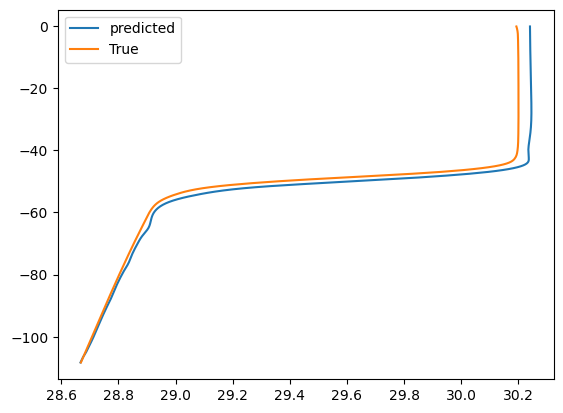

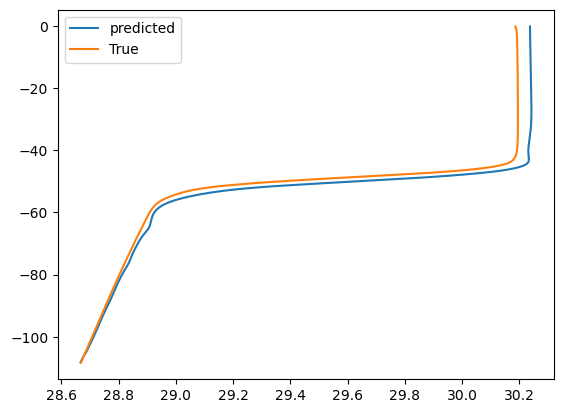

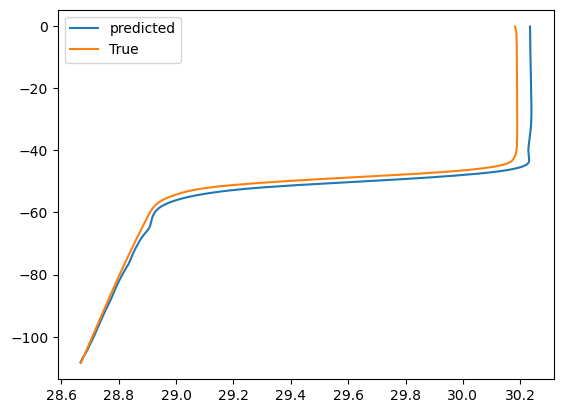

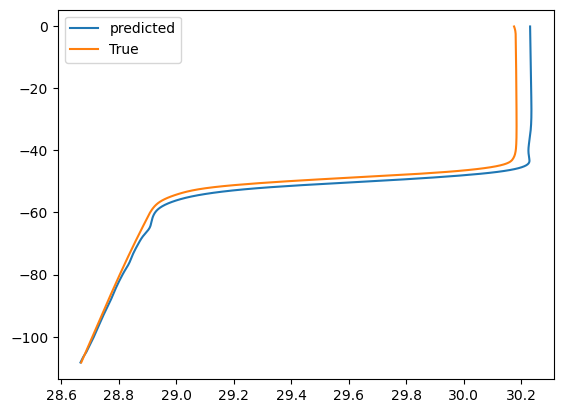

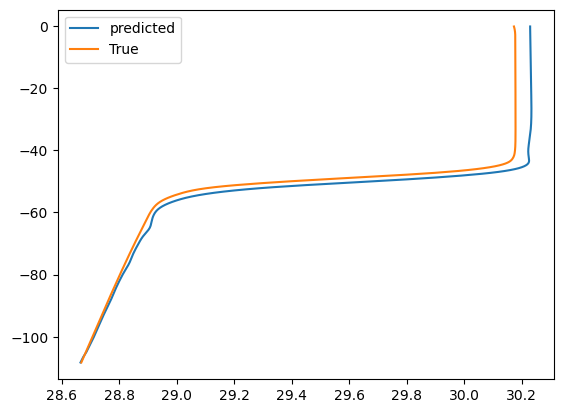

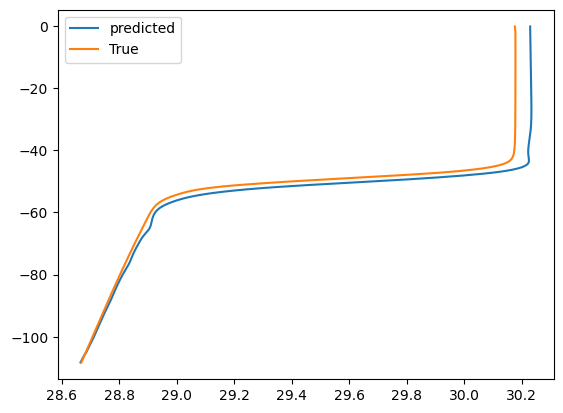

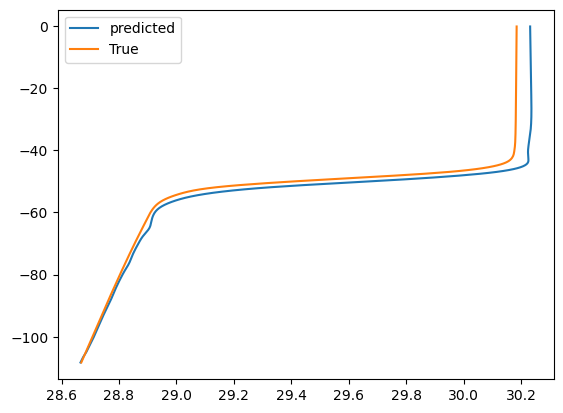

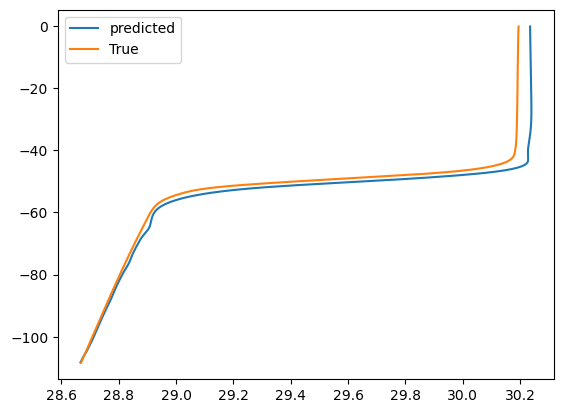

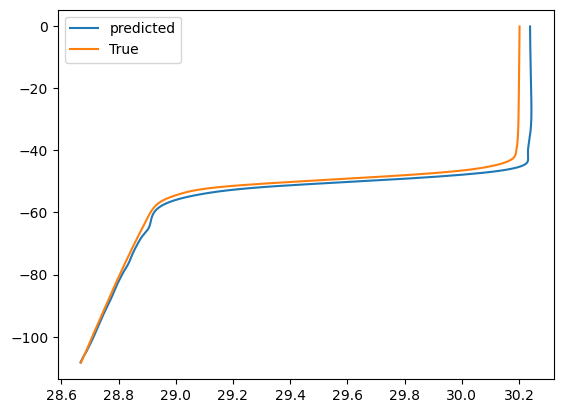

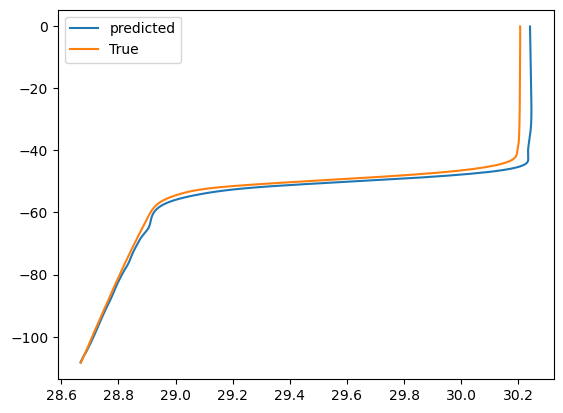

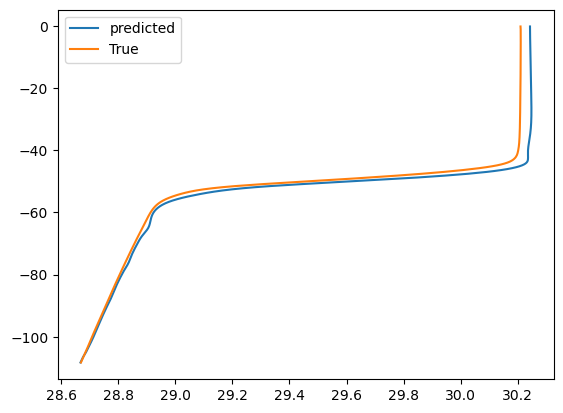

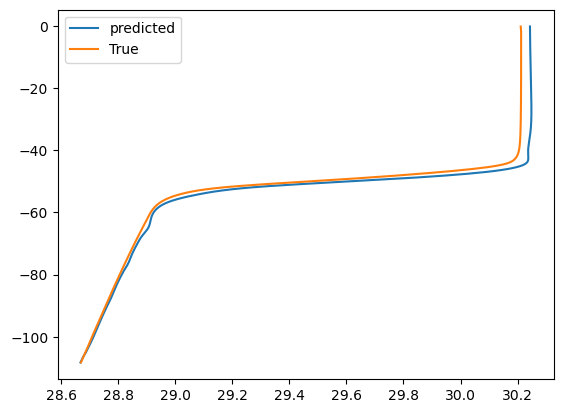

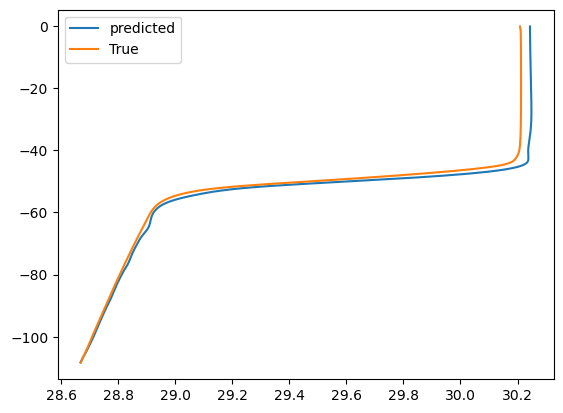

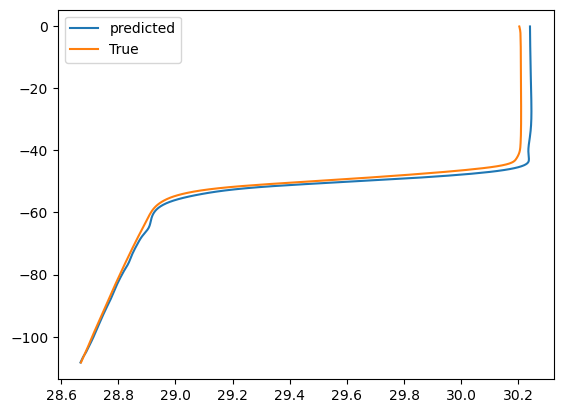

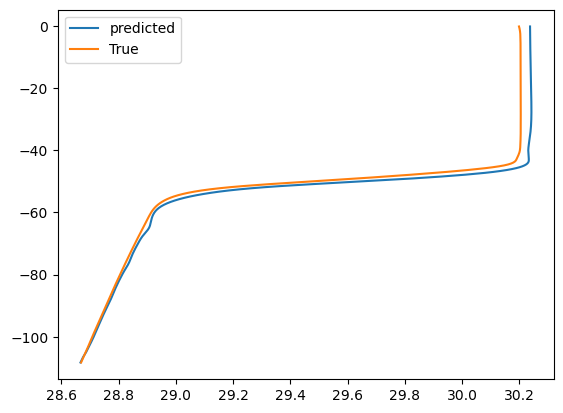

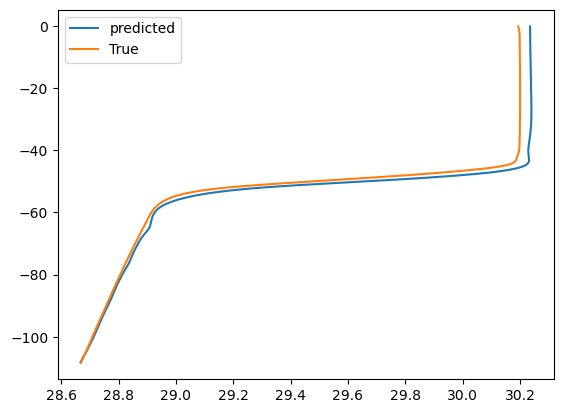

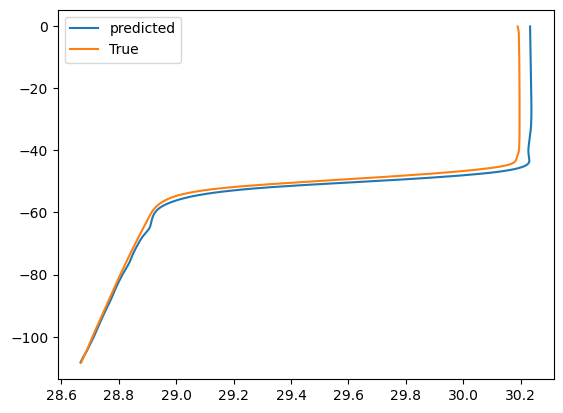

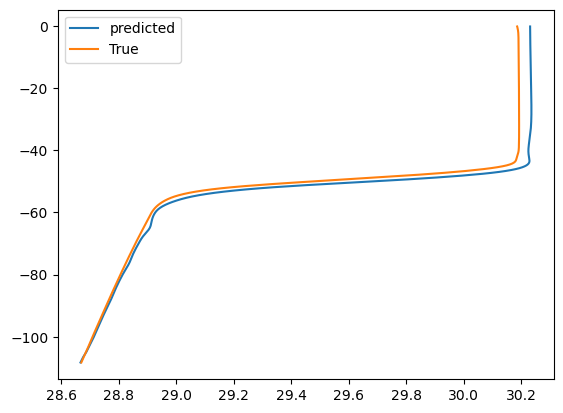

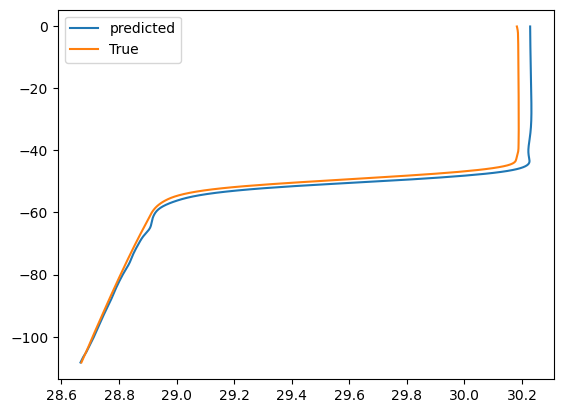

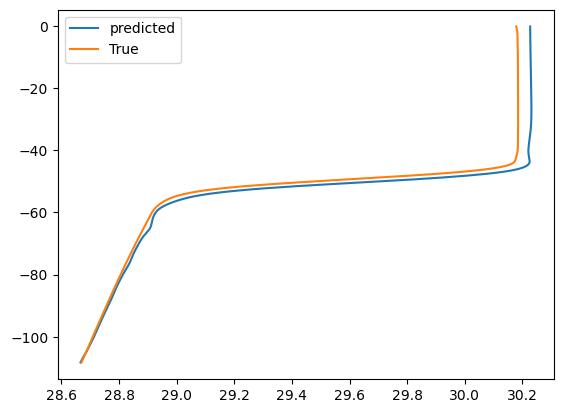

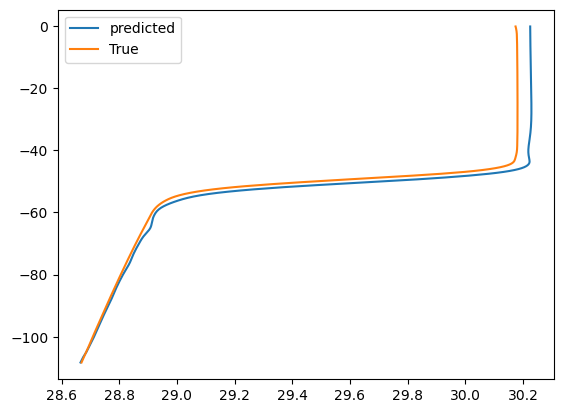

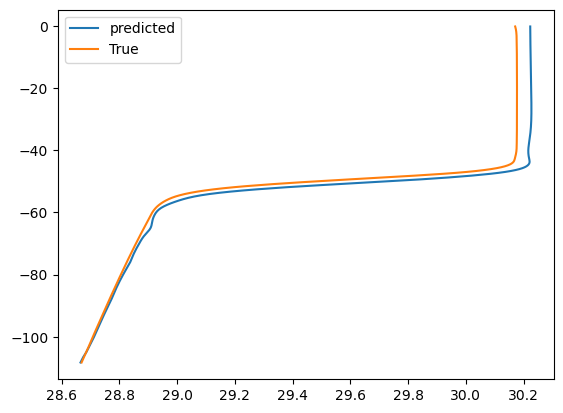

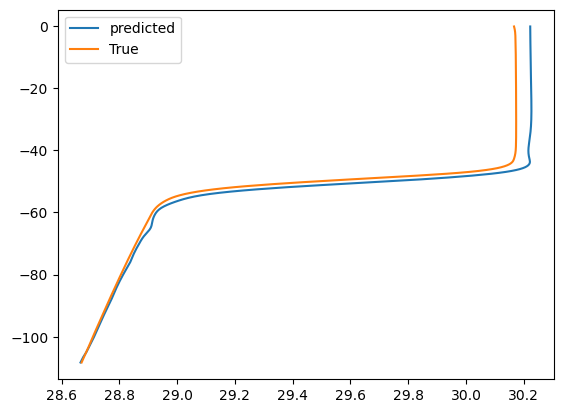

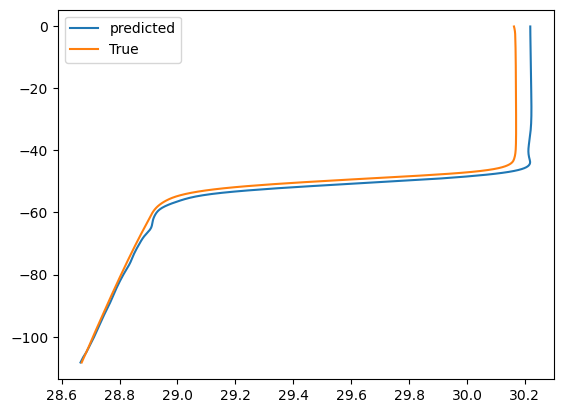

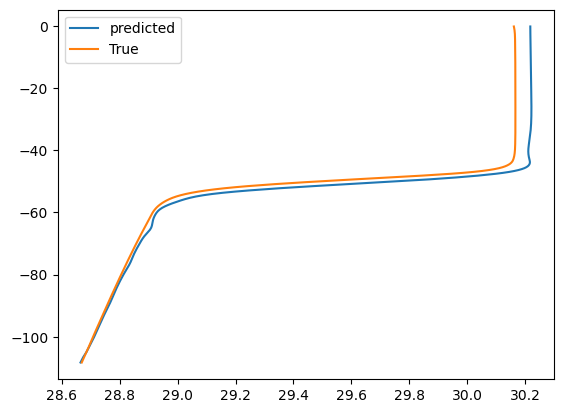

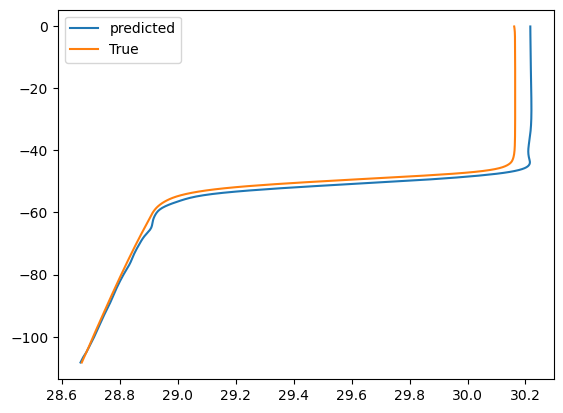

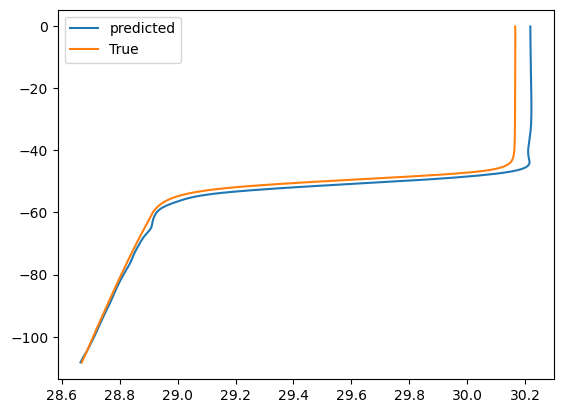

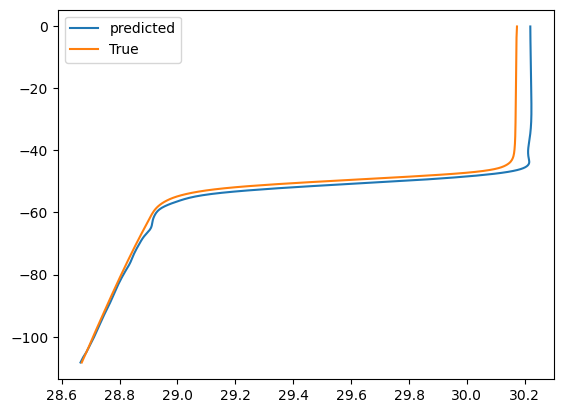

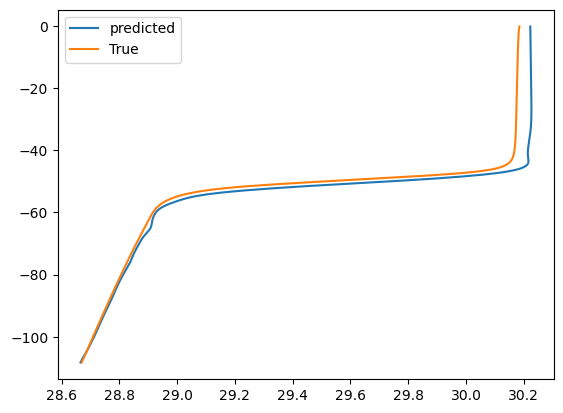

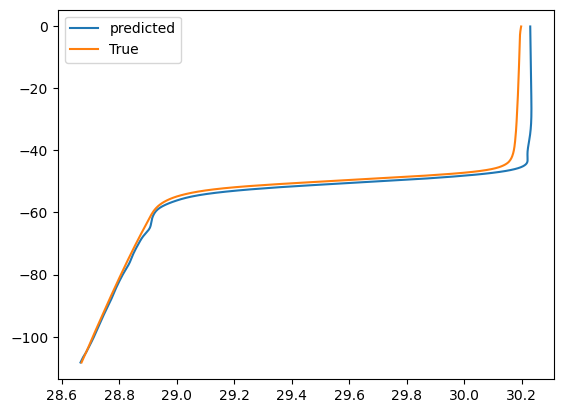

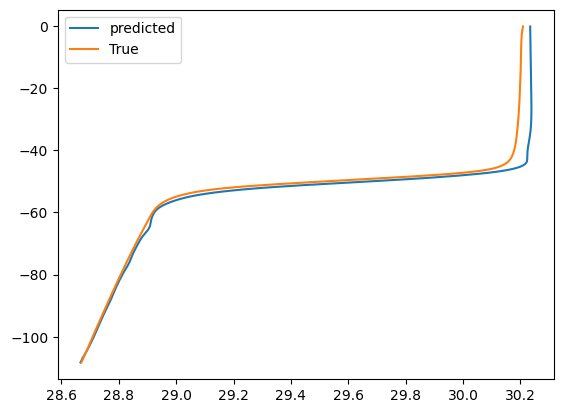

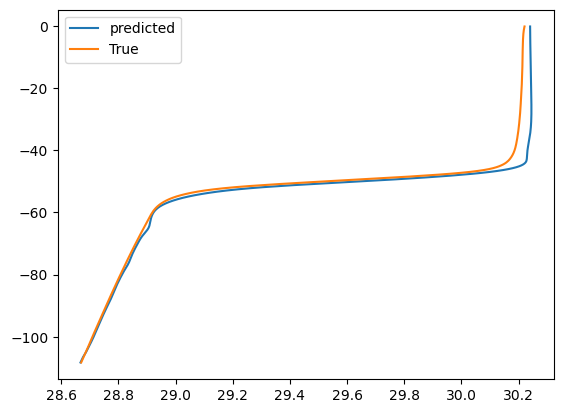

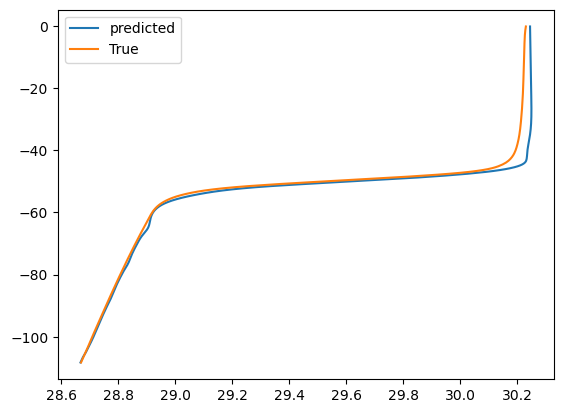

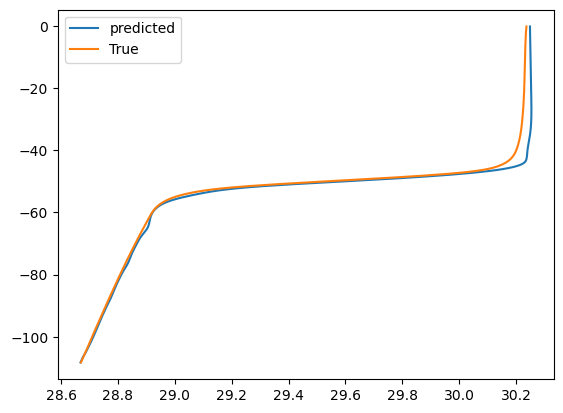

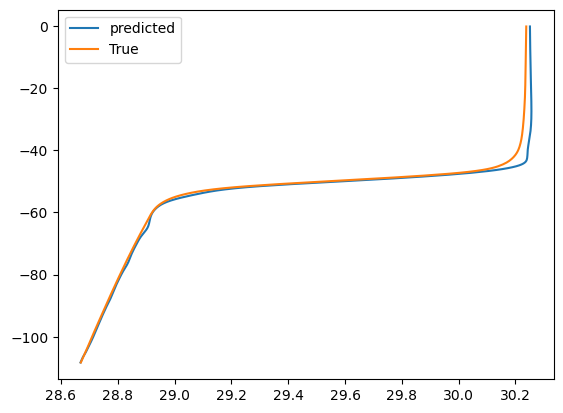

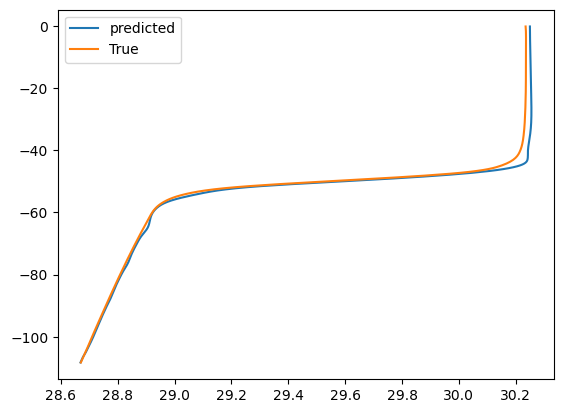

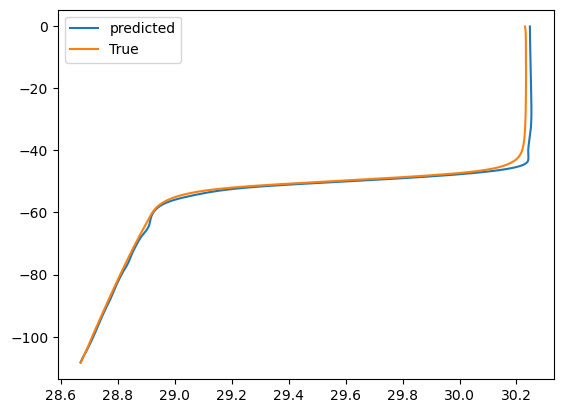

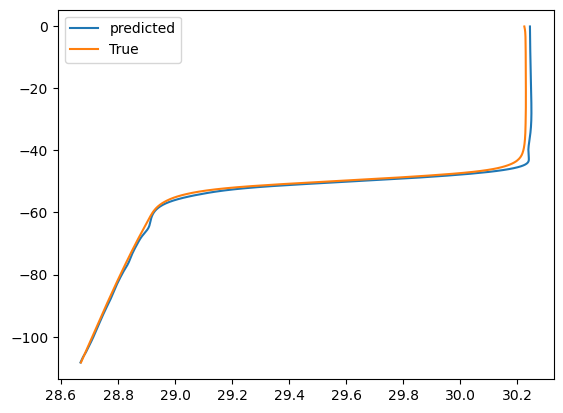

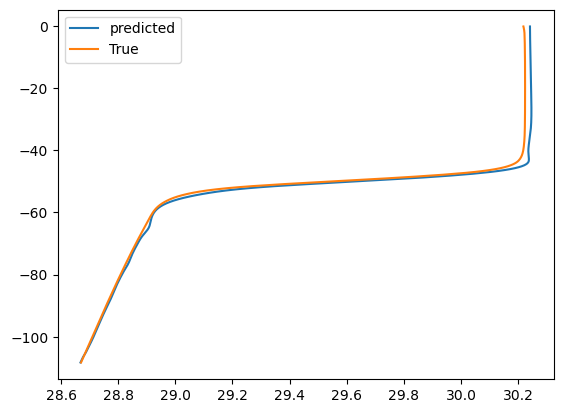

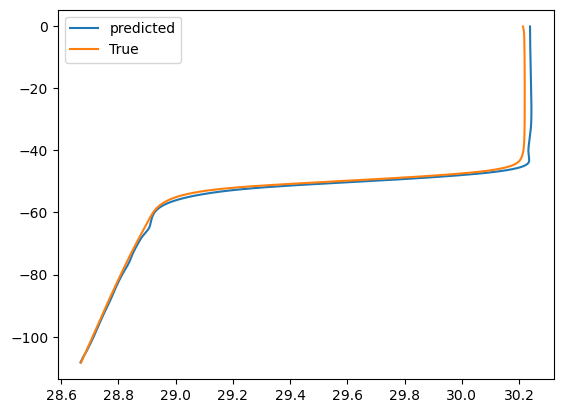

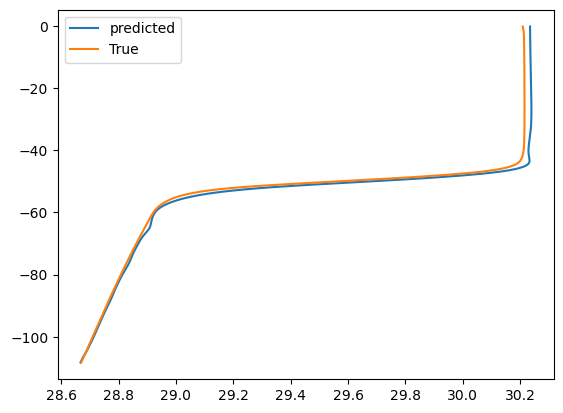

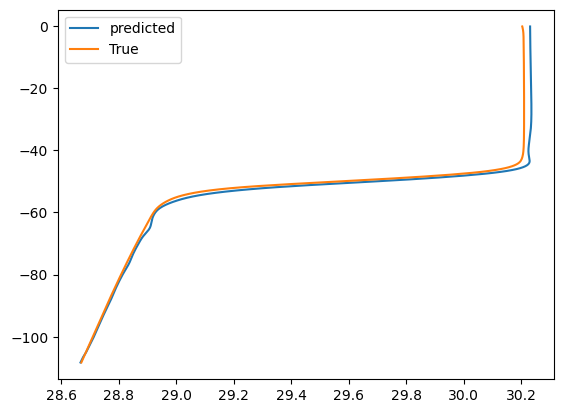

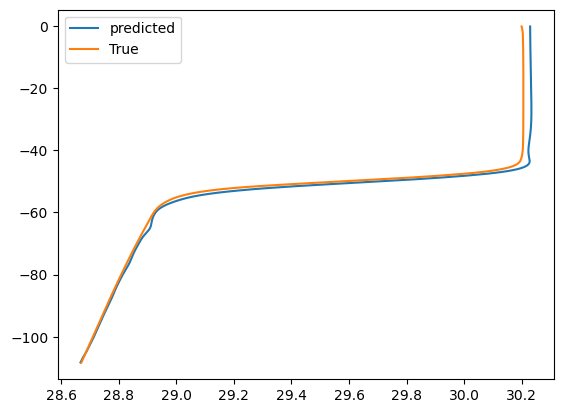

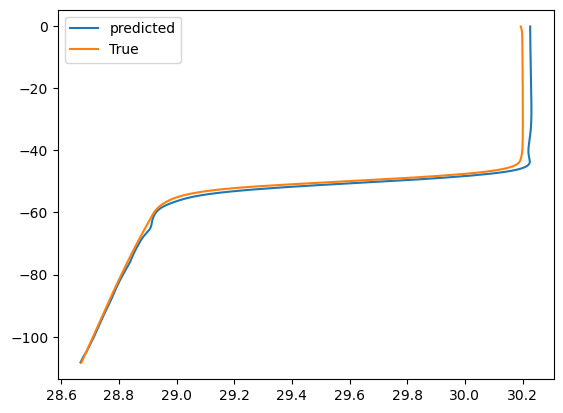

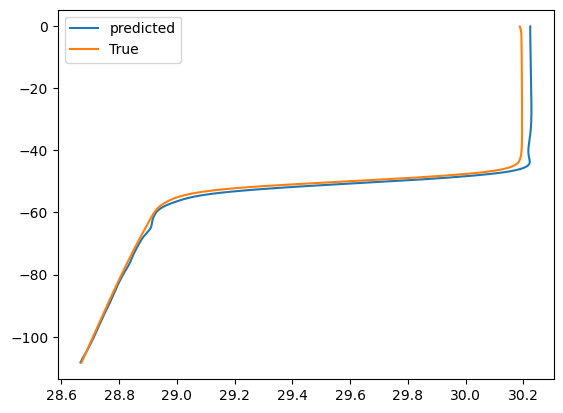

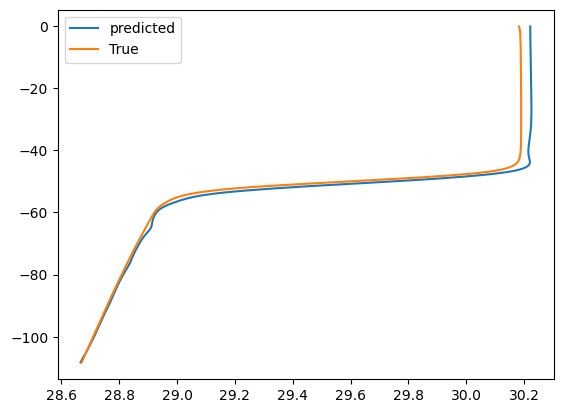

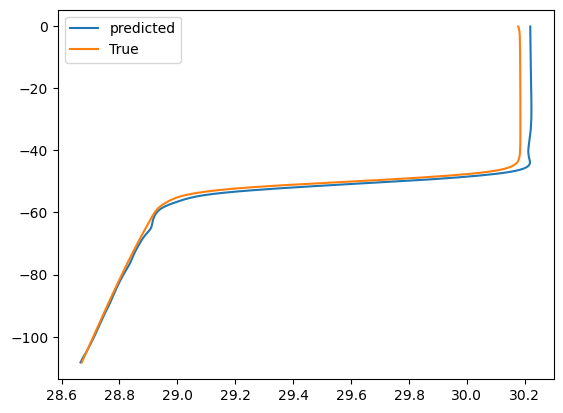

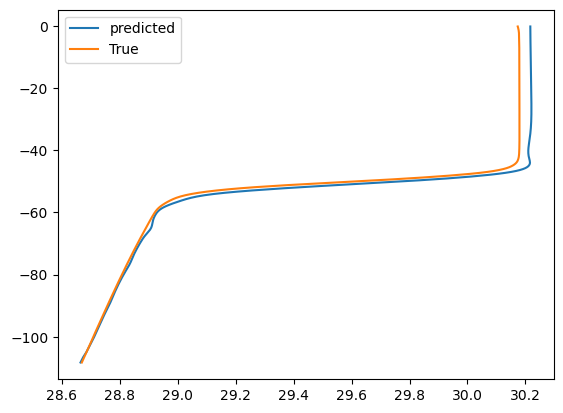

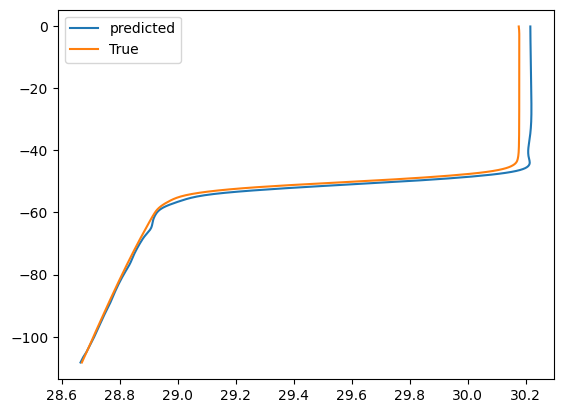

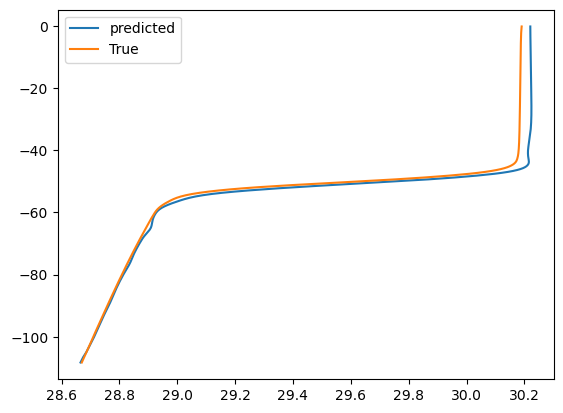

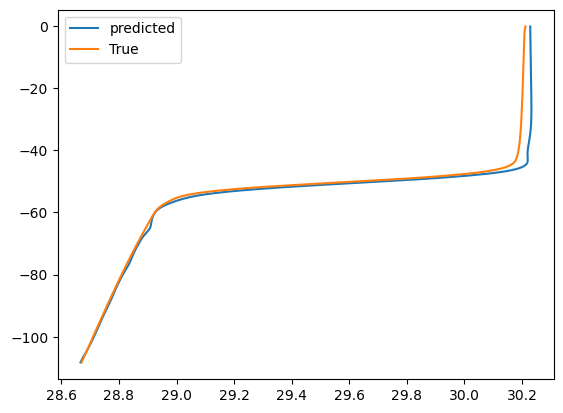

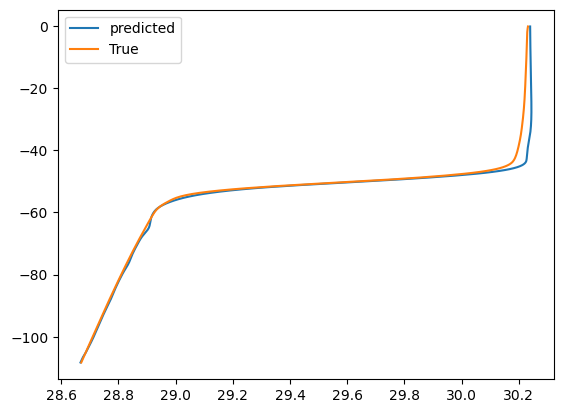

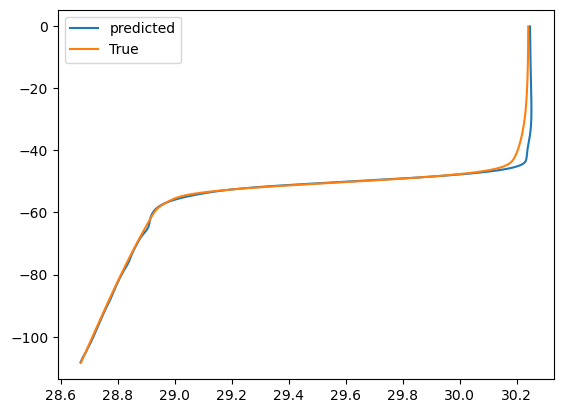

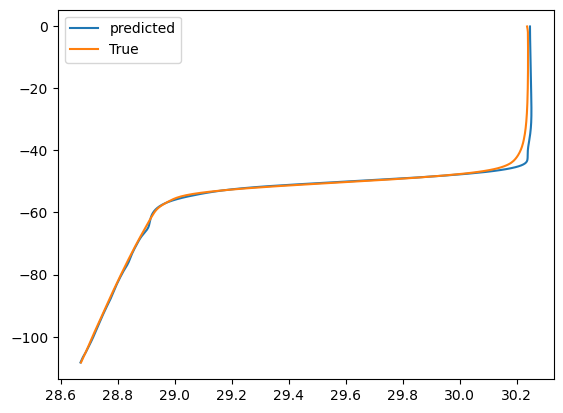

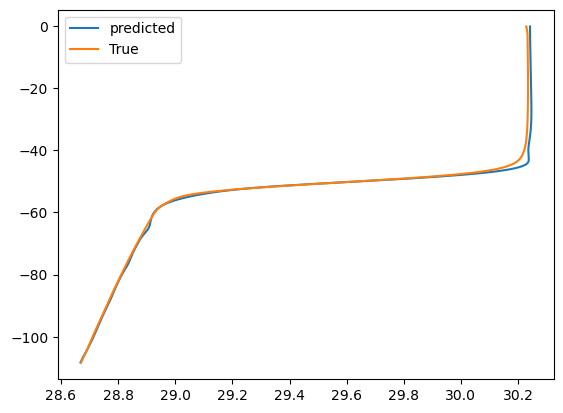

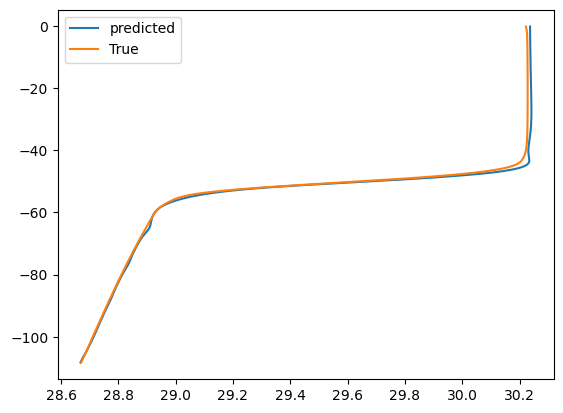

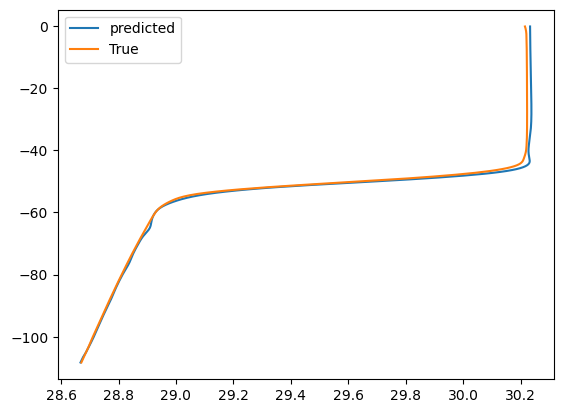

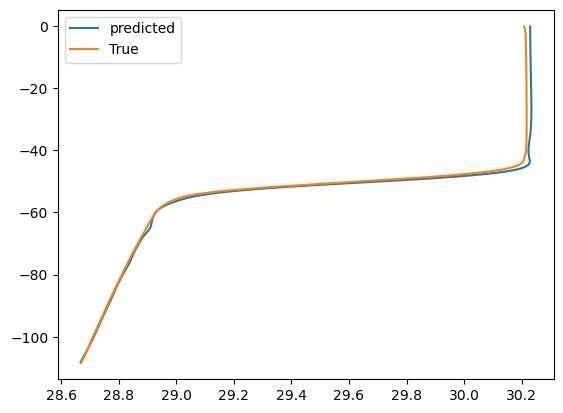

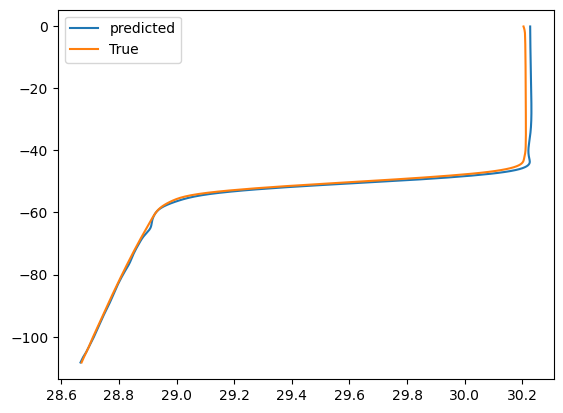

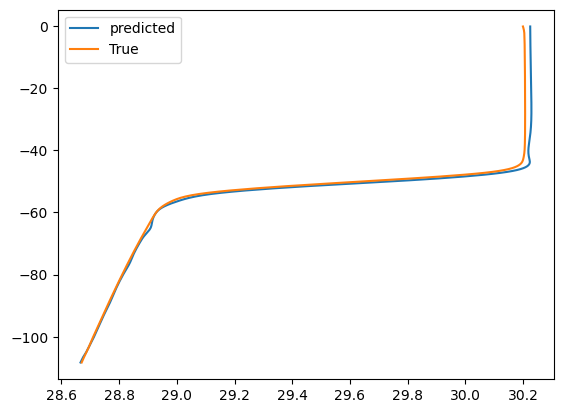

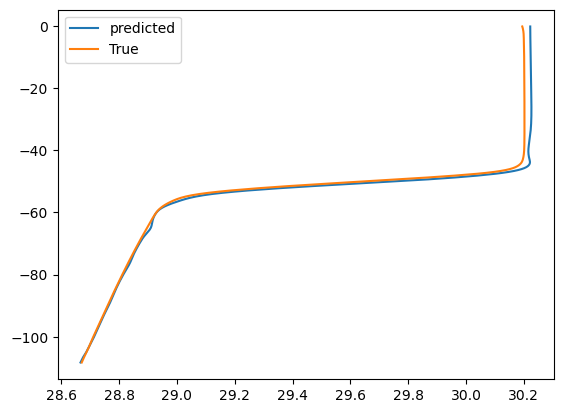

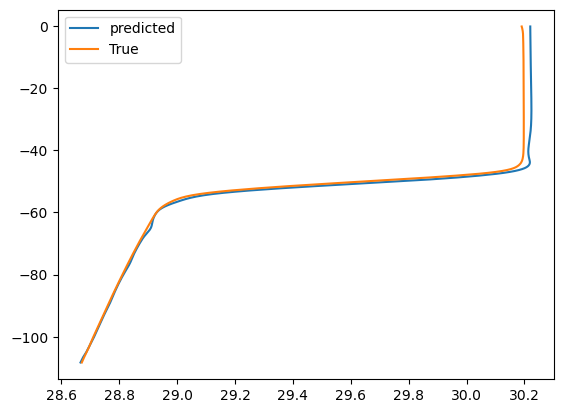

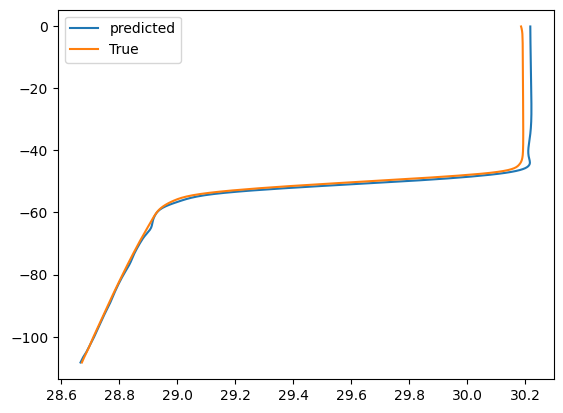

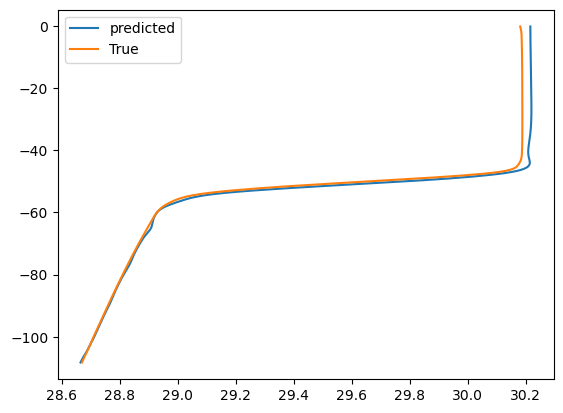

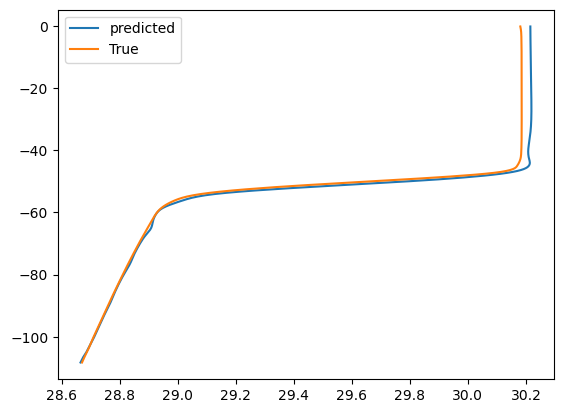

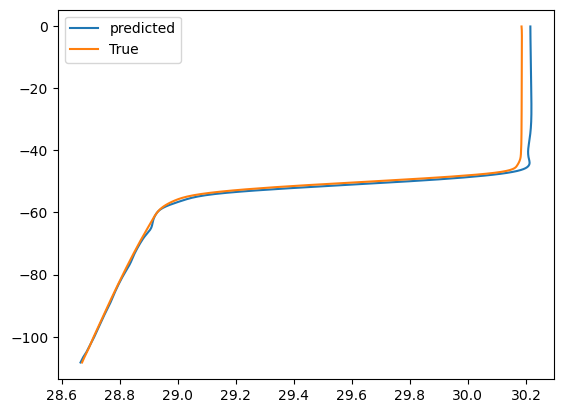

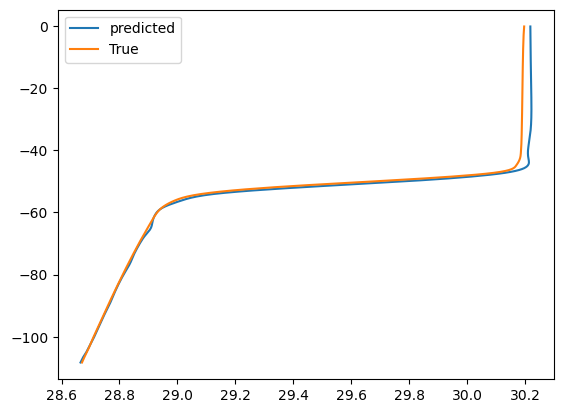

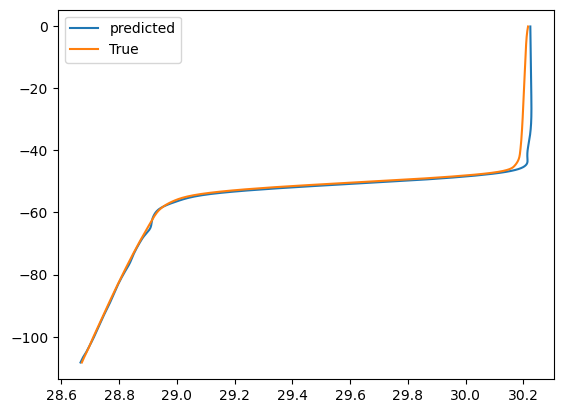

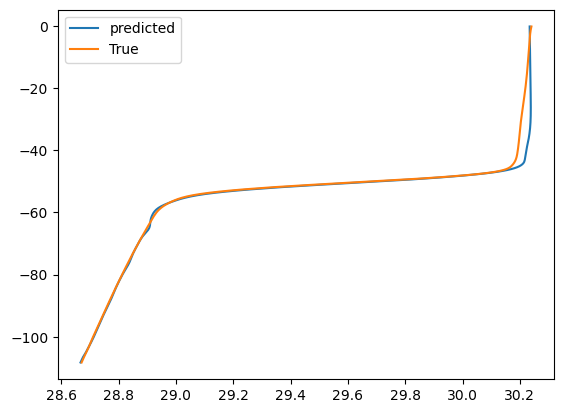

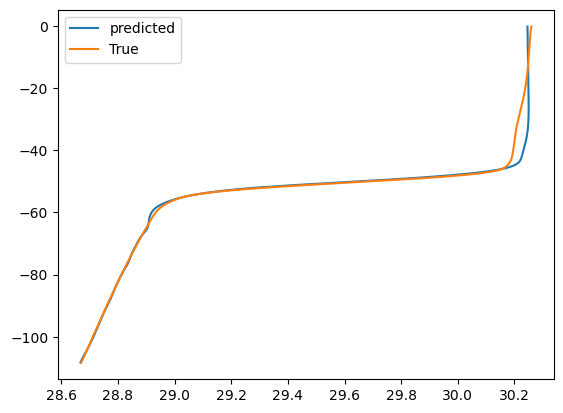

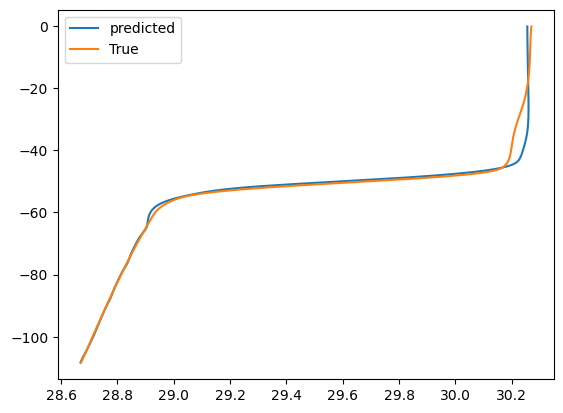

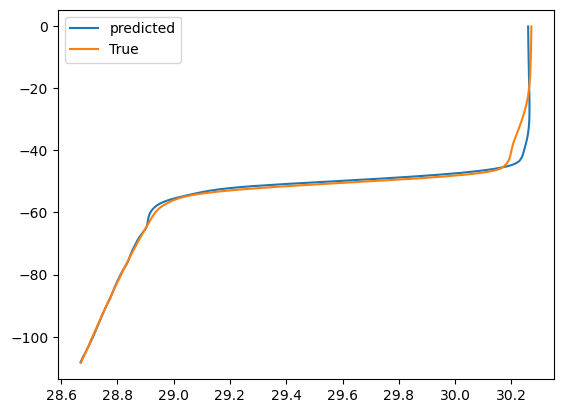

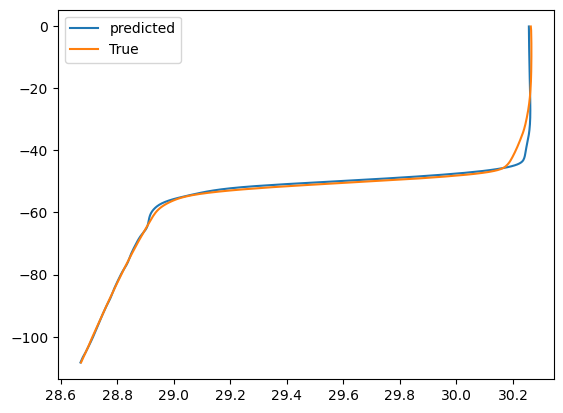

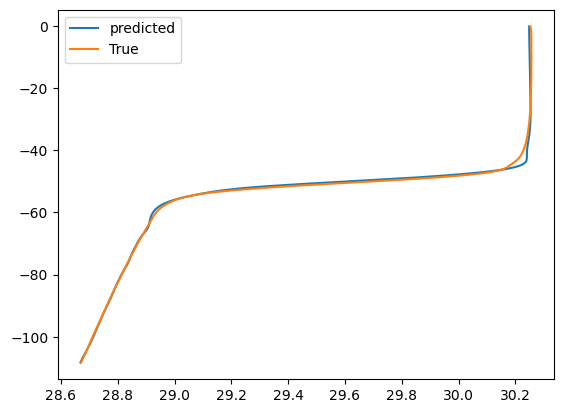

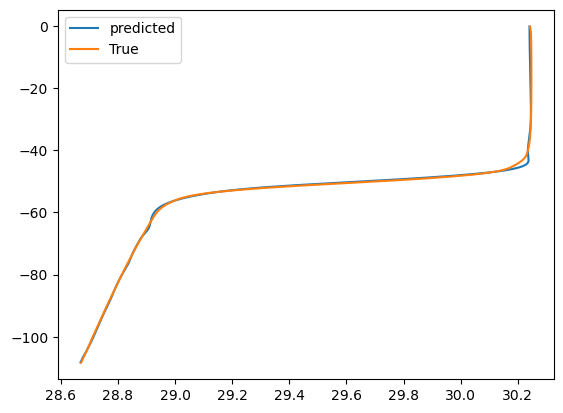

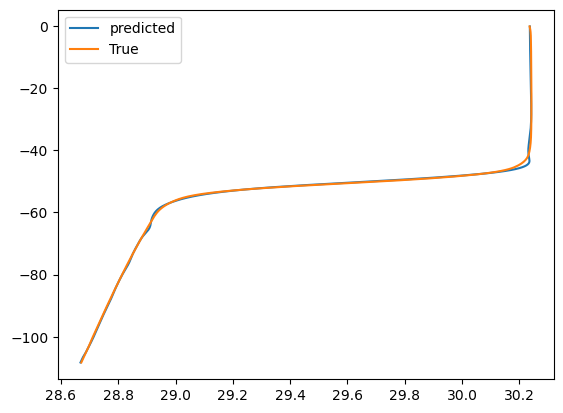

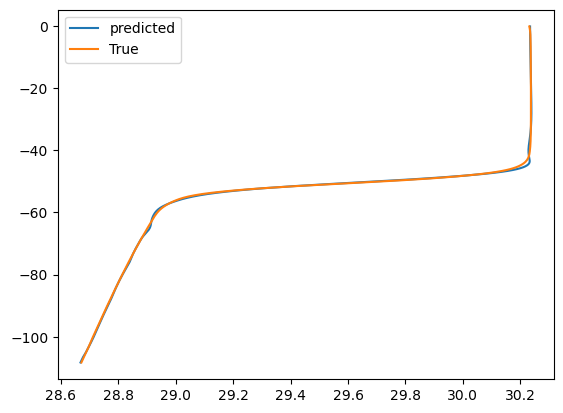

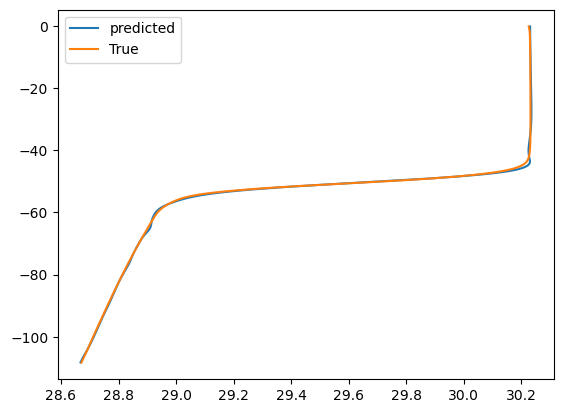

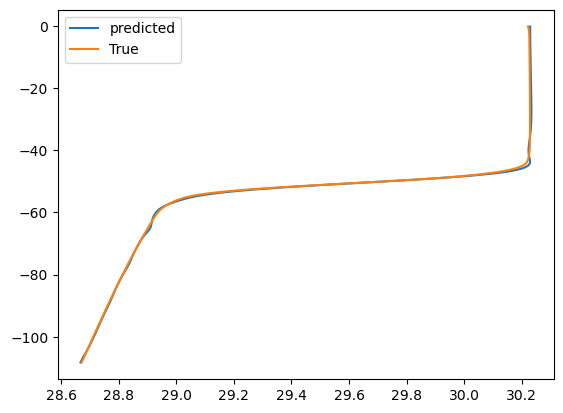

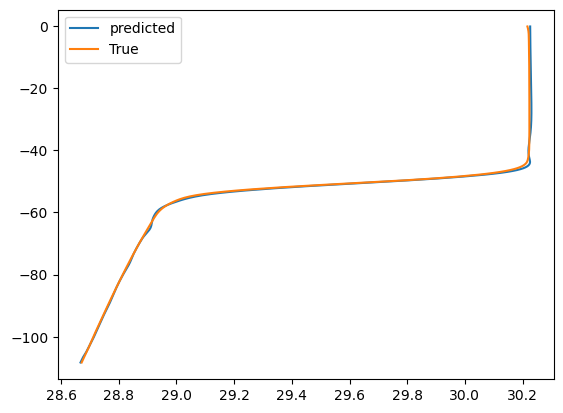

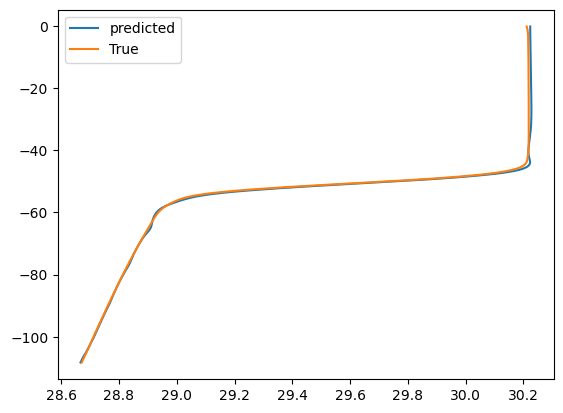

In [29]:
for i in range(Testx_tr.shape[0]):
    if i%25==0:
        plt.figure(i)
        plt.plot(In.inv_transform(x_rec1[i:i+1,:,:].detach().numpy())[:,:,0].T,ZZ.T,label='predicted')
        plt.plot(In.inv_transform(Testx_tr1[i:i+1,:,:])[:,:,0].T,ZZ.T,label='True')
        plt.legend()
    j=j+1

In [30]:
print(hours.shape)

(8501,)


'print(In.inv_transform(x_rec.detach().numpy())[:,-1,0])\nprint((x)[:,-1,0])'

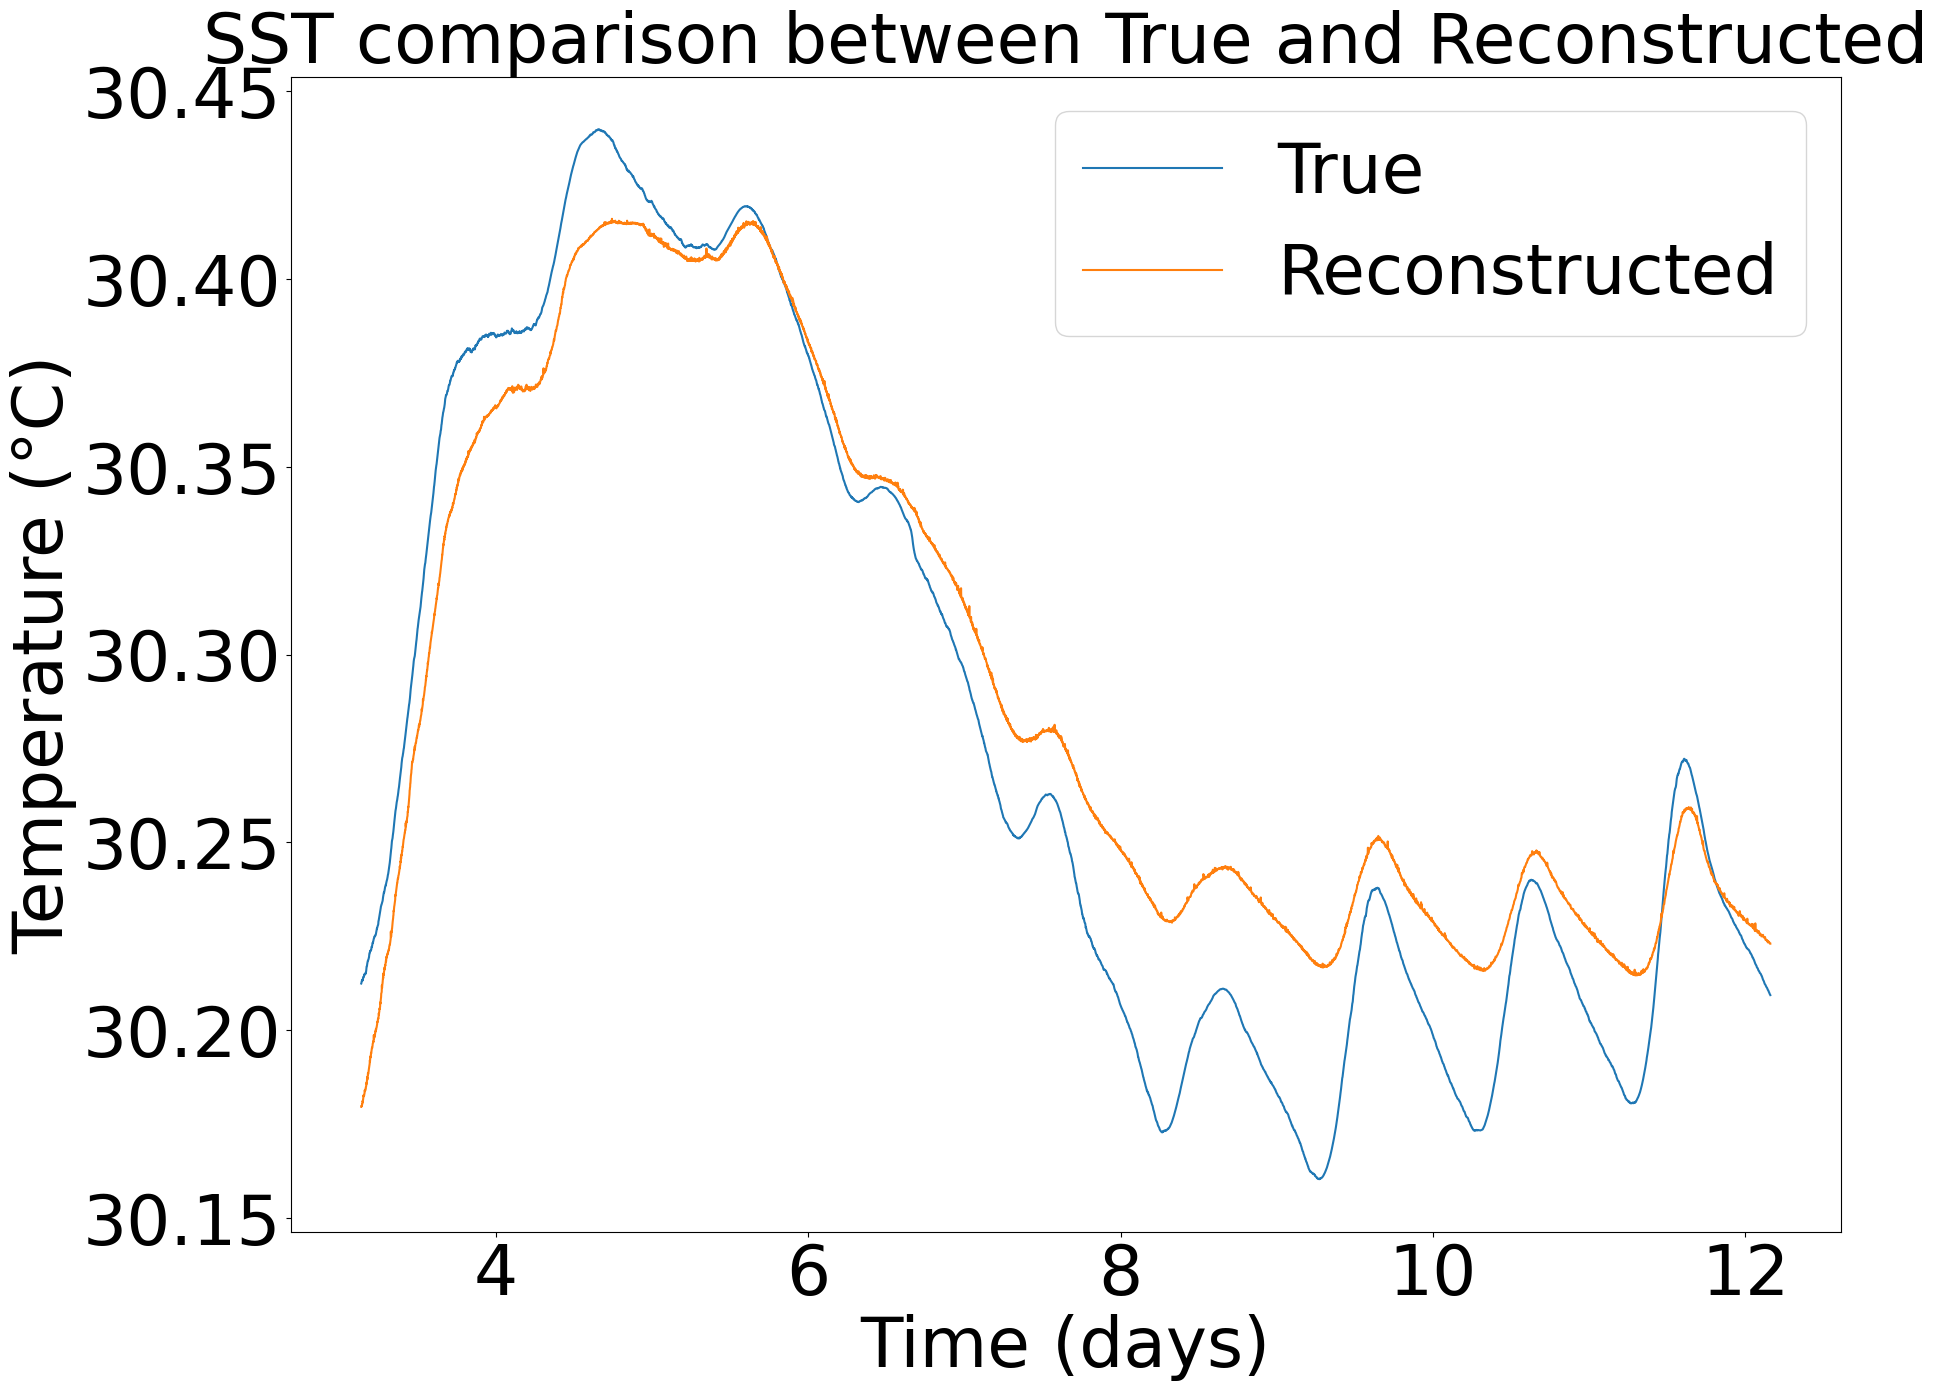

In [83]:
fig,ax= plt.subplots(1,1,figsize=(20,15))
t=np.linspace(7000,8501,1501,endpoint=False)
ax.plot(hours[1500:endtime]/24,In.inv_transform(Testx_tr1)[time_step:,-1,0],label='True')
ax.plot(hours[1500:endtime]/24,In.inv_transform(x_rec1.detach().numpy())[time_step:,-1,0],label='Reconstructed')

ax.set_xlabel('Time (days)',fontsize=50)
ax.set_ylabel('Temperature (\xb0C)',fontsize=50)
ax.set_title('SST comparison between True and Reconstructed',fontsize=50)
ax.legend(fontsize=50)
ax.tick_params(axis='both', labelsize=50)
'''ax[1].plot(In.inv_transform(x_rec.detach().numpy())[:,-1,1],label='Predicted')
ax[1].plot(In.inv_transform(Testx_tr)[:,-1,1],label='True')
ax[1].legend()'''

'''print(In.inv_transform(x_rec.detach().numpy())[:,-1,0])
print((x)[:,-1,0])'''

In [84]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(In.inv_transform(Testx_tr1)[time_step:,-1,0],In.inv_transform(x_rec1.detach().numpy())[time_step:,-1,0])

0.000699371959797325

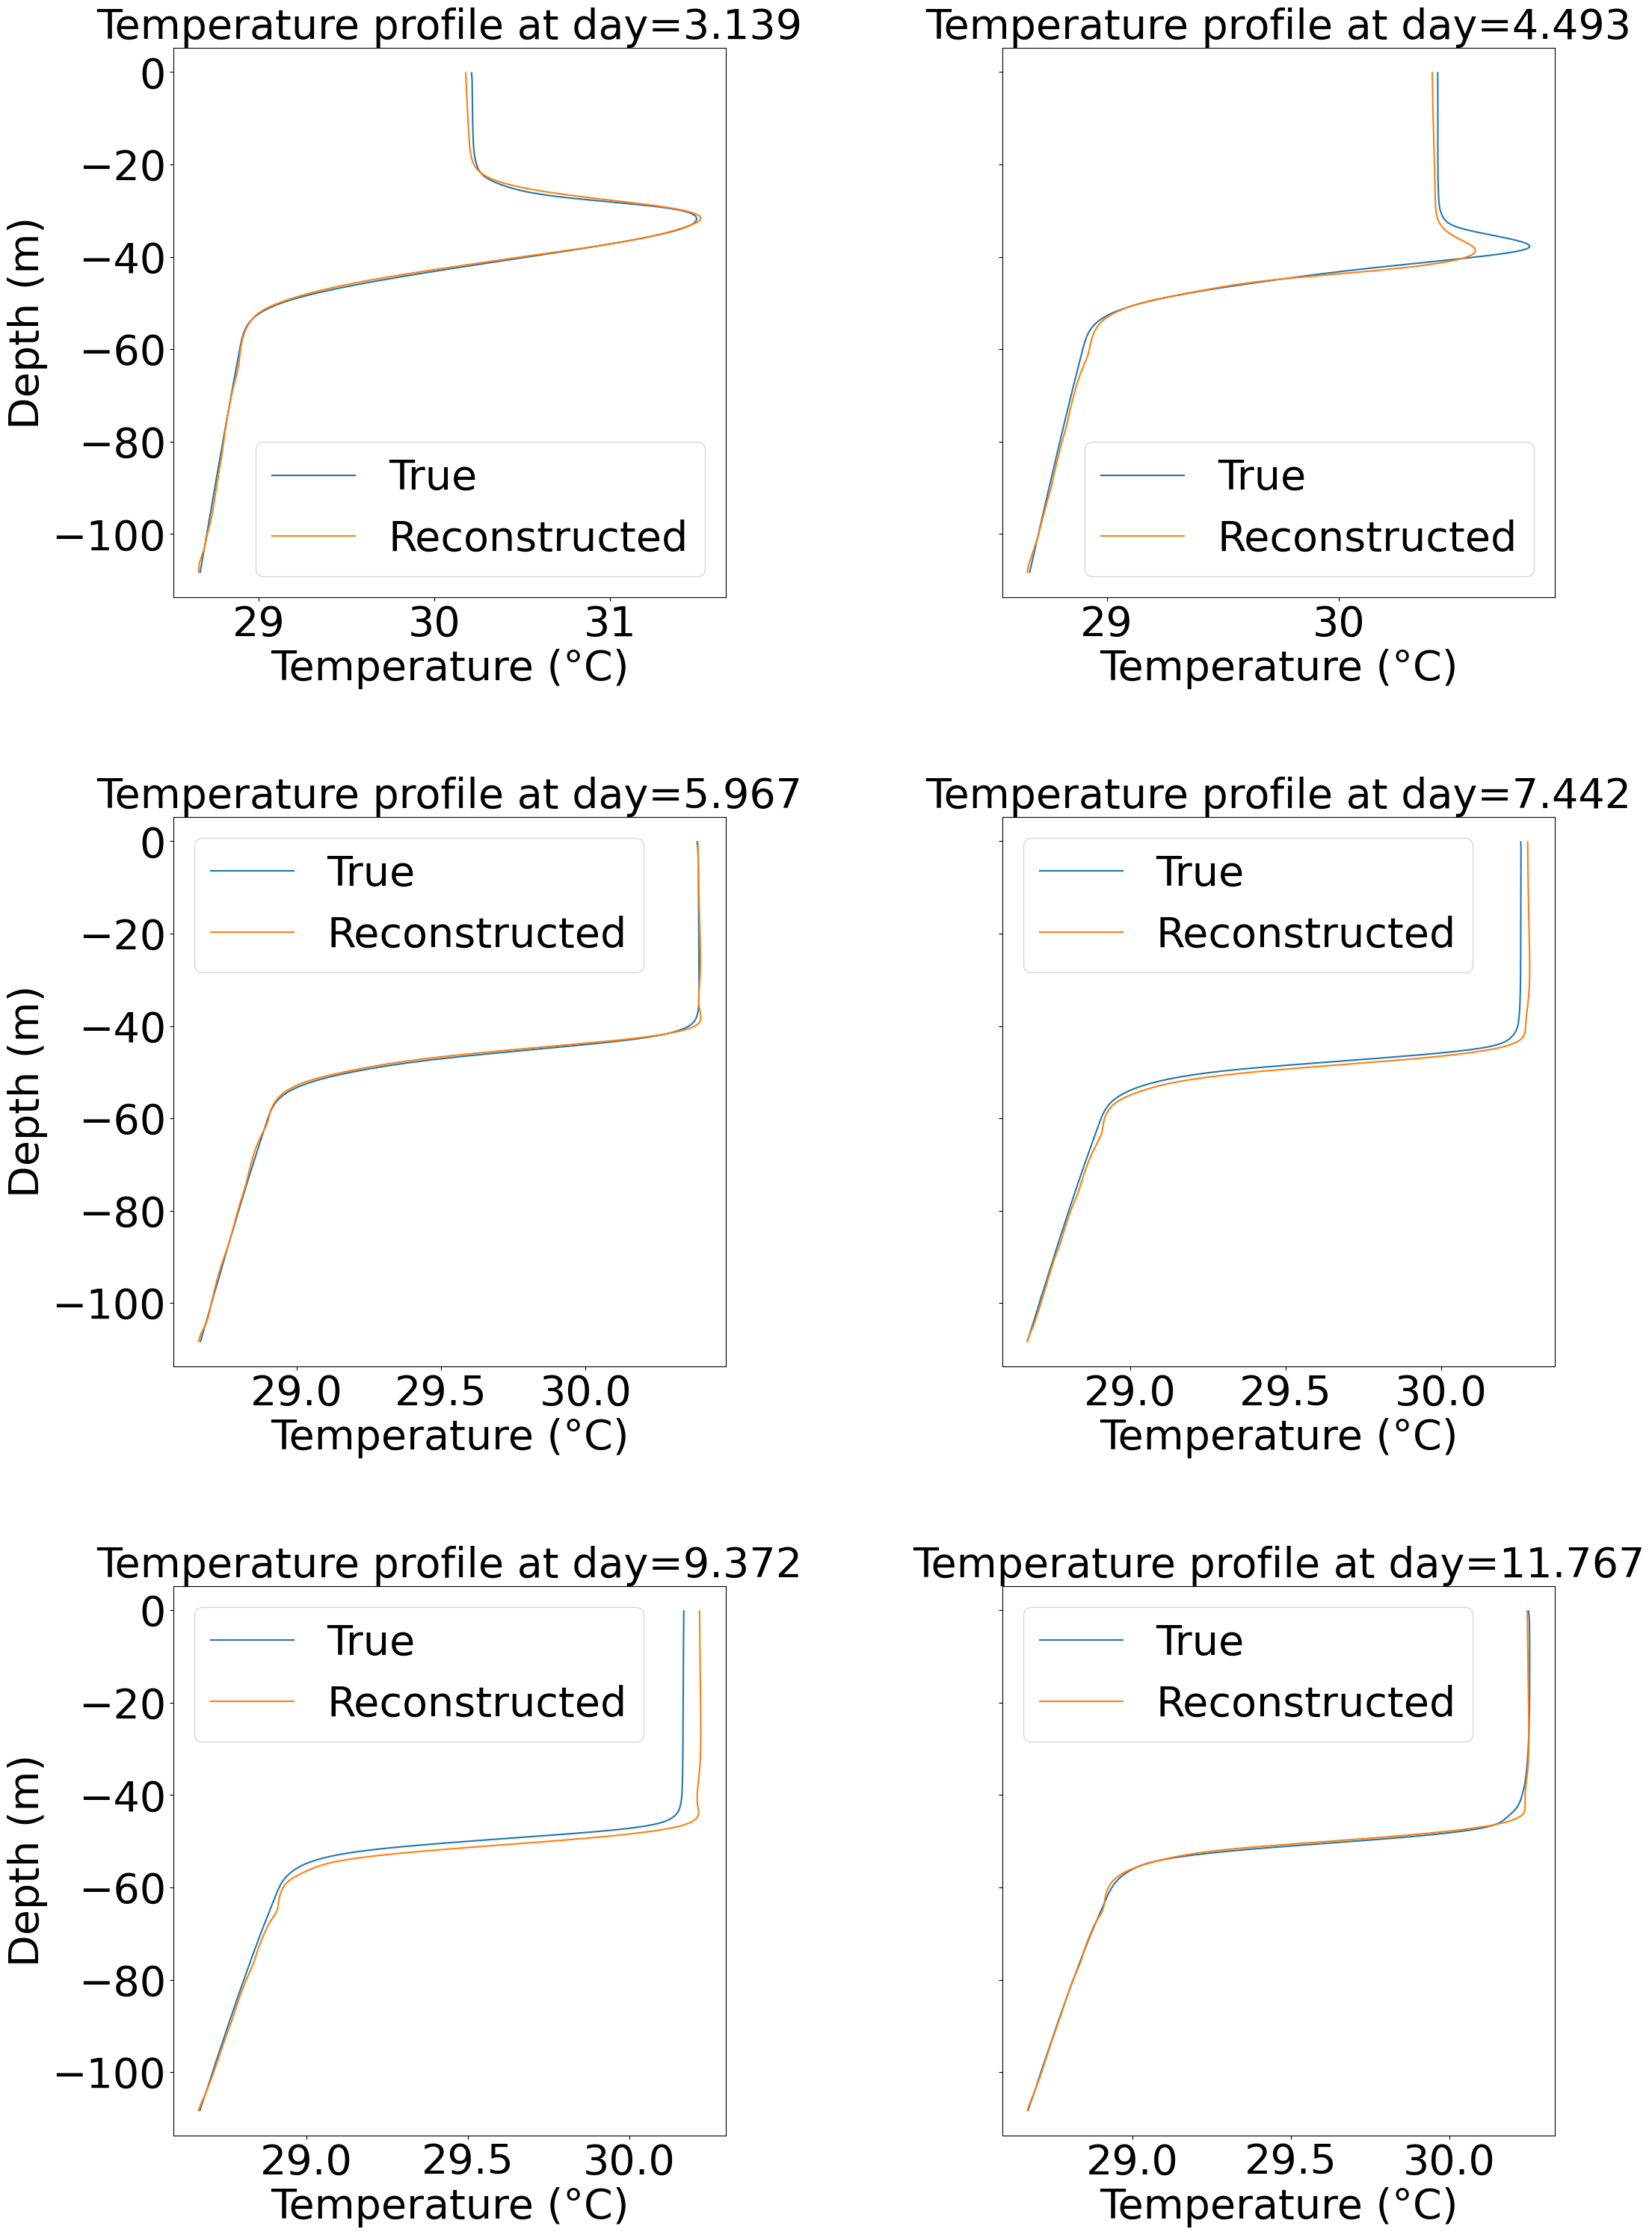

In [85]:
fig, ax = plt.subplots(3,2, figsize=(21,30),sharey=True,squeeze=True)
days=hours/24
p = 0
timeSteps=p+1500
for i in range(3):
    for j in range(2):
        ax[i, j].plot(In.inv_transform(Testx_tr1[p,:,:])[:,:,0].T,ZZ.T,label='True')
        ax[i, j].plot(In.inv_transform(x_rec1[p,:,:].detach().numpy())[:,:,0].T,ZZ.T,label='predicted')
        if j==0:
            ax[i, j].set_ylabel('Depth (m)',fontsize=40)
        ax[i, j].legend(['True','Reconstructed'], fontsize=40)
        ax[i, j].set_title(f'Temperature profile at day=%1.3f' % days[timeSteps], fontsize=40)
        ax[i,j].tick_params(axis='both', labelsize=40)
        ax[i, j].set_xlabel('Temperature (\xb0C)',fontsize=40)

        p += 1166 #1166 for 1500-8500
        timeSteps += 1166  # for 1500-8500

plt.tight_layout()
plt.subplots_adjust(wspace=0.5, hspace=0.4)
plt.show()

In [88]:
# Finding the coordinate of maximum temperature.
Testxx=np.copy(Testx_tr1)
for i in range(Testx_tr1.shape[0]):
    Testxx[i,0,0]=Testx_tr1[i,1,0]

coordinatemaxTr=np.zeros((Testx_tr1.shape[0],1))
dTestxx=np.zeros((Testxx.shape[0],Testxx.shape[1]-1,1))
for i in range(Testxx.shape[0]):
    dTestxx[i,:,:]=np.abs((Testxx[i,1:,0:1]-Testxx[i,:-1,0:1])/(ZZ[0:1,1:].T-ZZ[0:1,:-1].T))
    maxarg =np.argmax(dTestxx[i,:,:])
    coordinatemaxTr[i,0]=ZZ[0,maxarg]                   
                        

Testxx=np.copy(x_rec1)
for i in range(x_rec1.shape[0]):
    Testxx[i,0,0]=x_rec1[i,1,0]

coordinatemaxpred1=np.zeros((x_rec1.shape[0],1))
dTestxx=np.zeros((Testxx.shape[0],Testxx.shape[1]-1,1))
for i in range(Testxx.shape[0]):
    dTestxx[i,:,:]=np.abs((Testxx[i,1:,0:1]-Testxx[i,:-1,0:1])/(ZZ[0:1,1:].T-ZZ[0:1,:-1].T))
    maxarg =np.argmax(dTestxx[i,:,:])
    coordinatemaxpred1[i,0]=ZZ[0,maxarg]
#coordinatemaxpred1[241:245]=-30.75

In [47]:
filename='mld-temp(1500-7500).mat'
mld={'mld_pred':coordinatemaxpred1, 'mld_True': coordinatemaxTr}
scipy.io.savemat(filename,mld)

In [45]:
# Finding the coordinate of maximum temperature.
coordinatemaxpred1[241:246]=-30.75
Testxx=np.copy(Testx_tr1)
for i in range(Testx_tr1.shape[0]):
    Testxx[i,0,0]=Testx_tr1[i,1,0]

coordinatemaxTr=np.zeros((Testx_tr1.shape[0],1))
for i in range(Testxx.shape[0]):
    maxarg =np.argmax(Testxx[i,:,:])
    coordinatemaxTr[i,0]=ZZ[0,maxarg]                   
                        


Testxx=np.copy(x_rec1)
for i in range(x_rec1.shape[0]):
    Testxx[i,0,0]=x_rec1[i,1,0]

coordinatemaxpred1=np.zeros((x_rec1.shape[0],1))
for i in range(Testxx.shape[0]):
    maxarg =np.argmax(Testxx[i,:,:])
    coordinatemaxpred1[i,0]=ZZ[0,maxarg]

Text(0.05, 0.45, 'Depth (meters)')

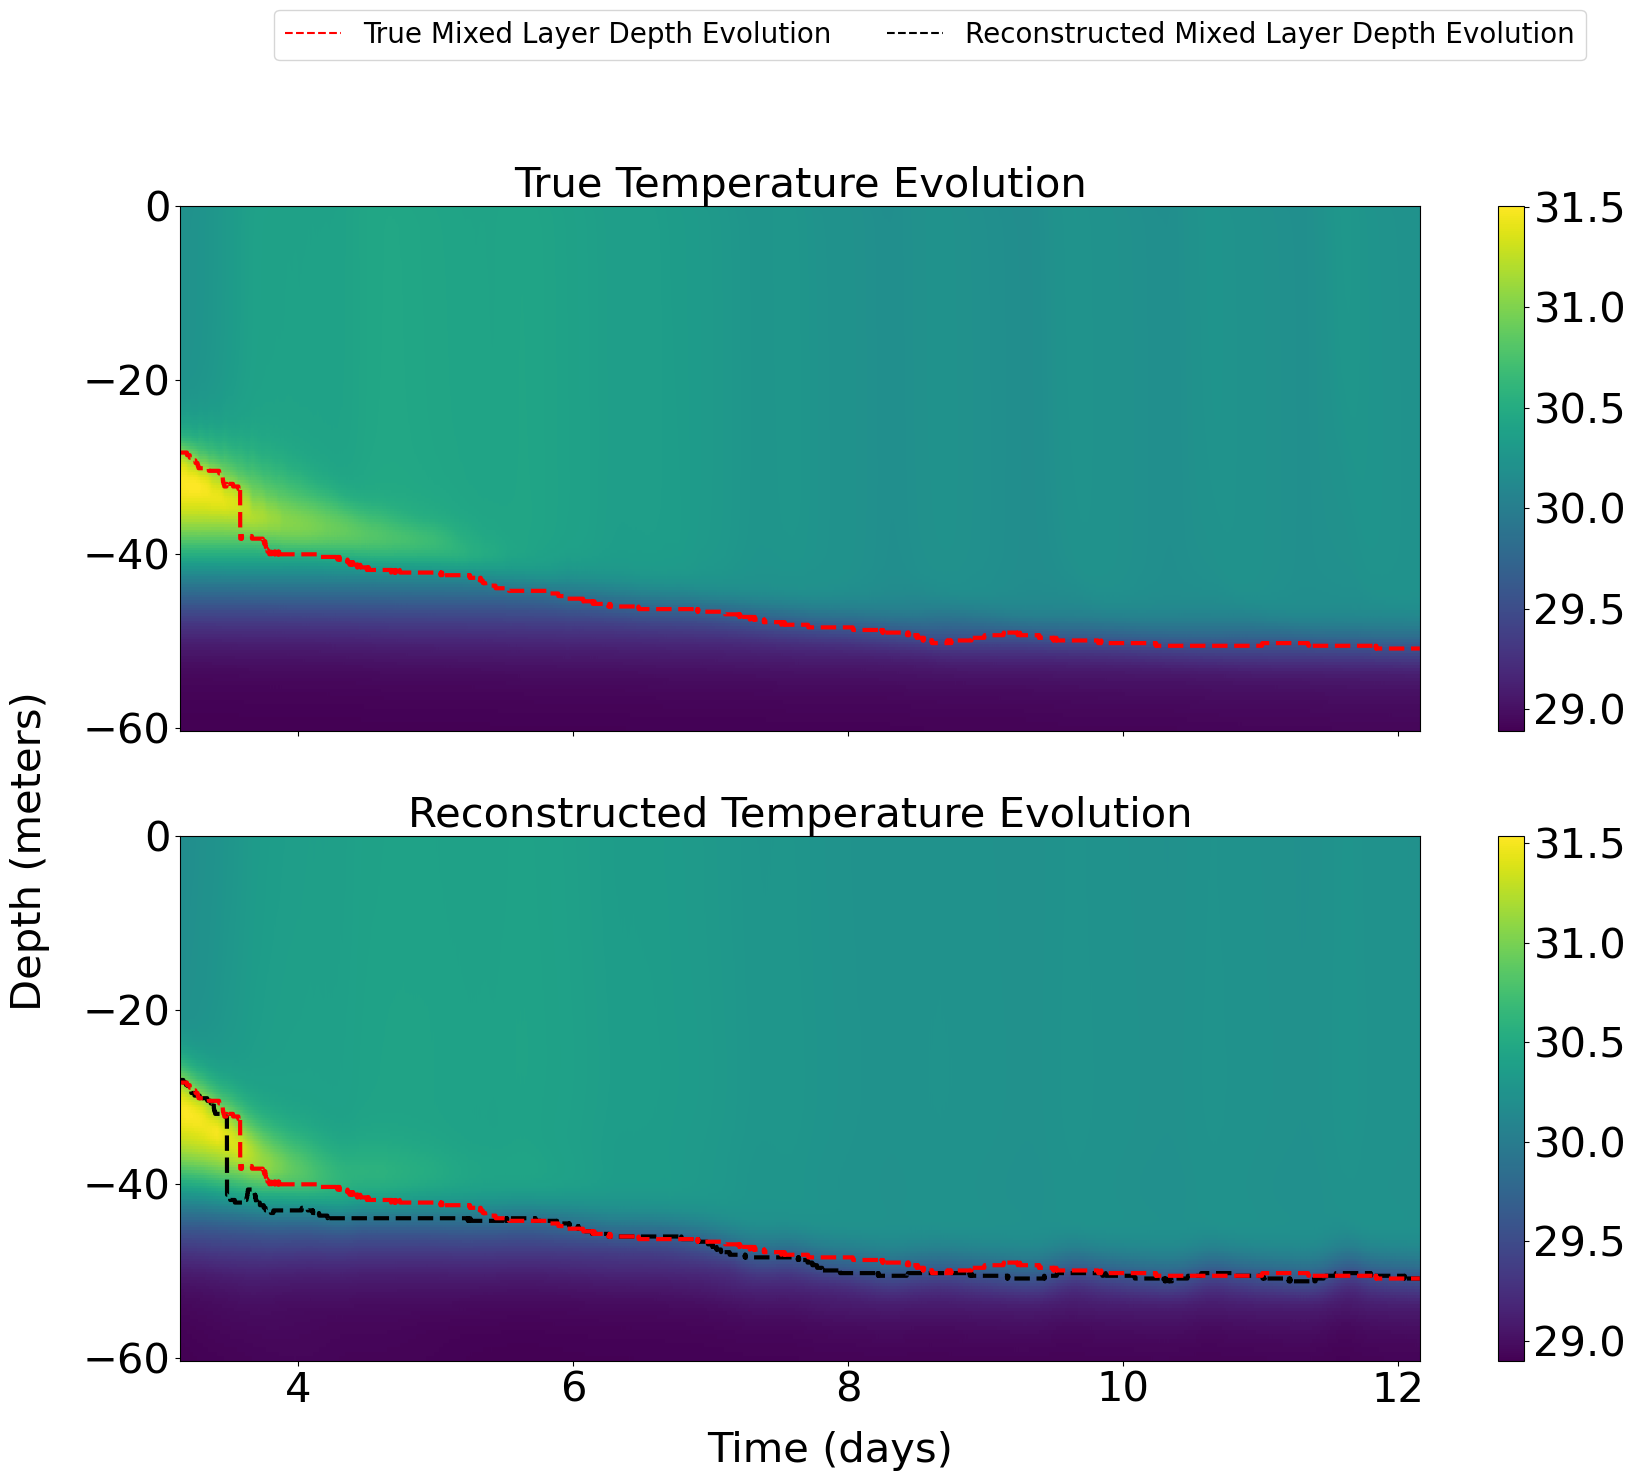

In [92]:
#pcolor plots
t=np.linspace(1000,4000,3000,endpoint=False)
[xx, tt] = np.meshgrid(ZZ[:,1:].flatten(), hours[1500:endtime]/24)
label_font = {'family': 'serif', 'weight': 'bold', 'size': 18}
fig,ax=plt.subplots(2,1,figsize=(20,15),sharex=True)
endgrid=48
a=ax[1].pcolormesh(tt[:,endgrid-1:],xx[:,endgrid-1:],In.inv_transform(x_rec1[time_step:,endgrid:,:].cpu().detach().numpy())[:,:,0],label='predicted')
b=ax[0].pcolormesh(tt[:,endgrid-1:],xx[:,endgrid-1:],In.inv_transform(Testx_tr1[time_step:,:,:])[:,endgrid:,0],label='actual')
ax[1].set_title('Reconstructed Temperature Evolution',fontsize=30)
ax[0].set_title('True Temperature Evolution',fontsize=30)
cbar1=fig.colorbar(b,ax=ax[0])
cbar2=fig.colorbar(a,ax=ax[1])

cbar1.ax.tick_params(axis='both', labelsize=30)
cbar2.ax.tick_params(axis='both', labelsize=30)

ax[0].plot(hours[1500:endtime] / 24, coordinatemaxTr[time_step:].flatten(), '--', color='red', linewidth=3.0)

ax[1].plot(hours[1500:endtime] / 24, coordinatemaxpred1[time_step:].flatten(), '--', color='black', linewidth=3.0)
ax[1].plot(hours[1500:endtime] / 24, coordinatemaxTr[time_step:].flatten(), '--', color='red', linewidth=3.0)


from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', lw=1.5, linestyle='--', label='True Mixed Layer Depth Evolution'),
    Line2D([0], [0], color='black', lw=1.5, linestyle='--', label='Reconstructed Mixed Layer Depth Evolution')
]
fig.legend(handles=legend_elements, loc='upper center', fontsize=20, bbox_to_anchor=(0.5, 1.02), ncol=3)


ax[0].tick_params(axis='both', labelsize=30)
ax[1].tick_params(axis='both', labelsize=30)

fig.text(0.45, 0.05, 'Time (days)', ha='center', va='center',font={'size': 30})
fig.text(0.05, 0.45, 'Depth (meters)', ha='center', va='center', rotation='vertical',font={'size': 30})


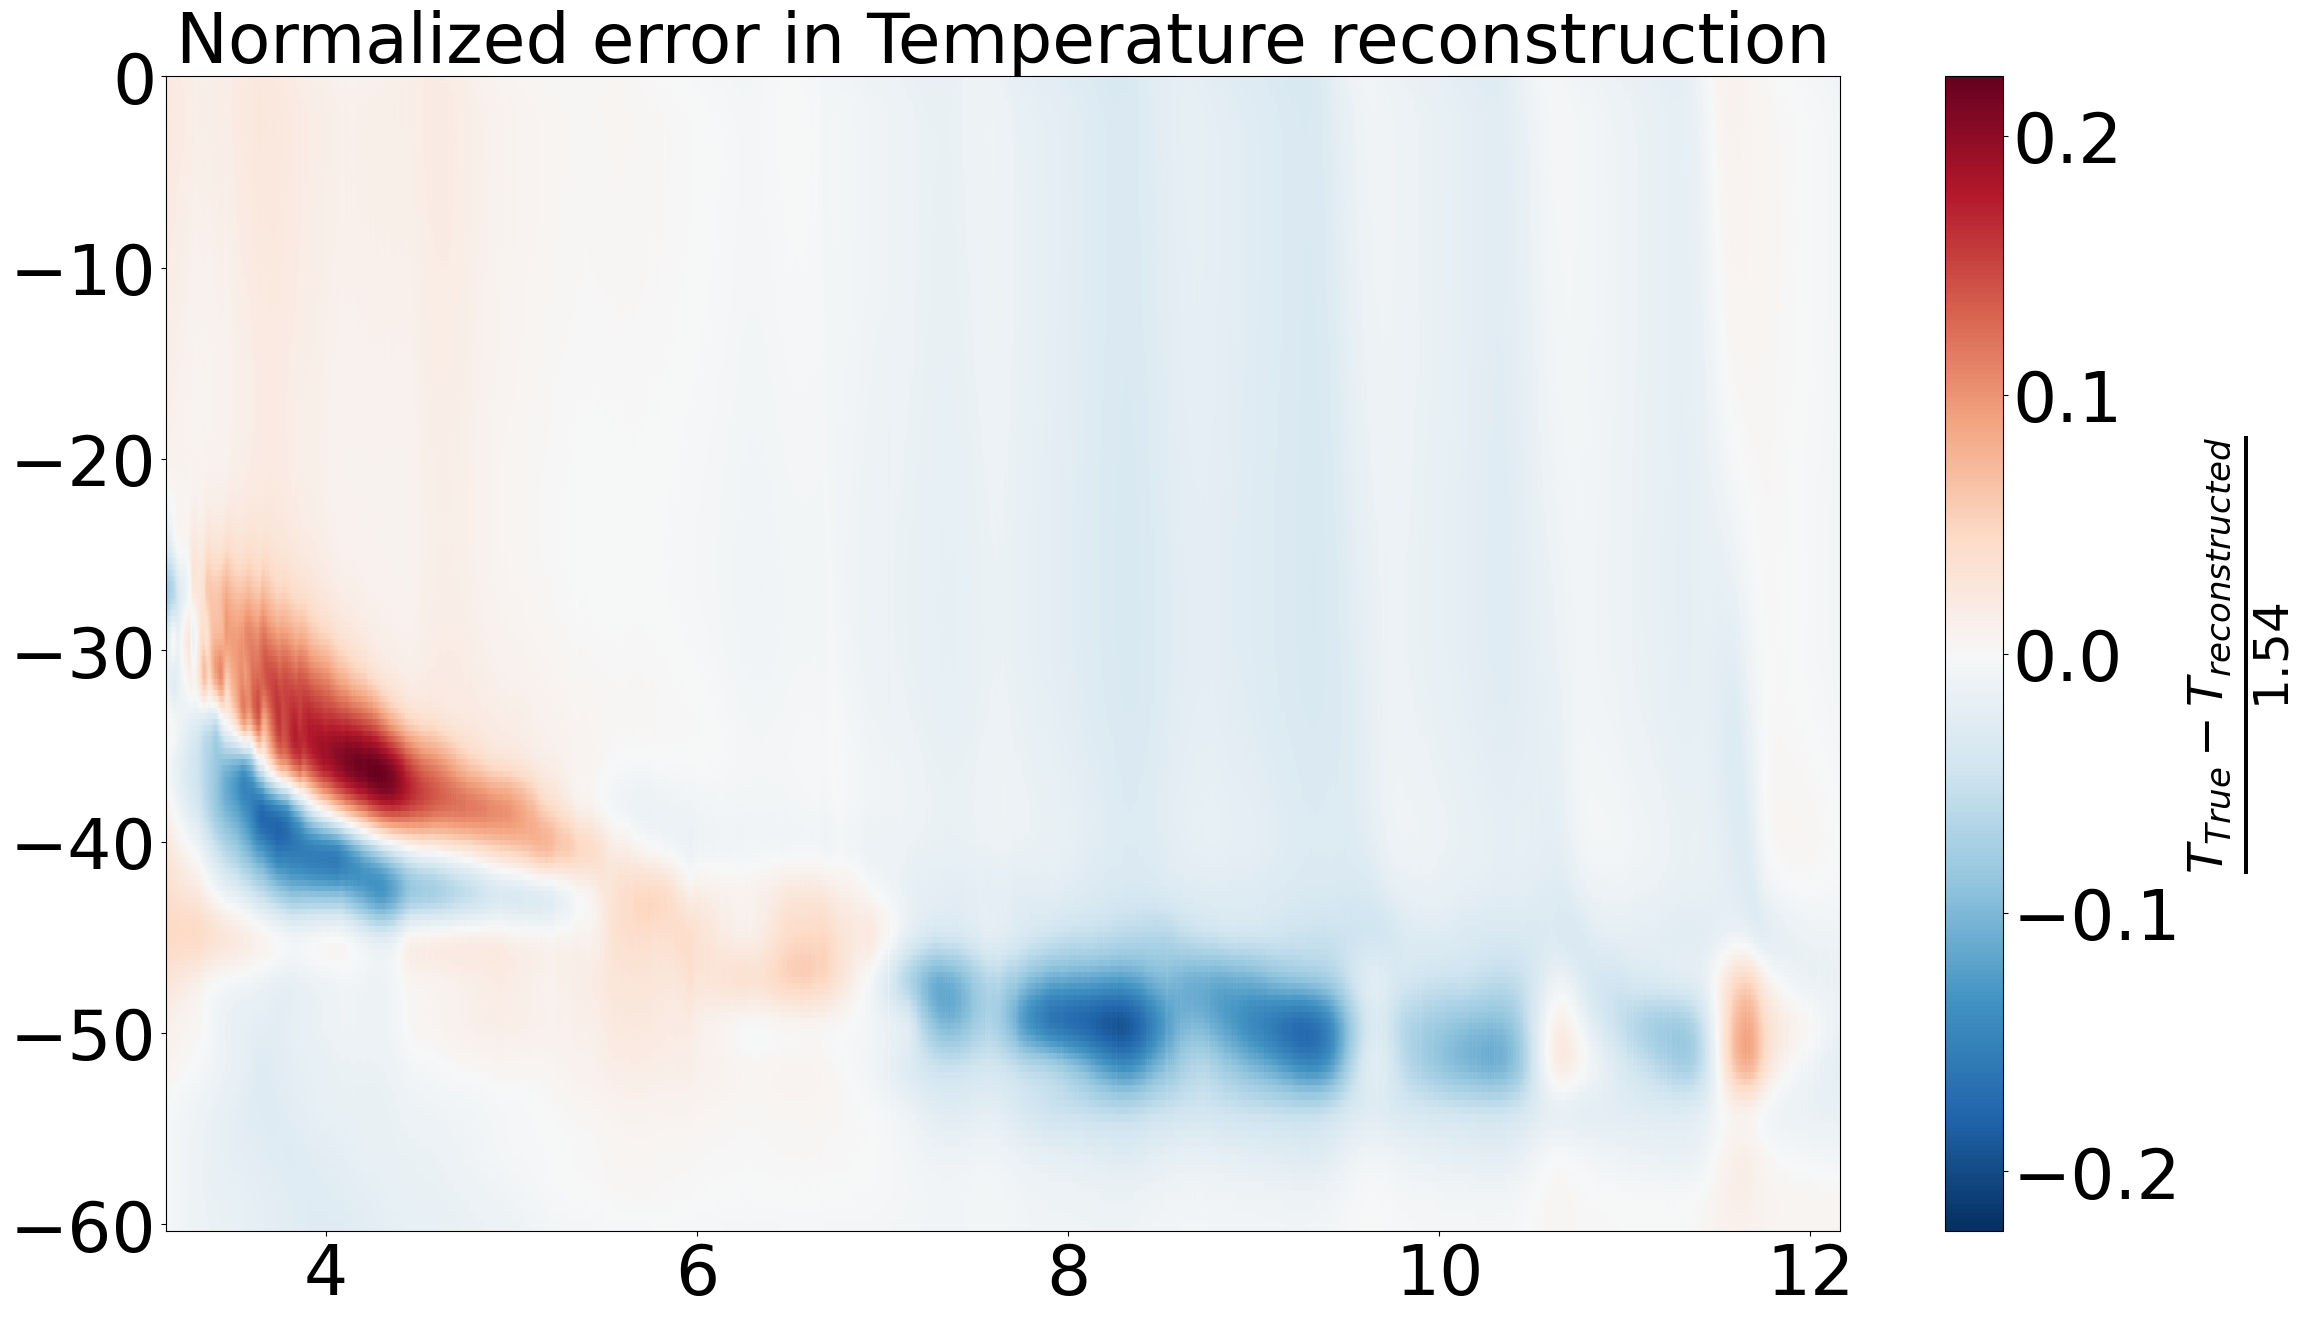

In [93]:


fig, ax = plt.subplots(1, 1, figsize=(27, 15))
from matplotlib.colors import Normalize

data = (In.inv_transform(Testx_tr1[time_step:,:,:])[:,1:,0] / 1.54 - 
        In.inv_transform(x_rec1[time_step:,:,:].cpu().detach().numpy())[:,1:,0] / 1.54)
max_val = np.max(np.abs(data))

norm = Normalize(vmin=-max_val, vmax=max_val)

data = (In.inv_transform(Testx_tr1[time_step:,endgrid:,:])[:,:,0] / 1.54 - 
        In.inv_transform(x_rec1[time_step:,endgrid:,:].cpu().detach().numpy())[:,:,0] / 1.54)

# Plot with normalization and centered colormap
im = ax.pcolormesh(
    tt[:,endgrid-1:], xx[:,endgrid-1:], data,
    label='predicted', norm=norm, cmap="RdBu_r"
)

ax.set_title('Normalized error in Temperature reconstruction', fontsize=50)

colo = plt.colorbar(im, ax=ax)
colo.set_label(r'$\frac{T_{True} - T_{reconstructed}}{1.54}$', fontsize=50)
colo.ax.tick_params(axis='both', labelsize=50)

ax.tick_params(axis='both', labelsize=50)

plt.show()


## Preparing the data for Temporal Evolution

In [96]:
# Data for training LSTM and DNN
out,reduced_Train= model((torch.tensor(x_tr[:,:,:]).to(device)))

outv,reduced_val=model(torch.tensor(Valx_tr[:,:,:]).to(device))

outT,reduced_test=model(torch.tensor(Testx_tr[:,:,:]).to(device))

print(reduced_Train.shape)
print(reduced_val.shape)
print(reduced_test.shape)

torch.Size([3700, 3])
torch.Size([300, 3])
torch.Size([6010, 3])


In [97]:
# 1500-7500
reduced_all=torch.cat([reduced_Train[0:1500],reduced_test[time_step:time_step+1500],reduced_val,reduced_Train[1500:-1000],reduced_test[1500+time_step+1500:]])

In [62]:
filename1='reduced_all.mat'

reduced_al={'red_all':reduced_all.cpu().detach().numpy()}

scipy.io.savemat(filename1,reduced_al)


In [99]:
#Interpolated plus 1500-2500
Input_BC=loadmat("Input_BC")
B_C=Input_BC['BC'].astype(np.float32)

BC1=B_C[0:1500,[1,2,3,4]]
BC2=B_C[3300:4500,[1,2,3,4]]

BC3=B_C[7500:8500,[1,2,3,4]]

BC_train=np.concatenate([BC1,BC2,BC3],axis=0)

bc=MinMaxScaler()
BC_train=bc.fit_transform(BC_train)
BC_val=B_C[3000:3300,[1,2,3,4]]

BC_val=bc.transform(BC_val)
BC_test=B_C[1500-time_step_test:endtime,[1,2,3,4]]
BC_test=bc.transform(BC_test)
print(BC_test.shape)
print(B_C.shape)
print(BC_train.shape)

(6010, 4)
(8501, 6)
(3700, 4)


In [100]:
BC_cond=4

In [148]:
Val_In=np.zeros((reduced_val.shape[0]-time_step,time_step,encoded_size+BC_cond))
Val_Out=np.zeros((reduced_val.shape[0]-time_step,encoded_size))


for i in range(300-time_step):
    Val_In[i,:,0:encoded_size]=reduced_val1[i:i+time_step,:].cpu().detach().numpy()
    Val_In[i,:,encoded_size:]=BC_val[i:i+time_step,:]
    Val_Out[i,:]=reduced_val1[i+time_step,:].cpu().detach().numpy()#-reduced_val[i+time_step-1,:].cpu().detach().numpy()

print(Val_In.shape)

(290, 10, 7)


## Creating Input-Output pair suitable for training the data

In [101]:

Train_In=np.zeros((reduced_Train.shape[0]-time_step*6,time_step,encoded_size+BC_cond))
Train_Out=np.zeros((reduced_Train.shape[0]-time_step*6,encoded_size*time_step))
#dt_time_Train=np.zeros((reduced_Train.shape[0]-time_step*4,time_step,1))

print(reduced_Train.shape)

j=0
for i in range(0,1500-2*time_step):
    Train_In[j,:,0:encoded_size]=reduced_Train[i:i+time_step,:].cpu().detach().numpy()
    Train_In[j,:,encoded_size:]=BC_train[i:i+time_step,:]
    #Train_In[j,:,-1]=dt_train[i:i+time_step,0]
    Train_Out[j,:]=(reduced_Train[i+time_step:i+2*time_step,:].cpu().detach().numpy()).reshape(1,encoded_size*time_step)
    #dt_time_Train[j,:]=dt_train[i:i+time_step,0:1]
    j=j+1

for i in range(1500,2700-2*time_step):
    Train_In[j,:,0:encoded_size]=reduced_Train[i:i+time_step,:].cpu().detach().numpy()
    Train_In[j,:,encoded_size:]=BC_train[i:i+time_step,:]
    #Train_In[j,:,-1]=dt_train[i:i+time_step,0]
    Train_Out[j,:]=(reduced_Train[i+time_step:i+2*time_step,:].cpu().detach().numpy()).reshape(1,encoded_size*time_step)
    #dt_time_Train[j,:]=dt_train[i:i+time_step,0:1]
    j=j+1
print(i)

# ADDING LAST profiels of break phase to better the prediction

for i in range(2700,3700-2*time_step):
    Train_In[j,:,0:encoded_size]=reduced_Train[i:i+time_step,:].cpu().detach().numpy()
    Train_In[j,:,encoded_size:]=BC_train[i:i+time_step,:]
    Train_Out[j,:]=(reduced_Train[i+time_step:i+2*time_step,:].cpu().detach().numpy()).reshape(1,encoded_size*time_step)
    j=j+1
print(i)

Val_In=np.zeros((reduced_val.shape[0]-2*time_step,time_step,encoded_size+BC_cond))
Val_Out=np.zeros((reduced_val.shape[0]-2*time_step,encoded_size*time_step))
#dt_time_val=np.zeros((reduced_val.shape[0]-time_step*2,time_step,1))

for i in range(300-2*time_step):
    Val_In[i,:,0:encoded_size]=reduced_val[i:i+time_step,:].cpu().detach().numpy()
    Val_In[i,:,encoded_size:]=BC_val[i:i+time_step,:]
    #Val_In[i,:,-1]=dt_val[i:i+time_step,0]
    Val_Out[i,:]=reduced_val[i+time_step:i+2*time_step,:].cpu().detach().numpy().reshape(1,encoded_size*time_step)
    #dt_time_val[i,:]=dt_val[i:i+time_step,0:1]
    

print(Val_In.shape)

Test_In=np.zeros((reduced_test.shape[0]-2*time_step,time_step,encoded_size+BC_cond))
Test_Out=np.zeros((reduced_test.shape[0]-2*time_step,encoded_size*time_step))
#dt_time_test=np.zeros((reduced_test.shape[0]-time_step*2,time_step,1))


for i in range(0,7000-time_step):
    Test_In[i,:,0:encoded_size]=reduced_test[i:i+time_step,:].cpu().detach().numpy()
    Test_In[i,:,encoded_size:]=BC_test[i:i+time_step,:]
    #Test_In[i,:,-1]=dt_test[i:i+time_step,0]
    Test_Out[i,:]=reduced_test[i+time_step:i+2*time_step,:].cpu().detach().numpy().reshape(1,encoded_size*time_step)
    #dt_time_test[i,:]=dt_test[i:i+time_step,0:1]

print(Test_In.shape)

torch.Size([3700, 3])
2679
3679
(280, 10, 7)


IndexError: index 5990 is out of bounds for axis 0 with size 5990

In [102]:
# Saving INput,validation and test data.

filename1='TrainingIn.mat'

reduced_train_In={'red_train':Train_In}
filename2='TrainingOut.mat'
reduced_train_Out={'red_train':Train_Out}

scipy.io.savemat(filename1,reduced_train_In)
scipy.io.savemat(filename2,reduced_train_Out)

filename3='Validation_In.mat'
filename4='Validation_Out.mat'

reduced_val_In={'val_train':Val_In}
reduced_val_Out={'val_train':Val_Out}

scipy.io.savemat(filename3,reduced_val_In)
scipy.io.savemat(filename4,reduced_val_Out)


filename3='Test_In.mat'
filename4='Test_Out.mat'

reduced_test_In={'red_test':Test_In}
reduced_test_Out={'red_test':Test_Out}

scipy.io.savemat(filename3,reduced_test_In)
scipy.io.savemat(filename4,reduced_test_Out)



In [103]:
# Test initial condition
Test_In=np.zeros((1,time_step_test,encoded_size+BC_cond))


Test_In[0,:,0:encoded_size]=reduced_test[0:time_step_test,:].cpu().detach().numpy()   ####
Test_In[0,:,encoded_size:]=BC_test[0:time_step_test,:]
#Test_In[0,:,-1]=dt_test[0:time_step_test,0]

filename5='Test_Inital.mat'
Test_init={'Test':Test_In}

scipy.io.savemat(filename5,Test_init)

filename6='BC_test.mat'
BC_tests={'BC_test':BC_test}

scipy.io.savemat(filename6,BC_tests)

Test_In_all=np.zeros((29,time_step_test,encoded_size))
print(reduced_test[time_step:,:].shape)

Test_In_all=reduced_test[time_step:,:].cpu().detach().numpy()  ####

print(Test_In_all.shape)

filename7='Test_Set.mat'
Test_In_set={'Test_Set':Test_In_all}

scipy.io.savemat(filename7,Test_In_set)


torch.Size([6000, 3])
(6000, 3)


In [104]:
Val_In=np.zeros((1,time_step_test,encoded_size+BC_cond))

Val_In[0,:,0:encoded_size]=reduced_val[0:time_step_test,:].cpu().detach().numpy()
Val_In[0,:,encoded_size:]=BC_val[0:time_step_test,:]
#Val_In[0,:,-1]=dt_val[0:time_step_test,0]

filename5='Val_Inital.mat'
Val_init={'Val':Val_In}

scipy.io.savemat(filename5,Val_init)

filename6='BC_val.mat'
BC_val={'BC_val':BC_val}

scipy.io.savemat(filename6,BC_val)

Val_In_all=np.zeros((29,time_step_test,encoded_size))
print(reduced_val[:,:].shape)

Val_In_all=reduced_val[:,:].cpu().detach().numpy()

print(Val_In_all.shape)

filename7='Val_Set.mat'
Val_In_set={'Val_Set':Val_In_all}

scipy.io.savemat(filename7,Val_In_set)

torch.Size([300, 3])
(300, 3)


### Next go the notebook ILSTM_Tempo_DNN-Temperature-AC.ipynb for traininf the GRU+FC for temporal Evolution. Once trained come back to this notebook

## Decoding from predictions 

In [105]:
pred=loadmat('predictions_encodings.mat')
predictions_enc=pred['pred']
print(predictions_enc.shape)
predictions_enc=torch.from_numpy(predictions_enc).float().to(device)

(6000, 3)


In [108]:
x=torch.zeros(3000, xi.shape[0], 5).to(device)

In [110]:
#
True_tr=model.decoder(reduced_test1[10:].to(device).float(),x)

print(True_tr.shape)

torch.Size([1500, 50, 1])


In [112]:
decoded_predictions=model.decoder(predictions_enc,x)
Truex=Input[1500:endtime,:,:]
True_tr=In.transform(Truex)

True_tr=torch.from_numpy(True_tr)

In [113]:
decoded_predictions1=np.zeros((decoded_predictions.shape[0],240,1))
True_tr1=np.zeros((True_tr.shape[0],240,1))

for i in range(decoded_predictions.shape[0]): 
    decoded_predictions1[i,:,:]=griddata(xi,decoded_predictions[i,:,0:1].cpu().detach().numpy(),points,method='cubic')
    True_tr1[i,:,:]=griddata(xi,True_tr[i,:,0:1].cpu().detach().numpy(),points,method='cubic')
    
print(decoded_predictions1.shape)
#print(True_tr1.shape)

decoded_predictions=torch.from_numpy(decoded_predictions1)
True_tr=torch.from_numpy(True_tr1)

(6000, 240, 1)


In [27]:
days=hours/24



## Final Results from the RNN-ROM  model

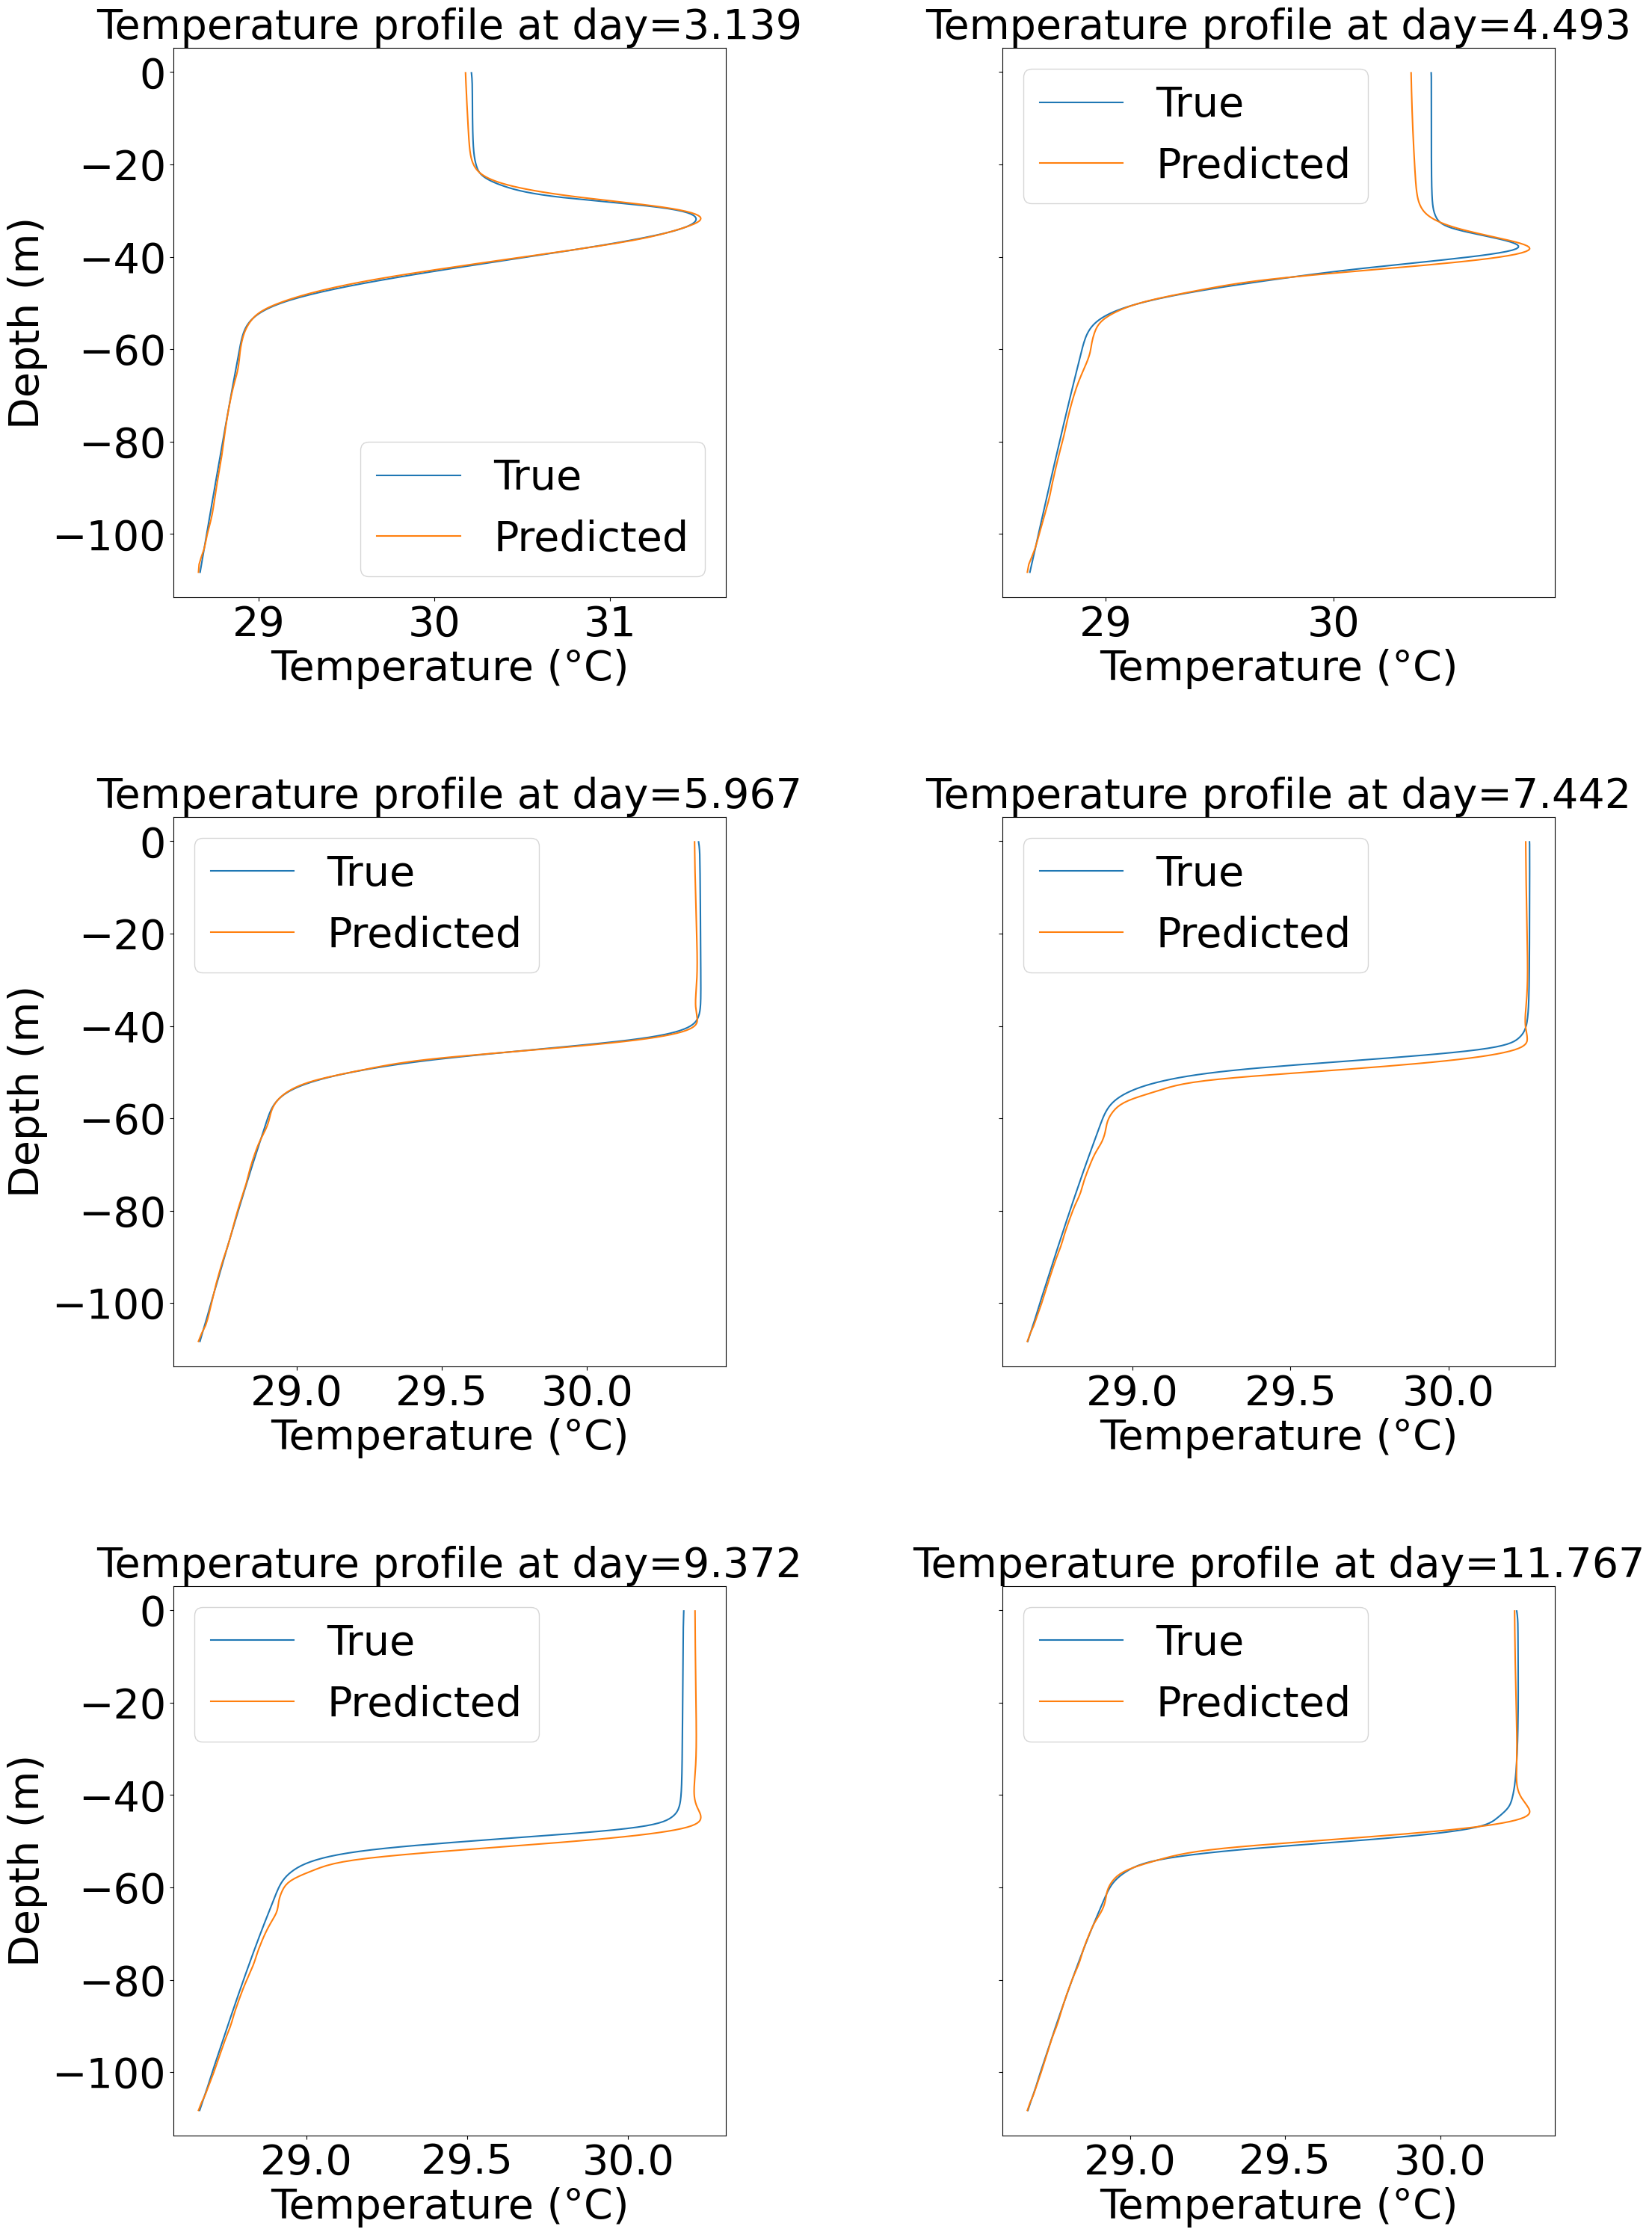

In [114]:
fig, ax = plt.subplots(3,2, figsize=(21,30),sharey=True,squeeze=True)

days=hours/24
p = 0
timeSteps=p+1500
for i in range(3):
    for j in range(2):
        ax[i, j].plot(In.inv_transform(True_tr[p,:,:])[:,:,0].T,ZZ.T,label='True')
        ax[i, j].plot(In.inv_transform(decoded_predictions[p,:,:].detach().numpy())[:,:,0].T,ZZ.T,label='predicted')
        if j==0:
            ax[i, j].set_ylabel('Depth (m)',fontsize=40)
        ax[i, j].legend(['True','Predicted'], fontsize=40)
        ax[i, j].set_title(f'Temperature profile at day=%1.3f' % days[timeSteps], fontsize=40)
        ax[i,j].tick_params(axis='both', labelsize=40)
        ax[i, j].set_xlabel('Temperature (\xb0C)',fontsize=40)

        p += 1166 #1166
        timeSteps += 1166 #1166 

plt.tight_layout()
plt.subplots_adjust(wspace=0.5, hspace=0.4)
plt.show()

"ax[0].plot(In.inv_transform(decoded_predictions[:,:,:].cpu().detach().numpy())[:,-1,1], label='Predicted')\nax[0].plot(In.inv_transform(True_tr)[:,-1,1], label='True')\nax[0].set_title(f'Comparison between LES and LSTM-ROM SSS for k={time_step}')\nax[0].legend()"

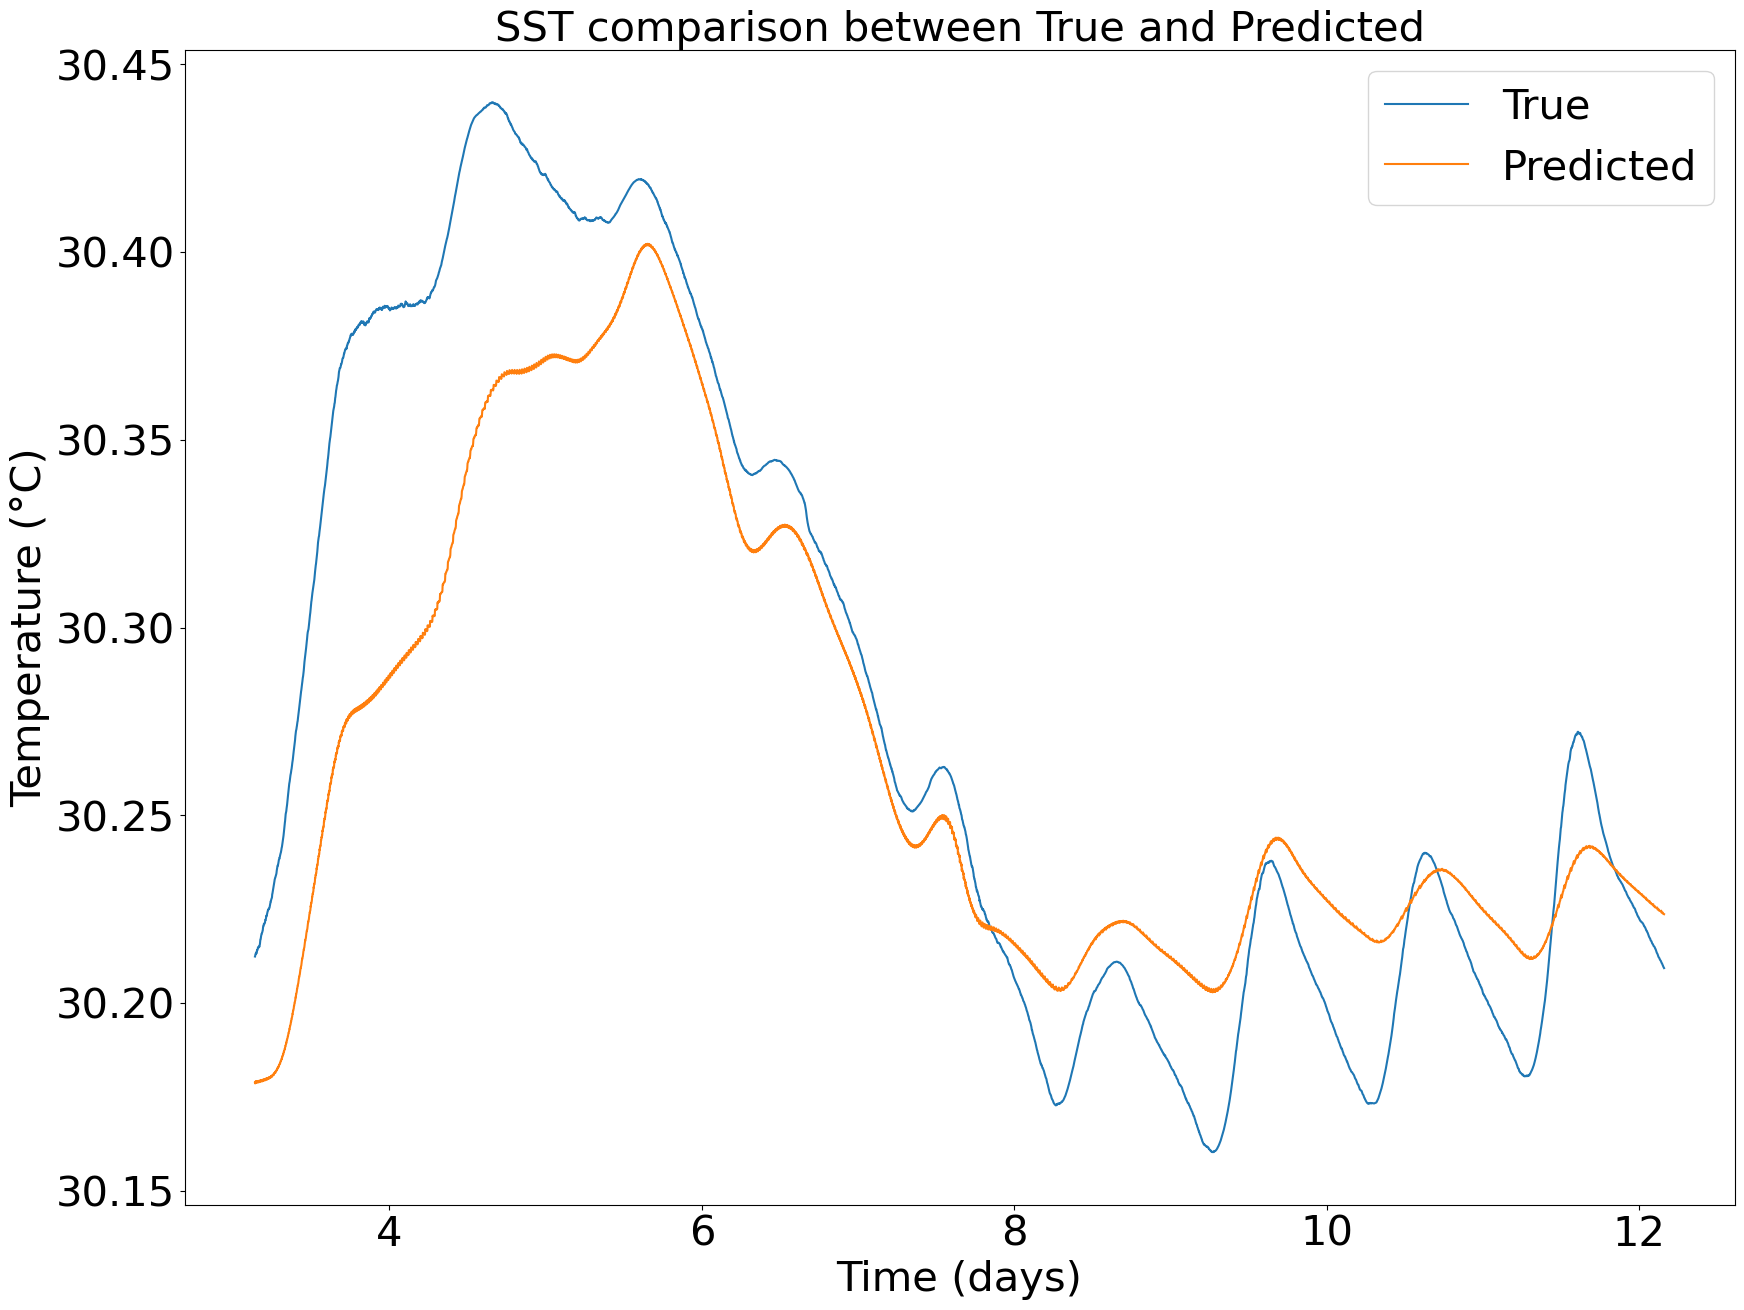

In [115]:
fig,ax= plt.subplots(1,1,figsize=(20,15))
t=np.linspace(7000,8501,1501,endpoint=False)
ax.plot(hours[1500:endtime]/24,In.inv_transform(True_tr)[:,-1,0],label='True')
ax.plot(hours[1500:endtime]/24,In.inv_transform(decoded_predictions.detach().numpy())[:,-1,0],label='Predicted')
ax.set_xlabel('Time (days)',fontsize=30)
ax.set_ylabel('Temperature (\xb0C)',fontsize=30)
ax.set_title('SST comparison between True and Predicted',fontsize=30)
ax.legend(fontsize=30)
ax.tick_params(axis='both', labelsize=30)


In [116]:
# Finding the coordinate of maximum temperature.
Testxx=np.copy(Testx_tr1)
for i in range(Testx_tr1.shape[0]):
    Testxx[i,0,0]=Testx_tr1[i,1,0]

coordinatemaxTr=np.zeros((Testx_tr1.shape[0],1))
dTestxx=np.zeros((Testxx.shape[0],Testxx.shape[1]-1,1))
for i in range(Testxx.shape[0]):
    dTestxx[i,:,:]=np.abs((Testxx[i,1:,0:1]-Testxx[i,:-1,0:1])/(ZZ[0:1,1:].T-ZZ[0:1,:-1].T))
    maxarg =np.argmax(dTestxx[i,:,:])
    coordinatemaxTr[i,0]=ZZ[0,maxarg]                   
                        

Testxx=np.copy(x_rec1)
for i in range(x_rec1.shape[0]):
    Testxx[i,0,0]=x_rec1[i,1,0]

coordinatemaxpred1=np.zeros((x_rec1.shape[0],1))
dTestxx=np.zeros((Testxx.shape[0],Testxx.shape[1]-1,1))
for i in range(Testxx.shape[0]):
    dTestxx[i,:,:]=np.abs((Testxx[i,1:,0:1]-Testxx[i,:-1,0:1])/(ZZ[0:1,1:].T-ZZ[0:1,:-1].T))
    maxarg =np.argmax(dTestxx[i,:,:])
    coordinatemaxpred1[i,0]=ZZ[0,maxarg]       
coordinatemaxpred1[241:246]=-30.75

Text(0.05, 0.45, 'Depth (m)')

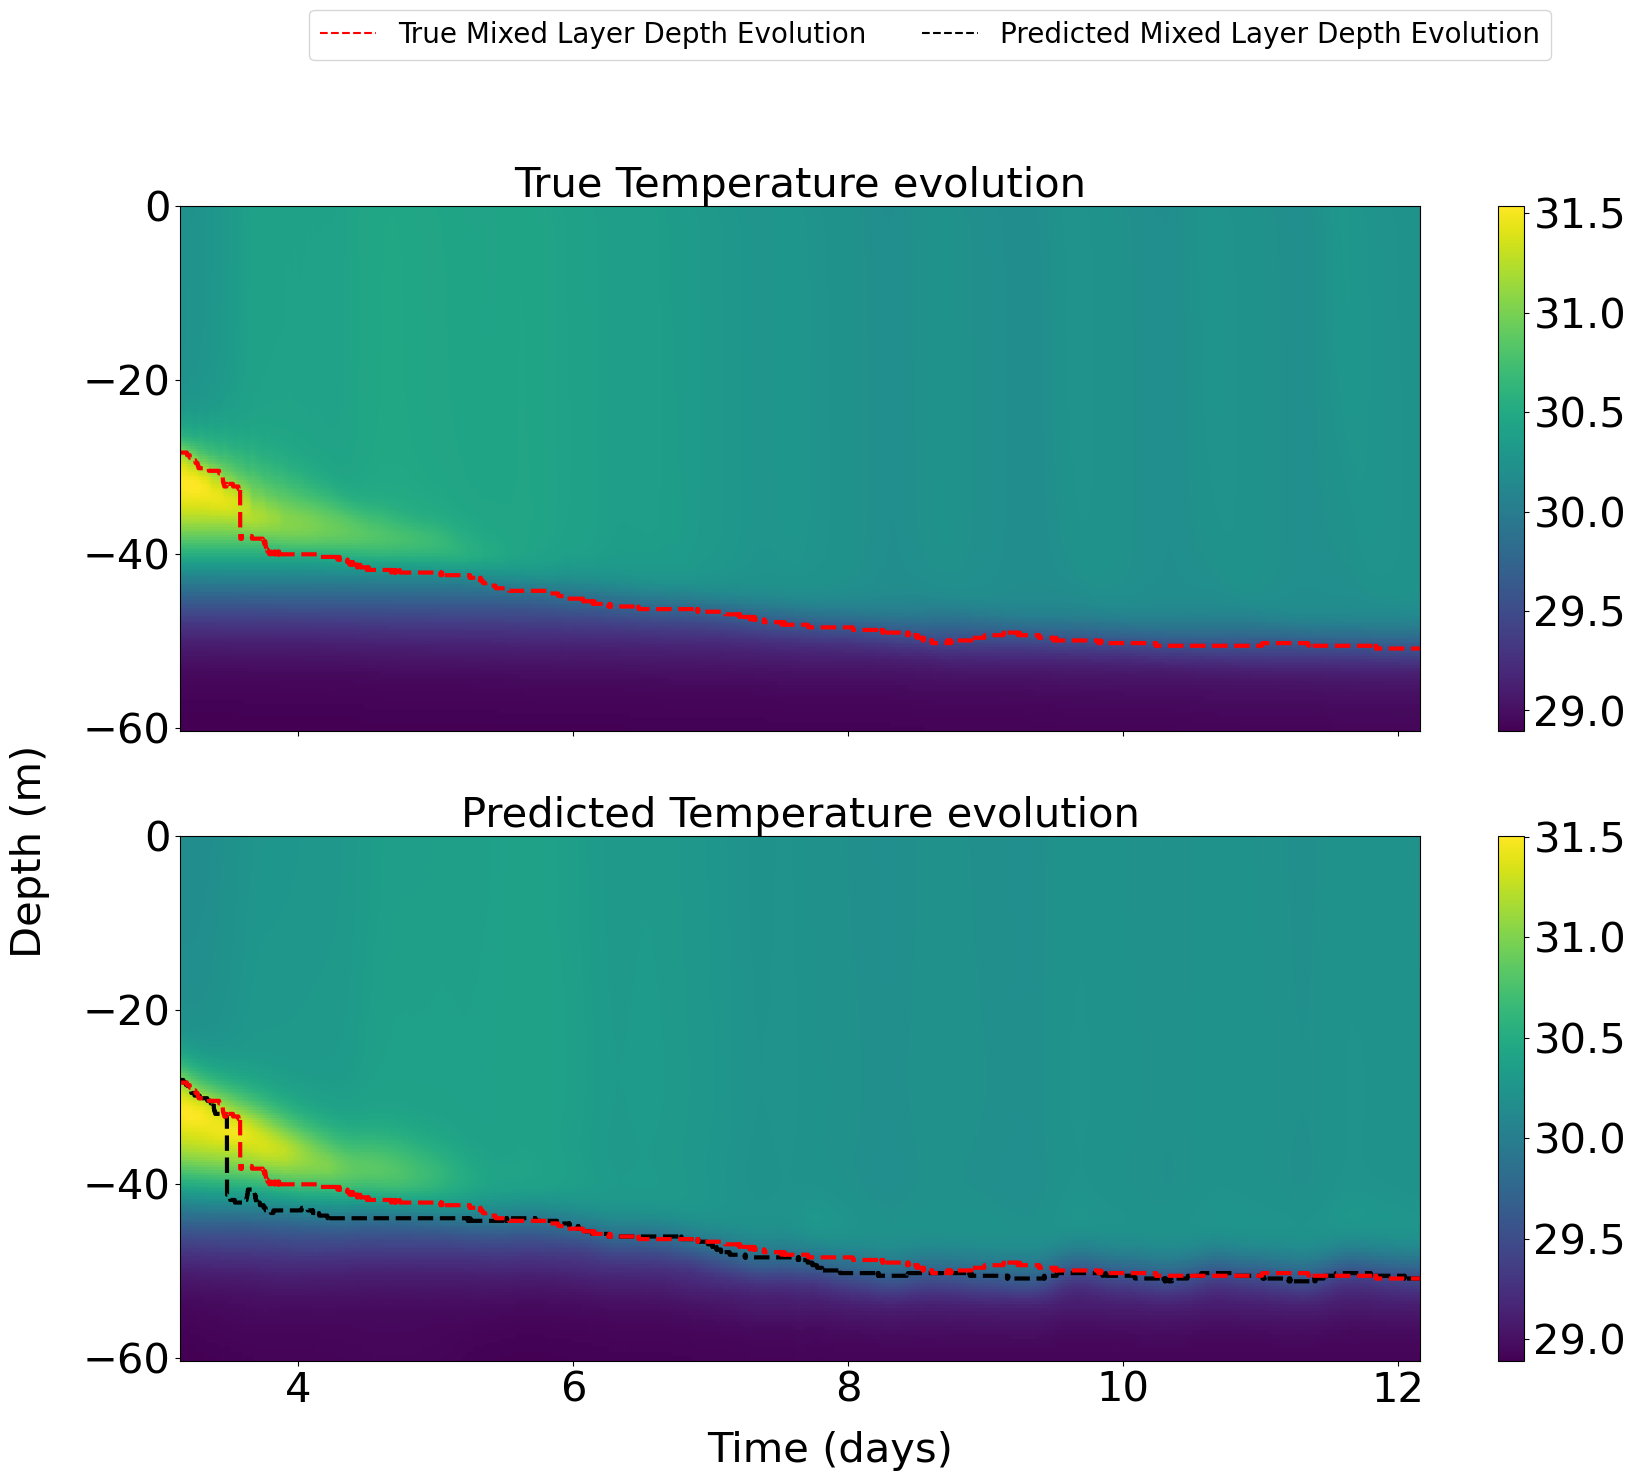

In [119]:
#pcolor plots
t=np.linspace(1000,4999,3999,endpoint=False)
[xx, tt] = np.meshgrid(ZZ[:,1:].flatten(), days[1500:endtime])
label_font = {'family': 'serif', 'weight': 'bold', 'size': 18}
fig,ax=plt.subplots(2,1,figsize=(20,15),sharex=True)

endgrid=48
a=ax[0].pcolormesh(tt[:,endgrid-1:],xx[:,endgrid-1:],In.inv_transform(True_tr[:,endgrid:,:])[:,:,0],label='actual')
b=ax[1].pcolormesh(tt[:,endgrid-1:],xx[:,endgrid-1:],In.inv_transform(decoded_predictions[:,endgrid:,:].cpu().detach().numpy())[:,:,0],label='predicted')
ax[0].set_title('True Temperature evolution',fontsize=30)
ax[1].set_title('Predicted Temperature evolution',fontsize=30)
cbar1=fig.colorbar(b,ax=ax[0])
cbar2=fig.colorbar(a,ax=ax[1])

cbar1.ax.tick_params(axis='both', labelsize=30)
cbar2.ax.tick_params(axis='both', labelsize=30)


ax[0].plot(hours[1500:endtime] / 24, coordinatemaxTr[time_step:].flatten(), '--', color='red', linewidth=3.0)

ax[1].plot(hours[1500:endtime] / 24, coordinatemaxpred1[time_step:].flatten(), '--', color='black', linewidth=3.0)
ax[1].plot(hours[1500:endtime] / 24, coordinatemaxTr[time_step:].flatten(), '--', color='red', linewidth=3.0)


from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', lw=1.5, linestyle='--', label='True Mixed Layer Depth Evolution'),
    Line2D([0], [0], color='black', lw=1.5, linestyle='--', label='Predicted Mixed Layer Depth Evolution')
]
fig.legend(handles=legend_elements, loc='upper center', fontsize=20, bbox_to_anchor=(0.5, 1.02), ncol=3)

ax[0].tick_params(axis='both', labelsize=30)
ax[1].tick_params(axis='both', labelsize=30)

fig.text(0.45, 0.05, 'Time (days)', ha='center', va='center',font={'size': 30})
fig.text(0.05, 0.45, 'Depth (m)', ha='center', va='center', rotation='vertical',font={'size': 30})

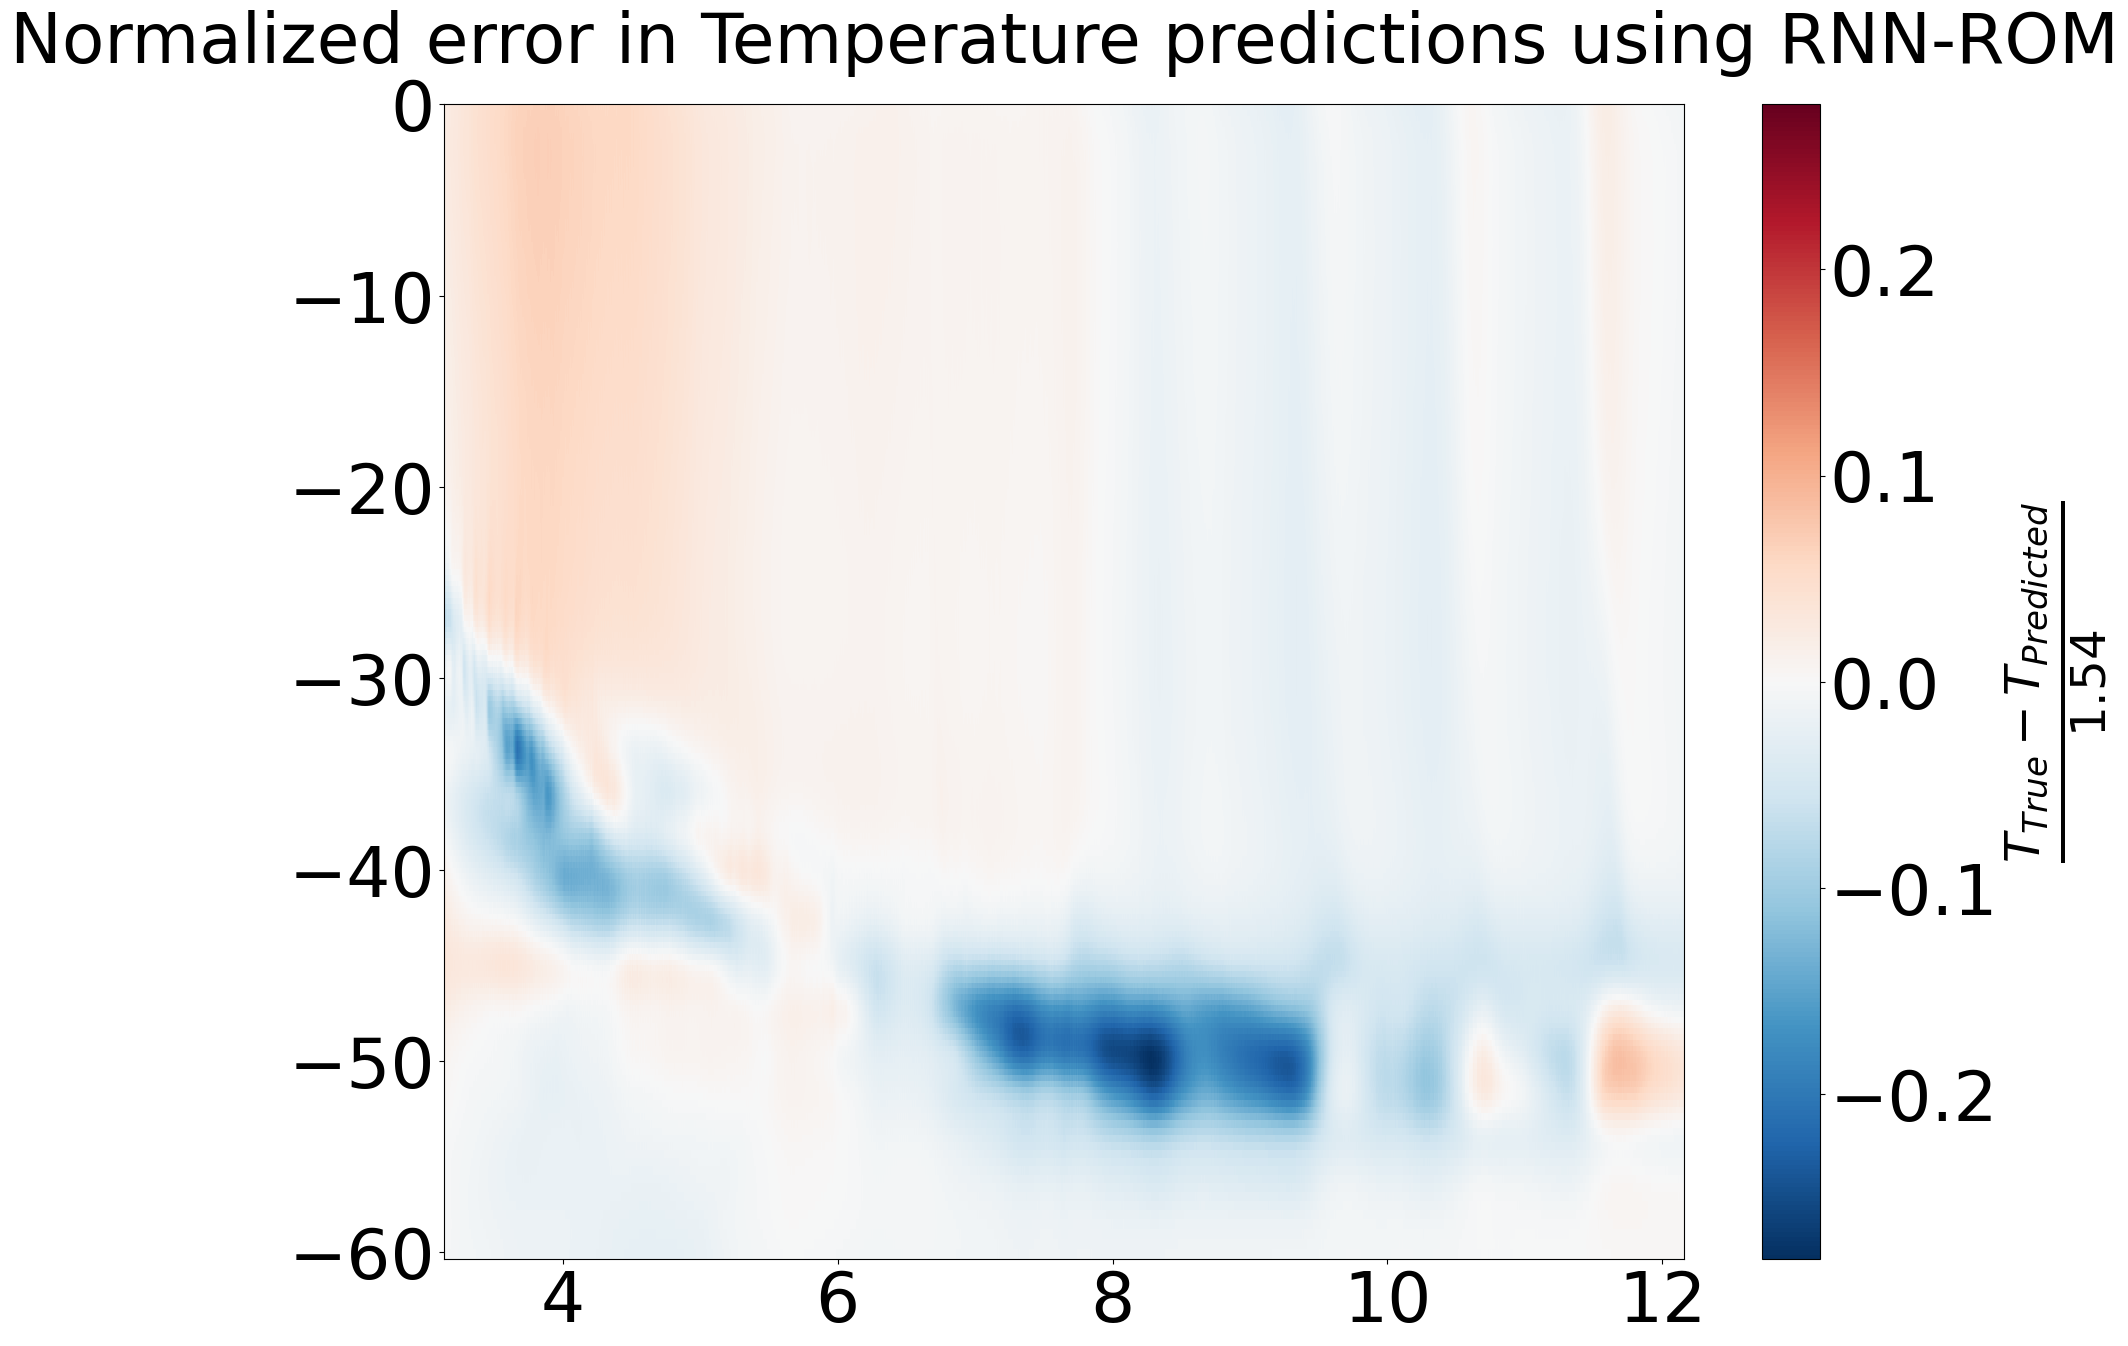

In [120]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
from matplotlib.colors import Normalize


data = (In.inv_transform(True_tr[:,:,:].cpu().detach().numpy())[:,1:,0] / 1.54 - 
        In.inv_transform(decoded_predictions[:,:,:].cpu().detach().numpy())[:,1:,0] / 1.54)
max_val = np.max(np.abs(data))


norm = Normalize(vmin=-max_val, vmax=max_val)

data = (In.inv_transform(True_tr[:,endgrid:,:].cpu().detach().numpy())[:,:,0] / 1.54 - 
        In.inv_transform(decoded_predictions[:,endgrid:,:].cpu().detach().numpy())[:,:,0] / 1.54)

im = ax.pcolormesh(
    tt[:,endgrid-1:], xx[:,endgrid-1:], data,
    label='predicted', norm=norm, cmap="RdBu_r"
)

ax.set_title('Normalized error in Temperature predictions using RNN-ROM', fontsize=50, pad=30)

colo = plt.colorbar(im, ax=ax)
colo.ax.tick_params(axis='both', labelsize=50)
ax.tick_params(axis='both', labelsize=50)
colo.set_label(r'$\frac{T_{True} - T_{Predicted}}{1.54}$', fontsize=50, fontweight='bold')

plt.show()


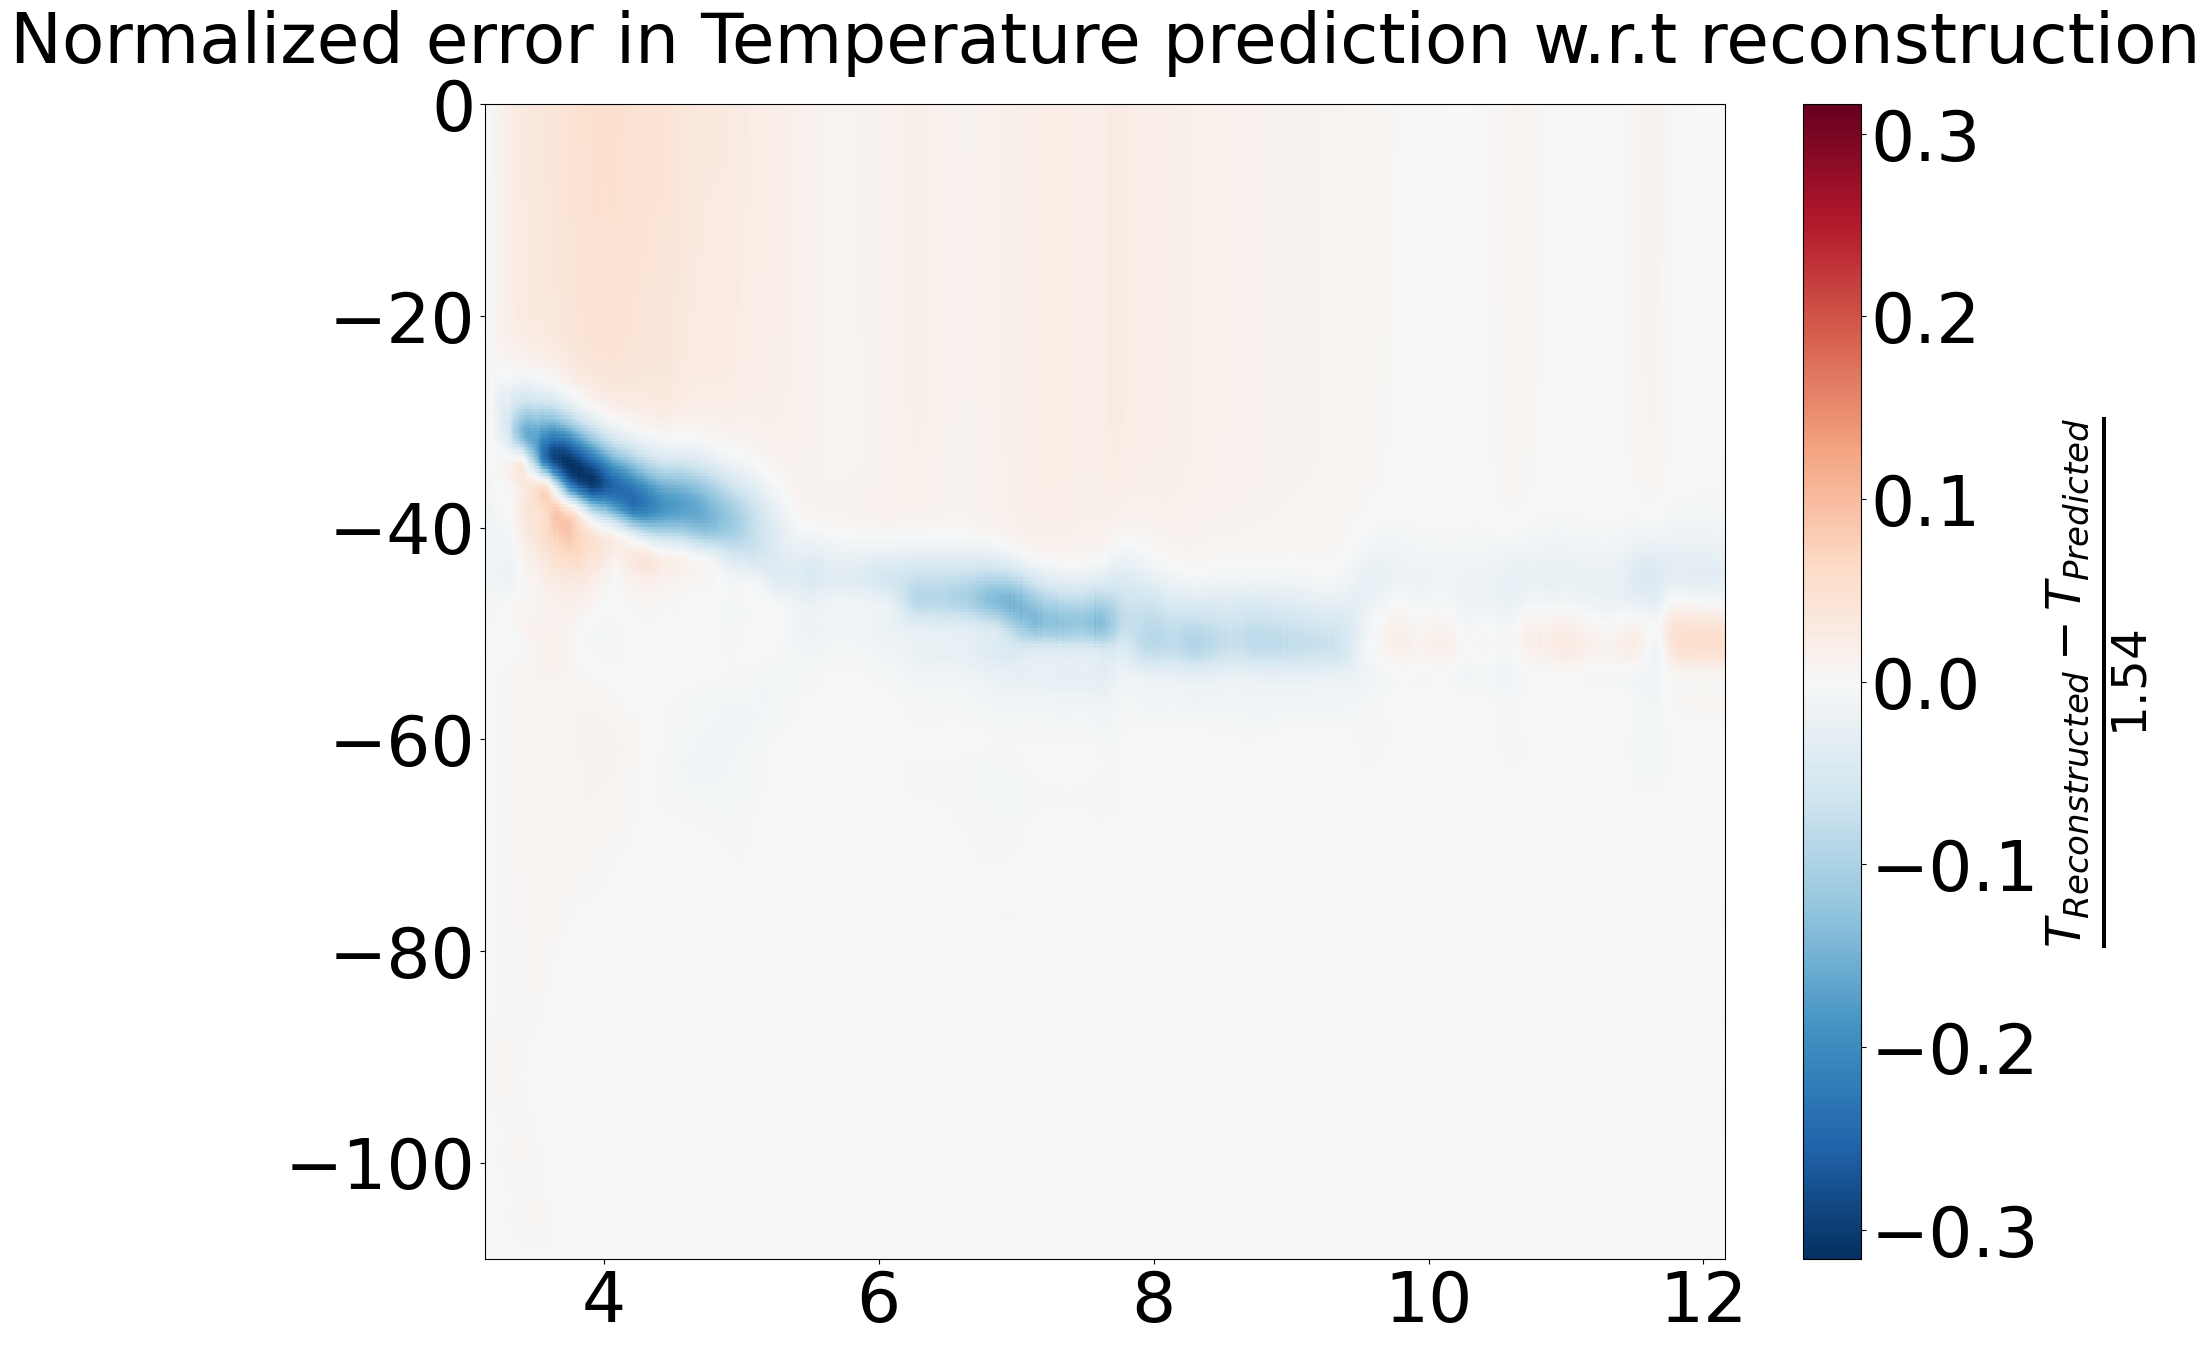

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
from matplotlib.colors import Normalize


data = In.inv_transform(x_rec1[time_step:,:,:].cpu().detach().numpy())[:-1,1:,0] / 1.54 - In.inv_transform(decoded_predictions[:-1,1:,:].cpu().detach().numpy())[:,:,0] / 1.54
max_val = np.max(np.abs(data))


norm = Normalize(vmin=-max_val, vmax=max_val)


im = ax.pcolormesh(tt[:-1,:], xx[:-1,:], data, label='predicted', norm=norm, cmap="RdBu_r")
ax.set_title('Normalized error in Temperature prediction w.r.t reconstruction', fontsize=50, pad=30)


colo = plt.colorbar(im, ax=ax)
colo.ax.tick_params(axis='both', labelsize=50)
ax.tick_params(axis='both', labelsize=50)


colo.set_label(r'$\frac{T_{Reconstructed} - T_{Predicted}}{1.54}$', fontsize=50)
plt.show()

